# Learning From the Pros: Extracting Professional Goalkeeper Technique from Broadcast Footage

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import math
import cv2
import gkpose as gk
import ast
import re
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from mplsoccer import VerticalPitch
from matplotlib.lines import Line2D

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import and Prepare Data

In [62]:
#Import 3D pose keypoints
set_3d_df = pd.read_csv('data/pose_3d.csv', index_col=0)
set_3d_df = gk.getPhotoID(set_3d_df)

In [63]:
#Import 2D pose keypoints (given in image coordinates)
set_2d_df = pd.read_csv('data/pose_2d.csv', index_col=0)
set_2d_df = gk.getPhotoID(set_2d_df)

In [64]:
#Import StatsBomb 1v1 Data
converter = {
    'location':ast.literal_eval,
    'shot_end_location':ast.literal_eval,
    'shot_freeze_frame':ast.literal_eval
}
sb_df = pd.read_csv('data/1v1_events.csv', converters = converter, index_col=0)

In [65]:
#Inspect 3d pose dataset
set_3d_df.head()

0         1         2         3         4         5         6  \
0 -0.187500  0.281250 -0.015079 -0.140625  0.140625  0.169988 -0.046875   
1  0.171875  0.281250  0.033766  0.187500  0.140625  0.152587  0.031250   
2 -0.093750  0.359375  0.016994  0.015625  0.234375  0.005835 -0.031250   
3 -0.156250  0.390625 -0.044468 -0.140625  0.171875  0.159150 -0.046875   
4 -0.125000  0.406250 -0.001968 -0.125000  0.203125  0.166595 -0.062500   

          7         8         9  ...       40        41        42        43  \
0 -0.015625 -0.012308  0.046875  ... -0.21875 -0.011179  0.203125 -0.093750   
1  0.000000 -0.045793 -0.031250  ... -0.21875  0.033514  0.031250 -0.093750   
2  0.015625 -0.043475  0.046875  ... -0.15625 -0.072264  0.234375 -0.046875   
3  0.000000 -0.028738  0.062500  ... -0.34375 -0.019926  0.234375 -0.234375   
4  0.000000 -0.005656  0.078125  ... -0.28125 -0.014175  0.140625 -0.234375   

         44        45        46        47       file  photo_id  
0  0.066936  0.281250  0.000000  0.089892  382-2.png       382  
1  0.138639  0.109375 -0.031250  0.116491  262-2.png       262  
2 -0.004875  0.281250  0.062500 -0.011386  537-2.png       537  
3  0.068202  0.359375 -0.140625  0.027107  476-2.png       476  
4  0.037226  0.140625 -0.109375  0.019169     63.png        63  

[5 rows x 50 columns]

In [66]:
sb_df.head()

duration play_pattern_name  under_pressure shot_outcome_name  \
0     0.240      Regular Play               1             Saved   
1     0.213      Regular Play               0             Saved   
2     0.667      Regular Play               0              Goal   
3     0.827      From Counter               0              Goal   
4     0.453       From Corner               0           Blocked   

   shot_first_time  distance_to_goal  shot_angle               gk_name  \
0                1         13.453624   48.012788       Danijel Subašić   
1                0         14.866069   47.726311  David Ospina Ramírez   
2                0         13.892444   30.256437     Wojciech Szczęsny   
3                0         15.132746    7.594643     Wojciech Szczęsny   
4                0          8.062258   60.255119  David Ospina Ramírez   

   gk_engage assist_type                     player_name  
0   0.525588        Pass  Martin Braithwaite Christensen  
1   0.190261        Pass              Robert Lewandowski  
2   0.580334        Pass    Radamel Falcao García Zárate  
3   0.738818        Pass   Juan Guillermo Cuadrado Bello  
4   0.447214       Other             Grzegorz Krychowiak

In [67]:
#Merge 3d and 2d pose data with 1v1 events data
set_3d_df = set_3d_df.merge(sb_df, left_on='photo_id', right_index=True, how='left')
set_2d_df = set_2d_df.merge(sb_df, left_on='photo_id', right_index=True, how='left')

In [68]:
#Store the 3d and 2d pose coordinates separately
sets_3d = set_3d_df.loc[:,'0':'47'].values
sets_2d = set_2d_df.loc[:,'0':'31'].values

## View-Invariance

In [70]:
#Get camera-view invariant dataset of 3d poses
cvi_arr = gk.cameraInvariantDataset(sets_3d)
sets_3d_cvi = gk.flipBehindPoses(cvi_arr)

In [71]:
#Create the view-invariant dataframe
set_3d_cvi_df = pd.DataFrame(sets_3d_cvi)
set_3d_cvi_df.columns = set_3d_cvi_df.columns.astype(str)
cols = ['file', 'photo_id', 'duration', 'play_pattern_name', 'under_pressure',
       'shot_outcome_name', 'shot_first_time', 'distance_to_goal',
       'shot_angle', 'gk_name', 'gk_engage', 'assist_type']
set_3d_cvi_df[cols] = set_3d_df[cols]

In [72]:
#Create view-invariant array with GKEM included
keep_cols = np.array(list(range(48)) + ['gk_engage'])
sets_3d_cvi = set_3d_cvi_df.loc[:,keep_cols].values

In [73]:
set_3d_cvi_df.head(5)

0         1         2         3         4         5         6  \
0 -0.187270  0.281250  0.017709 -0.108971  0.140625  0.191825 -0.048300   
1 -0.084613  0.281250 -0.153368 -0.003635  0.140625 -0.241714 -0.055167   
2 -0.047243  0.359375  0.082741  0.014513  0.234375 -0.008219 -0.053391   
3 -0.157551  0.390625  0.039614 -0.042210  0.171875  0.208141 -0.054964   
4 -0.125000  0.406250 -0.001968 -0.125000  0.203125  0.166595 -0.062500   

          7         8         9  ...  duration  play_pattern_name  \
0 -0.015625 -0.003981  0.047579  ...  0.186800     From Free Kick   
1  0.000000  0.005496  0.049572  ...  0.454694      From Throw In   
2  0.015625 -0.004006  0.063689  ...  0.771300      From Throw In   
3  0.000000 -0.001450  0.065672  ...  0.714875       Regular Play   
4  0.000000 -0.005656  0.078125  ...  0.533000     From Free Kick   

   under_pressure  shot_outcome_name  shot_first_time  distance_to_goal  \
0               0              Saved                0          7.280110   
1               1               Goal                0         11.180340   
2               0               Goal                0         11.313708   
3               0              Saved                0         12.041595   
4               0               Goal                1          8.485281   

   shot_angle         gk_name  gk_engage  assist_type  
0   74.054604     Jonas Lössl   0.566352        Other  
1   63.434949     Hugo Lloris   0.644981         Pass  
2   45.000000     Mathew Ryan   1.000000         Pass  
3    4.763642      Tom Heaton   0.332182         Pass  
4   45.000000  Eiji Kawashima   0.687184         Pass  

[5 rows x 60 columns]

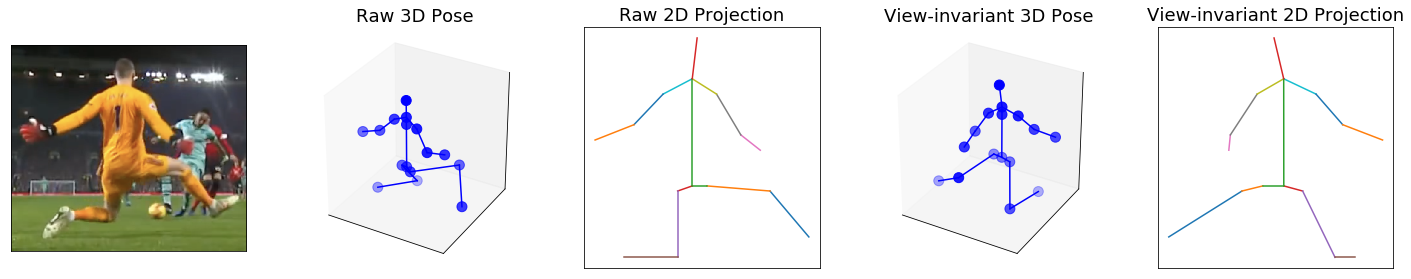

In [112]:
#Camera-view invariance example
pose_id = 319
photo_id = set_3d_df.loc[319,'file']
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 5, 1)
path = 'images/1v1_images/'
ax.imshow(gk.importImage(path + photo_id))
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 5, 2, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(sets_3d[pose_id]), mpii_edges)
ax.set_title('Raw 3D Pose', fontsize=18, pad=25)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax = fig.add_subplot(1, 5, 4, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(sets_3d_cvi[pose_id][:-1]), mpii_edges)
ax.set_title('View-invariant 3D Pose', fontsize=18, pad=25)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax = fig.add_subplot(1, 5, 3)
gk.plot2D(ax, gk.pose_to_matrix(sets_3d[pose_id]), mpii_edges)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Raw 2D Projection', fontsize=18)
ax = fig.add_subplot(1, 5, 5)
gk.plot2D(ax, gk.pose_to_matrix(sets_3d_cvi[pose_id][:-1]), mpii_edges)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('View-invariant 2D Projection', fontsize=18)
plt.tight_layout()
#plt.savefig('paper_viz/view_invariance.png')
plt.show()

In [101]:
set_3d_df.loc[319,'file']

'235-3.png'

In [13]:
def removePoorPredictions(set_3d_cvi_df):
    #List of the array_ids in which to remove because they are bad prediction of true pose
    to_remove_sets = np.array([1,6,7,11,14,25,27,28,31,32,37,40,42,43,44,51,52,53,55,58,
                               63,65,72,81,83,85,87,94,96,108,109,110,113,114,116,117,119,
                               123,131,133,135,136,137,140,141,143,144,147,150,151,154,156,
                               157,159,160,161,163,167,170,176,189,193,195,196,198,200,
                               202,203,206,207,210,211,213,216,217,218,220,227,228,235,
                               237,238,242,243,244,245,250,251,252,255,261,262,267,268,
                               270,271,274,275,276,282,287,291,296,297,298,304,305,311,312,
                               316,320,323,324,326,327,328,333,334,335,341,350,351,352,370,
                               372,374,379,387,388,389,390,395,397,401,406,411,413,414,418,
                               419,423,433,436,439,443,446,451,452,453,456,462,465,470,472,
                               474,475,480,489,490,494,502,507,509,515,517,522,528,532,533,
                               537,553,555,558,566,567,570,572,575,579,580,585,])
    #Remove selected poses
    set_3d_cvi_clean_df = set_3d_cvi_df.drop(to_remove_sets).reset_index(drop=True)
    keep_cols = np.array(list(range(48)) + ['gk_engage'])
    sets_3d_cvi_clean = set_3d_cvi_clean_df.loc[:,keep_cols].values
    return sets_3d_cvi_clean, set_3d_cvi_clean_df

In [14]:
sets_3d_cvi_clean, set_3d_cvi_clean_df = removePoorPredictions(set_3d_cvi_df)

In [15]:
set_3d_cvi_clean_df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
       'file', 'photo_id', 'duration', 'play_pattern_name', 'under_pressure',
       'shot_outcome_name', 'shot_first_time', 'distance_to_goal',
       'shot_angle', 'gk_name', 'gk_engage', 'assist_type'],
      dtype='object')

In [16]:
set_3d_cvi_clean_df.loc[:,'file':]

file  photo_id  duration play_pattern_name  under_pressure  \
0    382-2.png       382  0.186800    From Free Kick               0   
1    537-2.png       537  0.771300     From Throw In               0   
2    476-2.png       476  0.714875      Regular Play               0   
3       63.png        63  0.533000    From Free Kick               0   
4       88.png        88  0.960000      Regular Play               1   
..         ...       ...       ...               ...             ...   
404    231.png       231  0.559500    From Free Kick               0   
405  522-2.png       522  0.778941    From Free Kick               0   
406  487-2.png       487  0.250700     From Throw In               0   
407    230.png       230  0.169700      Regular Play               0   
408  357-2.png       357  0.359300     From Throw In               0   

    shot_outcome_name  shot_first_time  distance_to_goal  shot_angle  \
0               Saved                0          7.280110   74.054604   
1                Goal                0         11.313708   45.000000   
2               Saved                0         12.041595    4.763642   
3                Goal                1          8.485281   45.000000   
4               Off T                0         20.248457   57.094757   
..                ...              ...               ...         ...   
404              Goal                0          3.162278   18.434949   
405              Goal                0          8.602325   35.537678   
406             Saved                0         11.401754   15.255119   
407             Saved                0         18.867962   32.005383   
408             Saved                1         14.422205   56.309932   

                  gk_name  gk_engage assist_type  
0             Jonas Lössl   0.566352       Other  
1             Mathew Ryan   1.000000        Pass  
2              Tom Heaton   0.332182        Pass  
3          Eiji Kawashima   0.687184        Pass  
4             Hugo Lloris   0.931822        Pass  
..                    ...        ...         ...  
404       Martin Dúbravka   0.447214       Other  
405  Sergio Rico González   0.838274       Cross  
406  Sergio Rico González   0.667947       Other  
407       Martin Dúbravka   0.191094       Other  
408       Wayne Hennessey   0.500000        Pass  

[409 rows x 12 columns]

## Learning Save Technique - Unsupervised Learning

In [17]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [18]:
#Create 3D - 2D projection dataset
to_delete = np.array([ x-1 for x in range(0,49) if x%3==0][1:])
sets_2d_proj = np.delete(sets_3d_cvi_clean, to_delete, 1)

In [19]:
sets_2d_proj

array([[-0.1872699 ,  0.28125   , -0.10897051, ...,  0.29258682,
         0.        ,  0.56635211],
       [-0.0472428 ,  0.359375  ,  0.01451345, ...,  0.17206158,
         0.0625    ,  1.        ],
       [-0.15755057,  0.390625  , -0.04220972, ...,  0.32478162,
        -0.140625  ,  0.33218192],
       ...,
       [-0.13535176,  0.265625  , -0.09407528, ...,  0.17360783,
         0.046875  ,  0.66794749],
       [-0.04923076,  0.25      , -0.16682544, ...,  0.02462617,
        -0.015625  ,  0.19109384],
       [-0.05848658,  0.296875  , -0.16954671, ...,  0.12902675,
         0.015625  ,  0.5       ]])

In [20]:
#Train K-Means 
kmeans = KMeans(n_clusters=4, random_state = 689).fit(sets_2d_proj)

In [21]:
#Get cluster membership label for each save - represents chosen save technique
kmeans_preds = kmeans.predict(sets_2d_proj)

In [23]:
#Clusters are named using domain knowledge
cluster_name = ['Aggressive Set', 'Passive Set', 'Spread', 'Smother']

In [24]:
#Get 2D TSNE representation of body pose
pose_tsne = TSNE(n_components=2, random_state=1244).fit_transform(sets_2d_proj)

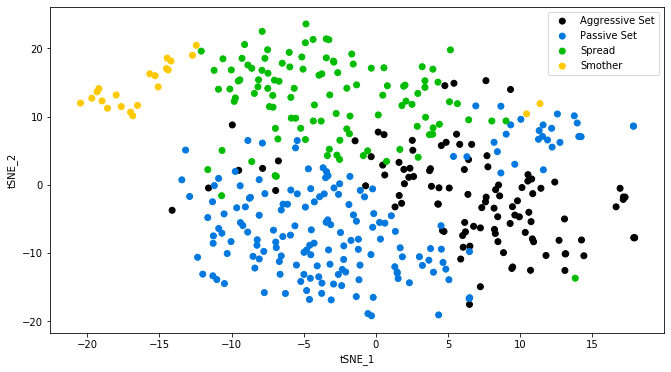

In [25]:
plt.figure(figsize=(11, 6))
for i in range(4):
    current_pose_type = pose_tsne[kmeans_preds == i]
    colors_kmeans = cm.nipy_spectral(kmeans_preds[kmeans_preds==i].astype(float) / 4)
    plt.scatter(current_pose_type[:,0], current_pose_type[:,1], 
                c=colors_kmeans, label=cluster_name[i])
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.legend()
#plt.savefig('tsne_1v1.png')
plt.show()

In [26]:
#Find saves that are closest to cluster centres
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, sets_2d_proj)

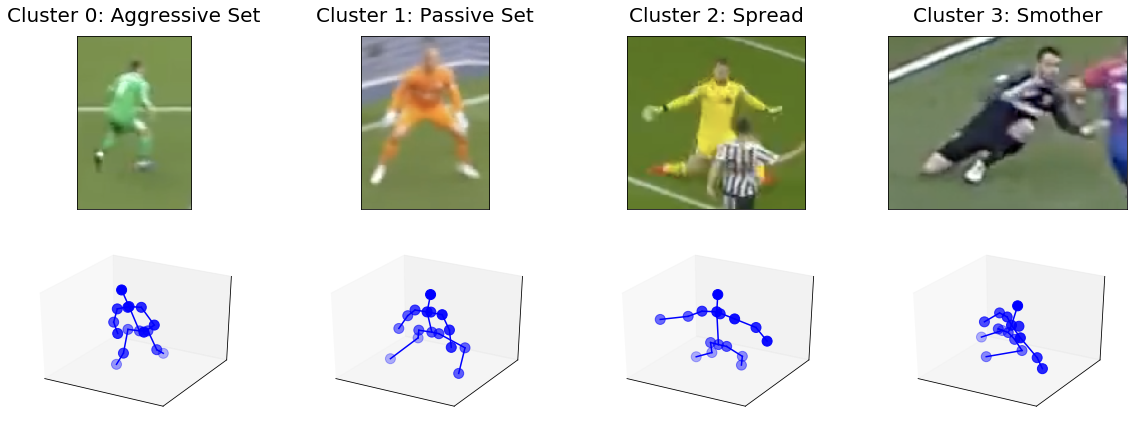

In [28]:
#Defines body pose skeleton for plots
mpii_edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5], 
              [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15], 
              [6, 8], [8, 9]]
#Plot the most representative saves for each cluster
path = 'images/1v1_images/'
fig = plt.figure(figsize=(20,7))
for i in range(4):
    photo_id = gk.ImageID(set_3d_cvi_clean_df, closest[i])
    ax = fig.add_subplot(2, 4, i+1)
    ax.imshow(gk.importImage(path + photo_id))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Cluster ' + str(i) + ': ' + cluster_name[i], size=20, pad=15)

    ax = fig.add_subplot(2, 4, 5+i, projection='3d')
    gk.plot3D(ax, gk.pose_to_matrix(sets_3d_cvi_clean[closest[i]][:-1]), mpii_edges)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
#plt.savefig('paper_viz/clusters_closest.png')

In [28]:
def saveClusters(clusters, file_name, path='data/'):
    pd.DataFrame(clusters, columns=['cluster']).to_csv(path + file_name, index=False)

In [58]:
saveClusters(kmeans_preds, file_name='kmeans_2d_k4.csv')

## 1v1 Expected Saves Model

In [29]:
def getTrainTest(df, test_size=0.2):
    on_target = (df['shot_outcome_name'] == 'Goal') | (df['shot_outcome_name'] == 'Saved')
    features = ['photo_id','gk_name','shot_outcome_name','cluster','shot_angle','distance_to_goal',
                'under_pressure']
    ml_df = df.loc[on_target, features].copy()
    ml_df['shot_outcome_name'].replace({'Goal': 0, 'Saved': 1}, inplace=True)
    ml_df = pd.get_dummies(ml_df, columns=['cluster'])
    ml_df = ml_df.reset_index(drop=True)
    test_ind = np.random.choice(range(ml_df.shape[0]), int(ml_df.shape[0] * test_size))
    print(test_ind)
    test_df = ml_df.loc[test_ind, :].copy()
    train_df = ml_df.drop(test_ind).reset_index(drop=True)
    return train_df, test_df

In [30]:
#Get data for xS model
df = set_3d_cvi_clean_df.loc[:,'file':]
df['cluster'] = kmeans_preds #Add save technique as feature

In [31]:
df.head(2)

file  photo_id  duration play_pattern_name  under_pressure  \
0  382-2.png       382    0.1868    From Free Kick               0   
1  537-2.png       537    0.7713     From Throw In               0   

  shot_outcome_name  shot_first_time  distance_to_goal  shot_angle  \
0             Saved                0          7.280110   74.054604   
1              Goal                0         11.313708   45.000000   

       gk_name  gk_engage assist_type  cluster  
0  Jonas Lössl   0.566352       Other        1  
1  Mathew Ryan   1.000000        Pass        1

In [32]:
#Get train/test split
good_random_states = [501,701,801,805]
np.random.seed(1301)
train_df, test_df = getTrainTest(df, test_size=0.3)

[171 180 177 209  84  17  52 226  56  21 192 263 105  19  47 282   1 101
 189 261 117  58 115 274 234 109 159 119 188 146 271 166 198 120 199   5
 185 286  84  25 227 165 119 211  94 198 265 294 279 171 214 138 284 245
 183  29 290 155 194 168  51 228  64 176  31 114  98 292 134  10 104 110
 200 121 128 166 248 106 101 217 168 196  90  26 137  42  15 291 134 301
 152  17]


In [33]:
train_gk_name = train_df['gk_name']
train_photo_id = train_df['photo_id']
test_gk_name = test_df['gk_name']
test_photo_id = test_df['photo_id']

train_df.drop('photo_id', axis=1, inplace=True)
test_df.drop('photo_id', axis=1, inplace=True)
train_df.drop('gk_name', axis=1, inplace=True)
test_df.drop('gk_name', axis=1, inplace=True)

In [34]:
test_photo_id[test_gk_name=='Bernd Leno']

25     361
228    395
Name: photo_id, dtype: int64

In [35]:
np.where(test_photo_id == 395)

(array([61]),)

In [36]:
scaler = StandardScaler().fit(train_df[['shot_angle','distance_to_goal']])
train_df[['shot_angle','distance_to_goal']] = scaler.transform(train_df[['shot_angle','distance_to_goal']])
test_df[['shot_angle','distance_to_goal']] = scaler.transform(test_df[['shot_angle','distance_to_goal']])

In [37]:
#Get training set X and y
y_train = train_df.pop('shot_outcome_name')
X_train = train_df.values
#Get test set X and y
y_test = test_df.pop('shot_outcome_name')
X_test = test_df.values

In [38]:
print("Training Set Size:", len(X_train))
print("Test Set Size:", len(X_test))

Training Set Size: 224
Test Set Size: 92


In [39]:
#Train SVM Model
svm = SVC(C=1.0, kernel='rbf',probability=True, random_state=101).fit(X_train, y_train)

In [40]:
#Test Accuracy of SVM Model
print("Test Set Accuracy:", np.mean(svm.predict(X_test) == np.array(y_test)))

Test Set Accuracy: 0.5978260869565217


In [41]:
def getxSInput(df, scaler, angle, dist, up=0, cluster=0, assist_type='Pass'):
    k = len(df.filter(regex='cluster').columns)
    angle_dist = scaler.transform([[angle,dist]])[0]
    up = np.array([up])
    clust = np.zeros(k)
    clust[cluster] = 1
    if assist_type == 'Cross':
        ass_t = np.array([1, 0, 0])
    elif assist_type == 'Other':
        ass_t = np.array([0, 1, 0])
    else:
        ass_t = np.array([0, 0, 1])
    return np.array([np.concatenate((angle_dist,up,clust))])

In [47]:
def getXSMap(train_df, model, scaler, num_clusters, up=0, ass='Pass'):
    #Sets: Probability Map
    x_range = np.linspace(90, 120.01, 50)
    y_range = np.linspace(0, 80, 50)
    xs_map = np.zeros((num_clusters, len(x_range), len(y_range)))
    for cluster in range(num_clusters):
        for x in range(len(x_range)):
            for y in range(len(y_range)):
                d = gk.distance_to_goal(shooter_x=x_range[x], shooter_y=y_range[y])
                a = gk.goal_angle(shooter_x=x_range[x], shooter_y=y_range[y])
                xs = []
                for n in range(num_clusters):
                    inp = getxSInput(train_df,scaler,angle=a,dist=d,up=up,cluster=n)
                    xs.append(model.predict_proba(inp)[0][1])
                mean_xs = np.mean(xs)
                inp = getxSInput(train_df,scaler,angle=a,dist=d,up=up,cluster=cluster)
                xs_map[cluster][x, y] = model.predict_proba(inp)[0][1] - mean_xs
        print("done cluster", cluster)
    return xs_map

In [43]:
def plotXSMap(xs_map, num_clusters, cluster_names):
    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-30, 
                          pad_left=-10, pad_right=-10, line_color='black')
    fig, ax = pitch.draw(figsize=(10, 5), nrows=1, ncols=num_clusters, tight_layout=True)
    for i in range(num_clusters):
        im = ax[i].imshow(xs_map[i], cmap=plt.cm.Greens, interpolation='none', 
                       vmin=xs_map.min(), vmax=xs_map.max(), extent=[0,80,120,90])
        ax[i].set_title('Cluster ' + str(i) + ': ' + cluster_names[i])
    cax = plt.axes([1, 0.3, 0.05, 0.4])
    plt.colorbar(im, cax=cax)

In [44]:
def plotBestTechniqueUp(xs_map, xs_map_up, cluster_name):
    #Best technique to use
    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-37, 
                          pad_left=-15, pad_right=-15, line_color='black',
                          orientation='horizontal')
    fig, ax = pitch.draw(figsize=(10,5), nrows=1, ncols=2)
    cmap = plt.cm.tab20
    im = ax[0].imshow(np.argmax(xs_map, axis=0), cmap=cmap,
                      interpolation='none', extent=[0,80,120,90])
    im = ax[1].imshow(np.argmax(xs_map_up, axis=0), cmap=cmap,
                      interpolation='none', extent=[0,80,120,90])
    ax[0].set_title('Striker Not Under Pressure')
    ax[1].set_title('Striker Under Pressure')
    custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                    Line2D([0], [0], color=cmap(0.33), lw=4),
                    Line2D([0], [0], color=cmap(0.66), lw=4),
                    Line2D([0], [0], color=cmap(1.), lw=4)]
    ax[1].legend(custom_lines, cluster_name, 
              loc=1, bbox_to_anchor=(1, 0.38))

In [45]:
def plotDoubleXSMap(xs_map, xs_map_up, num_clusters=4, cluster_names=cluster_name):
    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-30, 
                          pad_left=-10, pad_right=-10, line_color='black')
    fig, ax = pitch.draw(figsize=(10, 5), nrows=2, ncols=num_clusters, tight_layout=True)
    min_v = np.min([xs_map.min(),xs_map_up.min()])
    max_v = np.max([xs_map.max(),xs_map_up.max()])
    for i in range(num_clusters):
        im = ax[0, i].imshow(xs_map[i], cmap=plt.cm.Greens, interpolation='none', 
                       vmin=min_v, vmax=max_v, extent=[0,80,120,90])
        ax[0, i].set_title('Cluster ' + str(i) + ': ' + cluster_names[i])
        if i == 0:
            ax[0,i].set_ylabel('No Pressure', rotation=0, labelpad=33)
    for i in range(num_clusters):
        im = ax[1, i].imshow(xs_map_up[i], cmap=plt.cm.Greens, interpolation='none', 
                       vmin=min_v, vmax=max_v, extent=[0,80,120,90])
        #ax[1, i].set_title('Cluster ' + str(i) + ': ' + cluster_names[i])
        if i == 0:
            ax[1,i].set_ylabel('Pressure', rotation=0, labelpad=33)
    cax = plt.axes([1, 0.3, 0.05, 0.4])
    cax.set_title('xSAA')
    plt.colorbar(im, cax=cax)
    plt.tight_layout()

In [46]:
#Calculate xS map when striker is not under pressure
xs_map = getXSMap(train_df, svm, scaler, num_clusters=4, up=0)

[[0.75346678 8.9594983  0.         1.         0.         0.
  0.        ]]
[[0.75346678 8.9594983  0.         0.         1.         0.
  0.        ]]
[[0.75346678 8.9594983  0.         0.         0.         1.
  0.        ]]
[[0.75346678 8.9594983  0.         0.         0.         0.
  1.        ]]
[[0.69718639 8.65980085 0.         1.         0.         0.
  0.        ]]
[[0.69718639 8.65980085 0.         0.         1.         0.
  0.        ]]
[[0.69718639 8.65980085 0.         0.         0.         1.
  0.        ]]
[[0.69718639 8.65980085 0.         0.         0.         0.
  1.        ]]
[[0.63785378 8.36490722 0.         1.         0.         0.
  0.        ]]
[[0.63785378 8.36490722 0.         0.         1.         0.
  0.        ]]
[[0.63785378 8.36490722 0.         0.         0.         1.
  0.        ]]
[[0.63785378 8.36490722 0.         0.         0.         0.
  1.        ]]
[[0.57527168 8.07521552 0.         1.         0.         0.
  0.        ]]
[[0.57527168 8.07521552 0

[[-0.50600267  5.20765008  0.          1.          0.          0.
   0.        ]]
[[-0.50600267  5.20765008  0.          0.          1.          0.
   0.        ]]
[[-0.50600267  5.20765008  0.          0.          0.          1.
   0.        ]]
[[-0.50600267  5.20765008  0.          0.          0.          0.
   1.        ]]
[[-0.38852711  5.38804611  0.          1.          0.          0.
   0.        ]]
[[-0.38852711  5.38804611  0.          0.          1.          0.
   0.        ]]
[[-0.38852711  5.38804611  0.          0.          0.          1.
   0.        ]]
[[-0.38852711  5.38804611  0.          0.          0.          0.
   1.        ]]
[[-0.2764275  5.5818894  0.         1.         0.         0.
   0.       ]]
[[-0.2764275  5.5818894  0.         0.         1.         0.
   0.       ]]
[[-0.2764275  5.5818894  0.         0.         0.         1.
   0.       ]]
[[-0.2764275  5.5818894  0.         0.         0.         0.
   1.       ]]
[[-0.16967849  5.7882478   0.          1

[[-1.76338637  4.19652376  0.          1.          0.          0.
   0.        ]]
[[-1.76338637  4.19652376  0.          0.          1.          0.
   0.        ]]
[[-1.76338637  4.19652376  0.          0.          0.          1.
   0.        ]]
[[-1.76338637  4.19652376  0.          0.          0.          0.
   1.        ]]
[[-1.76338637  4.19652376  0.          1.          0.          0.
   0.        ]]
[[-1.76338637  4.19652376  0.          0.          1.          0.
   0.        ]]
[[-1.76338637  4.19652376  0.          0.          0.          1.
   0.        ]]
[[-1.76338637  4.19652376  0.          0.          0.          0.
   1.        ]]
[[-1.60845937  4.21745411  0.          1.          0.          0.
   0.        ]]
[[-1.60845937  4.21745411  0.          0.          1.          0.
   0.        ]]
[[-1.60845937  4.21745411  0.          0.          0.          1.
   0.        ]]
[[-1.60845937  4.21745411  0.          0.          0.          0.
   1.        ]]
[[-1.45494762  4

[[-0.58376386  4.78558246  0.          0.          1.          0.
   0.        ]]
[[-0.58376386  4.78558246  0.          0.          0.          1.
   0.        ]]
[[-0.58376386  4.78558246  0.          0.          0.          0.
   1.        ]]
[[-0.71538712  4.62960961  0.          1.          0.          0.
   0.        ]]
[[-0.71538712  4.62960961  0.          0.          1.          0.
   0.        ]]
[[-0.71538712  4.62960961  0.          0.          0.          1.
   0.        ]]
[[-0.71538712  4.62960961  0.          0.          0.          0.
   1.        ]]
[[-0.8524955   4.49031955  0.          1.          0.          0.
   0.        ]]
[[-0.8524955   4.49031955  0.          0.          1.          0.
   0.        ]]
[[-0.8524955   4.49031955  0.          0.          0.          1.
   0.        ]]
[[-0.8524955   4.49031955  0.          0.          0.          0.
   1.        ]]
[[-0.99474096  4.36871265  0.          1.          0.          0.
   0.        ]]
[[-0.99474096  4

  0.        ]]
[[0.20710316 6.15320603 0.         0.         0.         0.
  1.        ]]
[[0.11472973 5.90554947 0.         1.         0.         0.
  0.        ]]
[[0.11472973 5.90554947 0.         0.         1.         0.
  0.        ]]
[[0.11472973 5.90554947 0.         0.         0.         1.
  0.        ]]
[[0.11472973 5.90554947 0.         0.         0.         0.
  1.        ]]
[[0.01693016 5.66771335 0.         1.         0.         0.
  0.        ]]
[[0.01693016 5.66771335 0.         0.         1.         0.
  0.        ]]
[[0.01693016 5.66771335 0.         0.         0.         1.
  0.        ]]
[[0.01693016 5.66771335 0.         0.         0.         0.
  1.        ]]
[[-0.08652725  5.44056911  0.          1.          0.          0.
   0.        ]]
[[-0.08652725  5.44056911  0.          0.          1.          0.
   0.        ]]
[[-0.08652725  5.44056911  0.          0.          0.          1.
   0.        ]]
[[-0.08652725  5.44056911  0.          0.          0.          0

  0.        ]]
[[0.75350658 8.01571216 0.         0.         0.         0.
  1.        ]]
[[0.69207907 7.71621977 0.         1.         0.         0.
  0.        ]]
[[0.69207907 7.71621977 0.         0.         1.         0.
  0.        ]]
[[0.69207907 7.71621977 0.         0.         0.         1.
  0.        ]]
[[0.69207907 7.71621977 0.         0.         0.         0.
  1.        ]]
[[0.62701205 7.42199565 0.         1.         0.         0.
  0.        ]]
[[0.62701205 7.42199565 0.         0.         1.         0.
  0.        ]]
[[0.62701205 7.42199565 0.         0.         0.         1.
  0.        ]]
[[0.62701205 7.42199565 0.         0.         0.         0.
  1.        ]]
[[0.5580492  7.13351753 0.         1.         0.         0.
  0.        ]]
[[0.5580492  7.13351753 0.         0.         1.         0.
  0.        ]]
[[0.5580492  7.13351753 0.         0.         0.         1.
  0.        ]]
[[0.5580492  7.13351753 0.         0.         0.         0.
  1.        ]]
[[0.484921

[[0.62701205 7.42199565 0.         1.         0.         0.
  0.        ]]
[[0.62701205 7.42199565 0.         0.         1.         0.
  0.        ]]
[[0.62701205 7.42199565 0.         0.         0.         1.
  0.        ]]
[[0.62701205 7.42199565 0.         0.         0.         0.
  1.        ]]
[[0.69207907 7.71621977 0.         1.         0.         0.
  0.        ]]
[[0.69207907 7.71621977 0.         0.         1.         0.
  0.        ]]
[[0.69207907 7.71621977 0.         0.         0.         1.
  0.        ]]
[[0.69207907 7.71621977 0.         0.         0.         0.
  1.        ]]
[[0.75350658 8.01571216 0.         1.         0.         0.
  0.        ]]
[[0.75350658 8.01571216 0.         0.         1.         0.
  0.        ]]
[[0.75350658 8.01571216 0.         0.         0.         1.
  0.        ]]
[[0.75350658 8.01571216 0.         0.         0.         0.
  1.        ]]
[[0.81153713 8.32003938 0.         1.         0.         0.
  0.        ]]
[[0.81153713 8.32003938 0

   0.        ]]
[[-0.02701633  5.21301999  0.          0.          0.          0.
   1.        ]]
[[0.0776222 5.4465898 0.        1.        0.        0.        0.       ]]
[[0.0776222 5.4465898 0.        0.        1.        0.        0.       ]]
[[0.0776222 5.4465898 0.        0.        0.        1.        0.       ]]
[[0.0776222 5.4465898 0.        0.        0.        0.        1.       ]]
[[0.17622877 5.69077131 0.         1.         0.         0.
  0.        ]]
[[0.17622877 5.69077131 0.         0.         1.         0.
  0.        ]]
[[0.17622877 5.69077131 0.         0.         0.         1.
  0.        ]]
[[0.17622877 5.69077131 0.         0.         0.         0.
  1.        ]]
[[0.26908576 5.94465486 0.         1.         0.         0.
  0.        ]]
[[0.26908576 5.94465486 0.         0.         1.         0.
  0.        ]]
[[0.26908576 5.94465486 0.         0.         0.         1.
  0.        ]]
[[0.26908576 5.94465486 0.         0.         0.         0.
  1.        ]]
[[0.35

[[-1.07959562  3.71849499  0.          1.          0.          0.
   0.        ]]
[[-1.07959562  3.71849499  0.          0.          1.          0.
   0.        ]]
[[-1.07959562  3.71849499  0.          0.          0.          1.
   0.        ]]
[[-1.07959562  3.71849499  0.          0.          0.          0.
   1.        ]]
[[-1.24302425  3.62764844  0.          1.          0.          0.
   0.        ]]
[[-1.24302425  3.62764844  0.          0.          1.          0.
   0.        ]]
[[-1.24302425  3.62764844  0.          0.          0.          1.
   0.        ]]
[[-1.24302425  3.62764844  0.          0.          0.          0.
   1.        ]]
[[-1.41069971  3.55863423  0.          1.          0.          0.
   0.        ]]
[[-1.41069971  3.55863423  0.          0.          1.          0.
   0.        ]]
[[-1.41069971  3.55863423  0.          0.          0.          1.
   0.        ]]
[[-1.41069971  3.55863423  0.          0.          0.          0.
   1.        ]]
[[-1.58154613  3

   0.        ]]
[[-0.19579614  4.54439859  0.          0.          1.          0.
   0.        ]]
[[-0.19579614  4.54439859  0.          0.          0.          1.
   0.        ]]
[[-0.19579614  4.54439859  0.          0.          0.          0.
   1.        ]]
[[-0.32241371  4.34211582  0.          1.          0.          0.
   0.        ]]
[[-0.32241371  4.34211582  0.          0.          1.          0.
   0.        ]]
[[-0.32241371  4.34211582  0.          0.          0.          1.
   0.        ]]
[[-0.32241371  4.34211582  0.          0.          0.          0.
   1.        ]]
[[-0.45633747  4.15488444  0.          1.          0.          0.
   0.        ]]
[[-0.45633747  4.15488444  0.          0.          1.          0.
   0.        ]]
[[-0.45633747  4.15488444  0.          0.          0.          1.
   0.        ]]
[[-0.45633747  4.15488444  0.          0.          0.          0.
   1.        ]]
[[-0.59755131  3.98398857  0.          1.          0.          0.
   0.        ]]


  0.        ]]
[[0.45524347 5.91233346 0.         0.         1.         0.
  0.        ]]
[[0.45524347 5.91233346 0.         0.         0.         1.
  0.        ]]
[[0.45524347 5.91233346 0.         0.         0.         0.
  1.        ]]
[[0.36786015 5.64018417 0.         1.         0.         0.
  0.        ]]
[[0.36786015 5.64018417 0.         0.         1.         0.
  0.        ]]
[[0.36786015 5.64018417 0.         0.         0.         1.
  0.        ]]
[[0.36786015 5.64018417 0.         0.         0.         0.
  1.        ]]
[[0.27460635 5.37661626 0.         1.         0.         0.
  0.        ]]
[[0.27460635 5.37661626 0.         0.         1.         0.
  0.        ]]
[[0.27460635 5.37661626 0.         0.         0.         1.
  0.        ]]
[[0.27460635 5.37661626 0.         0.         0.         0.
  1.        ]]
[[0.17509916 5.12250836 0.         1.         0.         0.
  0.        ]]
[[0.17509916 5.12250836 0.         0.         1.         0.
  0.        ]]
[[0.175099

[[0.96451967 7.92281641 0.         1.         0.         0.
  0.        ]]
[[0.96451967 7.92281641 0.         0.         1.         0.
  0.        ]]
[[0.96451967 7.92281641 0.         0.         0.         1.
  0.        ]]
[[0.96451967 7.92281641 0.         0.         0.         0.
  1.        ]]
[[0.90884746 7.6066528  0.         1.         0.         0.
  0.        ]]
[[0.90884746 7.6066528  0.         0.         1.         0.
  0.        ]]
[[0.90884746 7.6066528  0.         0.         0.         1.
  0.        ]]
[[0.90884746 7.6066528  0.         0.         0.         0.
  1.        ]]
[[0.84964137 7.29478749 0.         1.         0.         0.
  0.        ]]
[[0.84964137 7.29478749 0.         0.         1.         0.
  0.        ]]
[[0.84964137 7.29478749 0.         0.         0.         1.
  0.        ]]
[[0.84964137 7.29478749 0.         0.         0.         0.
  1.        ]]
[[0.78661229 6.98763989 0.         1.         0.         0.
  0.        ]]
[[0.78661229 6.98763989 0

[[0.57135143 6.09946316 0.         1.         0.         0.
  0.        ]]
[[0.57135143 6.09946316 0.         0.         1.         0.
  0.        ]]
[[0.57135143 6.09946316 0.         0.         0.         1.
  0.        ]]
[[0.57135143 6.09946316 0.         0.         0.         0.
  1.        ]]
[[0.64781379 6.38942485 0.         1.         0.         0.
  0.        ]]
[[0.64781379 6.38942485 0.         0.         1.         0.
  0.        ]]
[[0.64781379 6.38942485 0.         0.         0.         1.
  0.        ]]
[[0.64781379 6.38942485 0.         0.         0.         0.
  1.        ]]
[[0.71944816 6.68567815 0.         1.         0.         0.
  0.        ]]
[[0.71944816 6.68567815 0.         0.         1.         0.
  0.        ]]
[[0.71944816 6.68567815 0.         0.         0.         1.
  0.        ]]
[[0.71944816 6.68567815 0.         0.         0.         0.
  1.        ]]
[[0.78661229 6.98763989 0.         1.         0.         0.
  0.        ]]
[[0.78661229 6.98763989 0

[[-1.18379311  3.0754173   0.          1.          0.          0.
   0.        ]]
[[-1.18379311  3.0754173   0.          0.          1.          0.
   0.        ]]
[[-1.18379311  3.0754173   0.          0.          0.          1.
   0.        ]]
[[-1.18379311  3.0754173   0.          0.          0.          0.
   1.        ]]
[[-1.00582676  3.17495686  0.          1.          0.          0.
   0.        ]]
[[-1.00582676  3.17495686  0.          0.          1.          0.
   0.        ]]
[[-1.00582676  3.17495686  0.          0.          0.          1.
   0.        ]]
[[-1.00582676  3.17495686  0.          0.          0.          0.
   1.        ]]
[[-0.8345561   3.29701922  0.          1.          0.          0.
   0.        ]]
[[-0.8345561   3.29701922  0.          0.          1.          0.
   0.        ]]
[[-0.8345561   3.29701922  0.          0.          0.          1.
   0.        ]]
[[-0.8345561   3.29701922  0.          0.          0.          0.
   1.        ]]
[[-0.6708157  3.

[[-0.98516751  3.0397751   0.          0.          0.          0.
   1.        ]]
[[-1.16714204  2.93780646  0.          1.          0.          0.
   0.        ]]
[[-1.16714204  2.93780646  0.          0.          1.          0.
   0.        ]]
[[-1.16714204  2.93780646  0.          0.          0.          1.
   0.        ]]
[[-1.16714204  2.93780646  0.          0.          0.          0.
   1.        ]]
[[-1.35511379  2.86008054  0.          1.          0.          0.
   0.        ]]
[[-1.35511379  2.86008054  0.          0.          1.          0.
   0.        ]]
[[-1.35511379  2.86008054  0.          0.          0.          1.
   0.        ]]
[[-1.35511379  2.86008054  0.          0.          0.          0.
   1.        ]]
[[-1.54761675  2.80764269  0.          1.          0.          0.
   0.        ]]
[[-1.54761675  2.80764269  0.          0.          1.          0.
   0.        ]]
[[-1.54761675  2.80764269  0.          0.          0.          1.
   0.        ]]
[[-1.54761675  2

  0.        ]]
[[0.0954706  4.20153723 0.         0.         0.         0.
  1.        ]]
[[-0.0283783   3.96707815  0.          1.          0.          0.
   0.        ]]
[[-0.0283783   3.96707815  0.          0.          1.          0.
   0.        ]]
[[-0.0283783   3.96707815  0.          0.          0.          1.
   0.        ]]
[[-0.0283783   3.96707815  0.          0.          0.          0.
   1.        ]]
[[-0.16111442  3.74642217  0.          1.          0.          0.
   0.        ]]
[[-0.16111442  3.74642217  0.          0.          1.          0.
   0.        ]]
[[-0.16111442  3.74642217  0.          0.          0.          1.
   0.        ]]
[[-0.16111442  3.74642217  0.          0.          0.          0.
   1.        ]]
[[-0.3030657   3.54105725  0.          1.          0.          0.
   0.        ]]
[[-0.3030657   3.54105725  0.          0.          1.          0.
   0.        ]]
[[-0.3030657   3.54105725  0.          0.          0.          1.
   0.        ]]
[[-0.303

[[0.85982586 6.35162332 0.         0.         0.         1.
  0.        ]]
[[0.85982586 6.35162332 0.         0.         0.         0.
  1.        ]]
[[0.79027985 6.04392918 0.         1.         0.         0.
  0.        ]]
[[0.79027985 6.04392918 0.         0.         1.         0.
  0.        ]]
[[0.79027985 6.04392918 0.         0.         0.         1.
  0.        ]]
[[0.79027985 6.04392918 0.         0.         0.         0.
  1.        ]]
[[0.71565035 5.74196761 0.         1.         0.         0.
  0.        ]]
[[0.71565035 5.74196761 0.         0.         1.         0.
  0.        ]]
[[0.71565035 5.74196761 0.         0.         0.         1.
  0.        ]]
[[0.71565035 5.74196761 0.         0.         0.         0.
  1.        ]]
[[0.63547754 5.44638398 0.         1.         0.         0.
  0.        ]]
[[0.63547754 5.44638398 0.         0.         1.         0.
  0.        ]]
[[0.63547754 5.44638398 0.         0.         0.         1.
  0.        ]]
[[0.63547754 5.44638398 0

[[1.04203587 7.30371001 0.         1.         0.         0.
  0.        ]]
[[1.04203587 7.30371001 0.         0.         1.         0.
  0.        ]]
[[1.04203587 7.30371001 0.         0.         0.         1.
  0.        ]]
[[1.04203587 7.30371001 0.         0.         0.         0.
  1.        ]]
[[1.09515262 7.62924075 0.         1.         0.         0.
  0.        ]]
[[1.09515262 7.62924075 0.         0.         1.         0.
  0.        ]]
[[1.09515262 7.62924075 0.         0.         0.         1.
  0.        ]]
[[1.09515262 7.62924075 0.         0.         0.         0.
  1.        ]]
[[1.14497637 7.95823012 0.         1.         0.         0.
  0.        ]]
[[1.14497637 7.95823012 0.         0.         1.         0.
  0.        ]]
[[1.14497637 7.95823012 0.         0.         0.         1.
  0.        ]]
[[1.14497637 7.95823012 0.         0.         0.         0.
  1.        ]]
[[1.17805339 7.89063358 0.         1.         0.         0.
  0.        ]]
[[1.17805339 7.89063358 0

  0.        ]]
[[0.39603343 4.50625507 0.         0.         1.         0.
  0.        ]]
[[0.39603343 4.50625507 0.         0.         0.         1.
  0.        ]]
[[0.39603343 4.50625507 0.         0.         0.         0.
  1.        ]]
[[0.49577823 4.78160631 0.         1.         0.         0.
  0.        ]]
[[0.49577823 4.78160631 0.         0.         1.         0.
  0.        ]]
[[0.49577823 4.78160631 0.         0.         0.         1.
  0.        ]]
[[0.49577823 4.78160631 0.         0.         0.         0.
  1.        ]]
[[0.58824184 5.06565847 0.         1.         0.         0.
  0.        ]]
[[0.58824184 5.06565847 0.         0.         1.         0.
  0.        ]]
[[0.58824184 5.06565847 0.         0.         0.         1.
  0.        ]]
[[0.58824184 5.06565847 0.         0.         0.         0.
  1.        ]]
[[0.6740122  5.35747987 0.         1.         0.         0.
  0.        ]]
[[0.6740122  5.35747987 0.         0.         1.         0.
  0.        ]]
[[0.674012

   0.        ]]
[[-0.89162483  2.50252937  0.          0.          0.          0.
   1.        ]]
[[-0.70144441  2.64027664  0.          1.          0.          0.
   0.        ]]
[[-0.70144441  2.64027664  0.          0.          1.          0.
   0.        ]]
[[-0.70144441  2.64027664  0.          0.          0.          1.
   0.        ]]
[[-0.70144441  2.64027664  0.          0.          0.          0.
   1.        ]]
[[-0.52178563  2.80093843  0.          1.          0.          0.
   0.        ]]
[[-0.52178563  2.80093843  0.          0.          1.          0.
   0.        ]]
[[-0.52178563  2.80093843  0.          0.          0.          1.
   0.        ]]
[[-0.52178563  2.80093843  0.          0.          0.          0.
   1.        ]]
[[-0.35315438  2.98253686  0.          1.          0.          0.
   0.        ]]
[[-0.35315438  2.98253686  0.          0.          1.          0.
   0.        ]]
[[-0.35315438  2.98253686  0.          0.          0.          1.
   0.        ]]


   0.        ]]
[[-0.86508837  2.36922939  0.          0.          1.          0.
   0.        ]]
[[-0.86508837  2.36922939  0.          0.          0.          1.
   0.        ]]
[[-0.86508837  2.36922939  0.          0.          0.          0.
   1.        ]]
[[-1.06976398  2.25319398  0.          1.          0.          0.
   0.        ]]
[[-1.06976398  2.25319398  0.          0.          1.          0.
   0.        ]]
[[-1.06976398  2.25319398  0.          0.          0.          1.
   0.        ]]
[[-1.06976398  2.25319398  0.          0.          0.          0.
   1.        ]]
[[-1.28325865  2.16431338  0.          1.          0.          0.
   0.        ]]
[[-1.28325865  2.16431338  0.          0.          1.          0.
   0.        ]]
[[-1.28325865  2.16431338  0.          0.          0.          1.
   0.        ]]
[[-1.28325865  2.16431338  0.          0.          0.          0.
   1.        ]]
[[-1.50353176  2.10412688  0.          1.          0.          0.
   0.        ]]


  0.        ]]
[[0.52108515 4.21696825 0.         0.         1.         0.
  0.        ]]
[[0.52108515 4.21696825 0.         0.         0.         1.
  0.        ]]
[[0.52108515 4.21696825 0.         0.         0.         0.
  1.        ]]
[[0.41378267 3.93963098 0.         1.         0.         0.
  0.        ]]
[[0.41378267 3.93963098 0.         0.         1.         0.
  0.        ]]
[[0.41378267 3.93963098 0.         0.         0.         1.
  0.        ]]
[[0.41378267 3.93963098 0.         0.         0.         0.
  1.        ]]
[[0.29716635 3.67275428 0.         1.         0.         0.
  0.        ]]
[[0.29716635 3.67275428 0.         0.         1.         0.
  0.        ]]
[[0.29716635 3.67275428 0.         0.         0.         1.
  0.        ]]
[[0.29716635 3.67275428 0.         0.         0.         0.
  1.        ]]
[[0.1704304  3.41772991 0.         1.         0.         0.
  0.        ]]
[[0.1704304  3.41772991 0.         0.         1.         0.
  0.        ]]
[[0.170430

[[1.21985732 6.95878275 0.         0.         0.         1.
  0.        ]]
[[1.21985732 6.95878275 0.         0.         0.         0.
  1.        ]]
[[1.16731302 6.62504241 0.         1.         0.         0.
  0.        ]]
[[1.16731302 6.62504241 0.         0.         1.         0.
  0.        ]]
[[1.16731302 6.62504241 0.         0.         0.         1.
  0.        ]]
[[1.16731302 6.62504241 0.         0.         0.         0.
  1.        ]]
[[1.11084607 6.29479901 0.         1.         0.         0.
  0.        ]]
[[1.11084607 6.29479901 0.         0.         1.         0.
  0.        ]]
[[1.11084607 6.29479901 0.         0.         0.         1.
  0.        ]]
[[1.11084607 6.29479901 0.         0.         0.         0.
  1.        ]]
[[1.05005176 5.9684569  0.         1.         0.         0.
  0.        ]]
[[1.05005176 5.9684569  0.         0.         1.         0.
  0.        ]]
[[1.05005176 5.9684569  0.         0.         0.         1.
  0.        ]]
[[1.05005176 5.9684569  0

[[1.05005176 5.9684569  0.         1.         0.         0.
  0.        ]]
[[1.05005176 5.9684569  0.         0.         1.         0.
  0.        ]]
[[1.05005176 5.9684569  0.         0.         0.         1.
  0.        ]]
[[1.05005176 5.9684569  0.         0.         0.         0.
  1.        ]]
[[1.11084607 6.29479901 0.         1.         0.         0.
  0.        ]]
[[1.11084607 6.29479901 0.         0.         1.         0.
  0.        ]]
[[1.11084607 6.29479901 0.         0.         0.         1.
  0.        ]]
[[1.11084607 6.29479901 0.         0.         0.         0.
  1.        ]]
[[1.16731302 6.62504241 0.         1.         0.         0.
  0.        ]]
[[1.16731302 6.62504241 0.         0.         1.         0.
  0.        ]]
[[1.16731302 6.62504241 0.         0.         0.         1.
  0.        ]]
[[1.16731302 6.62504241 0.         0.         0.         0.
  1.        ]]
[[1.21985732 6.95878275 0.         1.         0.         0.
  0.        ]]
[[1.21985732 6.95878275 0

[[0.26029211 3.2076146  0.         0.         0.         1.
  0.        ]]
[[0.26029211 3.2076146  0.         0.         0.         0.
  1.        ]]
[[0.38748248 3.47147029 0.         1.         0.         0.
  0.        ]]
[[0.38748248 3.47147029 0.         0.         1.         0.
  0.        ]]
[[0.38748248 3.47147029 0.         0.         0.         1.
  0.        ]]
[[0.38748248 3.47147029 0.         0.         0.         0.
  1.        ]]
[[0.50386157 3.74681576 0.         1.         0.         0.
  0.        ]]
[[0.50386157 3.74681576 0.         0.         1.         0.
  0.        ]]
[[0.50386157 3.74681576 0.         0.         0.         1.
  0.        ]]
[[0.50386157 3.74681576 0.         0.         0.         0.
  1.        ]]
[[0.61039663 4.03222022 0.         1.         0.         0.
  0.        ]]
[[0.61039663 4.03222022 0.         0.         1.         0.
  0.        ]]
[[0.61039663 4.03222022 0.         0.         0.         1.
  0.        ]]
[[0.61039663 4.03222022 0

[[-1.20871833  1.61063441  0.          1.          0.          0.
   0.        ]]
[[-1.20871833  1.61063441  0.          0.          1.          0.
   0.        ]]
[[-1.20871833  1.61063441  0.          0.          0.          1.
   0.        ]]
[[-1.20871833  1.61063441  0.          0.          0.          0.
   1.        ]]
[[-0.96969249  1.71094429  0.          1.          0.          0.
   0.        ]]
[[-0.96969249  1.71094429  0.          0.          1.          0.
   0.        ]]
[[-0.96969249  1.71094429  0.          0.          0.          1.
   0.        ]]
[[-0.96969249  1.71094429  0.          0.          0.          0.
   1.        ]]
[[-0.74310065  1.84116826  0.          1.          0.          0.
   0.        ]]
[[-0.74310065  1.84116826  0.          0.          1.          0.
   0.        ]]
[[-0.74310065  1.84116826  0.          0.          0.          1.
   0.        ]]
[[-0.74310065  1.84116826  0.          0.          0.          0.
   1.        ]]
[[-0.53071715  1

[[-0.28983308  2.06006302  0.          0.          1.          0.
   0.        ]]
[[-0.28983308  2.06006302  0.          0.          0.          1.
   0.        ]]
[[-0.28983308  2.06006302  0.          0.          0.          0.
   1.        ]]
[[-0.49073751  1.87287123  0.          1.          0.          0.
   0.        ]]
[[-0.49073751  1.87287123  0.          0.          1.          0.
   0.        ]]
[[-0.49073751  1.87287123  0.          0.          0.          1.
   0.        ]]
[[-0.49073751  1.87287123  0.          0.          0.          0.
   1.        ]]
[[-0.70795536  1.71067371  0.          1.          0.          0.
   0.        ]]
[[-0.70795536  1.71067371  0.          0.          1.          0.
   0.        ]]
[[-0.70795536  1.71067371  0.          0.          0.          1.
   0.        ]]
[[-0.70795536  1.71067371  0.          0.          0.          0.
   1.        ]]
[[-0.94062646  1.57638324  0.          1.          0.          0.
   0.        ]]
[[-0.94062646  1

[[1.01434013 4.70633661 0.         0.         0.         1.
  0.        ]]
[[1.01434013 4.70633661 0.         0.         0.         0.
  1.        ]]
[[0.93529615 4.38737542 0.         1.         0.         0.
  0.        ]]
[[0.93529615 4.38737542 0.         0.         1.         0.
  0.        ]]
[[0.93529615 4.38737542 0.         0.         0.         1.
  0.        ]]
[[0.93529615 4.38737542 0.         0.         0.         0.
  1.        ]]
[[0.84876808 4.0745214  0.         1.         0.         0.
  0.        ]]
[[0.84876808 4.0745214  0.         0.         1.         0.
  0.        ]]
[[0.84876808 4.0745214  0.         0.         0.         1.
  0.        ]]
[[0.84876808 4.0745214  0.         0.         0.         0.
  1.        ]]
[[0.75383159 3.76867454 0.         1.         0.         0.
  0.        ]]
[[0.75383159 3.76867454 0.         0.         1.         0.
  0.        ]]
[[0.75383159 3.76867454 0.         0.         0.         1.
  0.        ]]
[[0.75383159 3.76867454 0

[[1.45774004 7.40571323 0.         1.         0.         0.
  0.        ]]
[[1.45774004 7.40571323 0.         0.         1.         0.
  0.        ]]
[[1.45774004 7.40571323 0.         0.         0.         1.
  0.        ]]
[[1.45774004 7.40571323 0.         0.         0.         0.
  1.        ]]
[[1.49453082 7.35250487 0.         1.         0.         0.
  0.        ]]
[[1.49453082 7.35250487 0.         0.         1.         0.
  0.        ]]
[[1.49453082 7.35250487 0.         0.         0.         1.
  0.        ]]
[[1.49453082 7.35250487 0.         0.         0.         0.
  1.        ]]
[[1.45387469 7.00278692 0.         1.         0.         0.
  0.        ]]
[[1.45387469 7.00278692 0.         0.         1.         0.
  0.        ]]
[[1.45387469 7.00278692 0.         0.         0.         1.
  0.        ]]
[[1.45387469 7.00278692 0.         0.         0.         0.
  1.        ]]
[[1.4101556  6.65524954 0.         1.         0.         0.
  0.        ]]
[[1.4101556  6.65524954 0

  0.        ]]
[[0.98329403 4.31096912 0.         0.         1.         0.
  0.        ]]
[[0.98329403 4.31096912 0.         0.         0.         1.
  0.        ]]
[[0.98329403 4.31096912 0.         0.         0.         0.
  1.        ]]
[[1.06102678 4.63330009 0.         1.         0.         0.
  0.        ]]
[[1.06102678 4.63330009 0.         0.         1.         0.
  0.        ]]
[[1.06102678 4.63330009 0.         0.         0.         1.
  0.        ]]
[[1.06102678 4.63330009 0.         0.         0.         0.
  1.        ]]
[[1.13207815 4.96073589 0.         1.         0.         0.
  0.        ]]
[[1.13207815 4.96073589 0.         0.         1.         0.
  0.        ]]
[[1.13207815 4.96073589 0.         0.         0.         1.
  0.        ]]
[[1.13207815 4.96073589 0.         0.         0.         0.
  1.        ]]
[[1.19719322 5.29264123 0.         1.         0.         0.
  0.        ]]
[[1.19719322 5.29264123 0.         0.         1.         0.
  0.        ]]
[[1.197193

[[-0.14442718  1.70471241  0.          0.          0.          1.
   0.        ]]
[[-0.14442718  1.70471241  0.          0.          0.          0.
   1.        ]]
[[0.04726128 1.93046213 0.         1.         0.         0.
  0.        ]]
[[0.04726128 1.93046213 0.         0.         1.         0.
  0.        ]]
[[0.04726128 1.93046213 0.         0.         0.         1.
  0.        ]]
[[0.04726128 1.93046213 0.         0.         0.         0.
  1.        ]]
[[0.22003206 2.1754133  0.         1.         0.         0.
  0.        ]]
[[0.22003206 2.1754133  0.         0.         1.         0.
  0.        ]]
[[0.22003206 2.1754133  0.         0.         0.         1.
  0.        ]]
[[0.22003206 2.1754133  0.         0.         0.         0.
  1.        ]]
[[0.37541848 2.43676553 0.         1.         0.         0.
  0.        ]]
[[0.37541848 2.43676553 0.         0.         1.         0.
  0.        ]]
[[0.37541848 2.43676553 0.         0.         0.         1.
  0.        ]]
[[0.3754184

[[-1.0827336   0.92422159  0.          0.          0.          1.
   0.        ]]
[[-1.0827336   0.92422159  0.          0.          0.          0.
   1.        ]]
[[-1.37884801  0.84242457  0.          1.          0.          0.
   0.        ]]
[[-1.37884801  0.84242457  0.          0.          1.          0.
   0.        ]]
[[-1.37884801  0.84242457  0.          0.          0.          1.
   0.        ]]
[[-1.37884801  0.84242457  0.          0.          0.          0.
   1.        ]]
[[-1.685751    0.80078846  0.          1.          0.          0.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          1.          0.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          0.          1.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          0.          0.
   1.        ]]
[[-1.685751    0.80078846  0.          1.          0.          0.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          1.          0.
   0.        ]]
[[-1.685751    0

  0.        ]]
[[0.6303967  2.52787315 0.         0.         0.         0.
  1.        ]]
[[0.49193637 2.24207667 0.         1.         0.         0.
  0.        ]]
[[0.49193637 2.24207667 0.         0.         1.         0.
  0.        ]]
[[0.49193637 2.24207667 0.         0.         0.         1.
  0.        ]]
[[0.49193637 2.24207667 0.         0.         0.         0.
  1.        ]]
[[0.3365457  1.96960422 0.         1.         0.         0.
  0.        ]]
[[0.3365457  1.96960422 0.         0.         1.         0.
  0.        ]]
[[0.3365457  1.96960422 0.         0.         0.         1.
  0.        ]]
[[0.3365457  1.96960422 0.         0.         0.         0.
  1.        ]]
[[0.16207127 1.71298147 0.         1.         0.         0.
  0.        ]]
[[0.16207127 1.71298147 0.         0.         1.         0.
  0.        ]]
[[0.16207127 1.71298147 0.         0.         0.         1.
  0.        ]]
[[0.16207127 1.71298147 0.         0.         0.         0.
  1.        ]]
[[-0.03360

  0.        ]]
[[1.52918924 6.09160313 0.         0.         1.         0.
  0.        ]]
[[1.52918924 6.09160313 0.         0.         0.         1.
  0.        ]]
[[1.52918924 6.09160313 0.         0.         0.         0.
  1.        ]]
[[1.4838397  5.74026546 0.         1.         0.         0.
  0.        ]]
[[1.4838397  5.74026546 0.         0.         1.         0.
  0.        ]]
[[1.4838397  5.74026546 0.         0.         0.         1.
  0.        ]]
[[1.4838397  5.74026546 0.         0.         0.         0.
  1.        ]]
[[1.43451595 5.39131119 0.         1.         0.         0.
  0.        ]]
[[1.43451595 5.39131119 0.         0.         1.         0.
  0.        ]]
[[1.43451595 5.39131119 0.         0.         0.         1.
  0.        ]]
[[1.43451595 5.39131119 0.         0.         0.         0.
  1.        ]]
[[1.38070674 5.04506666 0.         1.         0.         0.
  0.        ]]
[[1.38070674 5.04506666 0.         0.         1.         0.
  0.        ]]
[[1.380706

  0.        ]]
[[1.10710258 3.69608032 0.         0.         0.         1.
  0.        ]]
[[1.10710258 3.69608032 0.         0.         0.         0.
  1.        ]]
[[1.1858977  4.02682346 0.         1.         0.         0.
  0.        ]]
[[1.1858977  4.02682346 0.         0.         1.         0.
  0.        ]]
[[1.1858977  4.02682346 0.         0.         0.         1.
  0.        ]]
[[1.1858977  4.02682346 0.         0.         0.         0.
  1.        ]]
[[1.25715155 4.36232089 0.         1.         0.         0.
  0.        ]]
[[1.25715155 4.36232089 0.         0.         1.         0.
  0.        ]]
[[1.25715155 4.36232089 0.         0.         0.         1.
  0.        ]]
[[1.25715155 4.36232089 0.         0.         0.         0.
  1.        ]]
[[1.32181689 4.70191735 0.         1.         0.         0.
  0.        ]]
[[1.32181689 4.70191735 0.         0.         1.         0.
  0.        ]]
[[1.32181689 4.70191735 0.         0.         0.         1.
  0.        ]]
[[1.321816

   1.        ]]
[[-1.31421958  0.42422078  0.          1.          0.          0.
   0.        ]]
[[-1.31421958  0.42422078  0.          0.          1.          0.
   0.        ]]
[[-1.31421958  0.42422078  0.          0.          0.          1.
   0.        ]]
[[-1.31421958  0.42422078  0.          0.          0.          0.
   1.        ]]
[[-0.98063724  0.51701     0.          1.          0.          0.
   0.        ]]
[[-0.98063724  0.51701     0.          0.          1.          0.
   0.        ]]
[[-0.98063724  0.51701     0.          0.          0.          1.
   0.        ]]
[[-0.98063724  0.51701     0.          0.          0.          0.
   1.        ]]
[[-0.67044276  0.65123305  0.          1.          0.          0.
   0.        ]]
[[-0.67044276  0.65123305  0.          0.          1.          0.
   0.        ]]
[[-0.67044276  0.65123305  0.          0.          0.          1.
   0.        ]]
[[-0.67044276  0.65123305  0.          0.          0.          0.
   1.        ]]


[[1.13569301 3.22826513 0.         1.         0.         0.
  0.        ]]
[[1.13569301 3.22826513 0.         0.         1.         0.
  0.        ]]
[[1.13569301 3.22826513 0.         0.         0.         1.
  0.        ]]
[[1.13569301 3.22826513 0.         0.         0.         0.
  1.        ]]
[[1.04248399 2.90131264 0.         1.         0.         0.
  0.        ]]
[[1.04248399 2.90131264 0.         0.         1.         0.
  0.        ]]
[[1.04248399 2.90131264 0.         0.         0.         1.
  0.        ]]
[[1.04248399 2.90131264 0.         0.         0.         0.
  1.        ]]
[[0.93763097 2.58123212 0.         1.         0.         0.
  0.        ]]
[[0.93763097 2.58123212 0.         0.         1.         0.
  0.        ]]
[[0.93763097 2.58123212 0.         0.         0.         1.
  0.        ]]
[[0.93763097 2.58123212 0.         0.         0.         0.
  1.        ]]
[[0.81916414 2.26937877 0.         1.         0.         0.
  0.        ]]
[[0.81916414 2.26937877 0

[[1.69632037 6.30779504 0.         0.         1.         0.
  0.        ]]
[[1.69632037 6.30779504 0.         0.         0.         1.
  0.        ]]
[[1.69632037 6.30779504 0.         0.         0.         0.
  1.        ]]
[[1.65904187 5.94867927 0.         1.         0.         0.
  0.        ]]
[[1.65904187 5.94867927 0.         0.         1.         0.
  0.        ]]
[[1.65904187 5.94867927 0.         0.         0.         1.
  0.        ]]
[[1.65904187 5.94867927 0.         0.         0.         0.
  1.        ]]
[[1.61850216 5.59121397 0.         1.         0.         0.
  0.        ]]
[[1.61850216 5.59121397 0.         0.         1.         0.
  0.        ]]
[[1.61850216 5.59121397 0.         0.         0.         1.
  0.        ]]
[[1.61850216 5.59121397 0.         0.         0.         0.
  1.        ]]
[[1.57427321 5.23562502 0.         1.         0.         0.
  0.        ]]
[[1.57427321 5.23562502 0.         0.         1.         0.
  0.        ]]
[[1.57427321 5.23562502 0

[[1.61850216 5.59121397 0.         1.         0.         0.
  0.        ]]
[[1.61850216 5.59121397 0.         0.         1.         0.
  0.        ]]
[[1.61850216 5.59121397 0.         0.         0.         1.
  0.        ]]
[[1.61850216 5.59121397 0.         0.         0.         0.
  1.        ]]
[[1.65904187 5.94867927 0.         1.         0.         0.
  0.        ]]
[[1.65904187 5.94867927 0.         0.         1.         0.
  0.        ]]
[[1.65904187 5.94867927 0.         0.         0.         1.
  0.        ]]
[[1.65904187 5.94867927 0.         0.         0.         0.
  1.        ]]
[[1.69632037 6.30779504 0.         1.         0.         0.
  0.        ]]
[[1.69632037 6.30779504 0.         0.         1.         0.
  0.        ]]
[[1.69632037 6.30779504 0.         0.         0.         1.
  0.        ]]
[[1.69632037 6.30779504 0.         0.         0.         0.
  1.        ]]
[[1.7307042  6.66836945 0.         1.         0.         0.
  0.        ]]
[[1.7307042  6.66836945 0

  0.        ]]
[[1.25733623 3.09616648 0.         0.         1.         0.
  0.        ]]
[[1.25733623 3.09616648 0.         0.         0.         1.
  0.        ]]
[[1.25733623 3.09616648 0.         0.         0.         0.
  1.        ]]
[[1.33555311 3.4361825  0.         1.         0.         0.
  0.        ]]
[[1.33555311 3.4361825  0.         0.         1.         0.
  0.        ]]
[[1.33555311 3.4361825  0.         0.         0.         1.
  0.        ]]
[[1.33555311 3.4361825  0.         0.         0.         0.
  1.        ]]
[[1.4053807  3.78041124 0.         1.         0.         0.
  0.        ]]
[[1.4053807  3.78041124 0.         0.         1.         0.
  0.        ]]
[[1.4053807  3.78041124 0.         0.         0.         1.
  0.        ]]
[[1.4053807  3.78041124 0.         0.         0.         0.
  1.        ]]
[[1.46802549 4.12820618 0.         1.         0.         0.
  0.        ]]
[[1.46802549 4.12820618 0.         0.         1.         0.
  0.        ]]
[[1.468025

[[0.38448329 0.83508927 0.         1.         0.         0.
  0.        ]]
[[0.38448329 0.83508927 0.         0.         1.         0.
  0.        ]]
[[0.38448329 0.83508927 0.         0.         0.         1.
  0.        ]]
[[0.38448329 0.83508927 0.         0.         0.         0.
  1.        ]]
[[0.58367615 1.11407105 0.         1.         0.         0.
  0.        ]]
[[0.58367615 1.11407105 0.         0.         1.         0.
  0.        ]]
[[0.58367615 1.11407105 0.         0.         0.         1.
  0.        ]]
[[0.58367615 1.11407105 0.         0.         0.         0.
  1.        ]]
[[0.75430966 1.4092093  0.         1.         0.         0.
  0.        ]]
[[0.75430966 1.4092093  0.         0.         1.         0.
  0.        ]]
[[0.75430966 1.4092093  0.         0.         0.         1.
  0.        ]]
[[0.75430966 1.4092093  0.         0.         0.         0.
  1.        ]]
[[0.90108437 1.71719212 0.         1.         0.         0.
  0.        ]]
[[0.90108437 1.71719212 0

[[0.23582507 0.47073396 0.         0.         0.         0.
  1.        ]]
[[-0.03966032  0.22927841  0.          1.          0.          0.
   0.        ]]
[[-0.03966032  0.22927841  0.          0.          1.          0.
   0.        ]]
[[-0.03966032  0.22927841  0.          0.          0.          1.
   0.        ]]
[[-0.03966032  0.22927841  0.          0.          0.          0.
   1.        ]]
[[-0.36270814  0.02014495  0.          1.          0.          0.
   0.        ]]
[[-0.36270814  0.02014495  0.          0.          1.          0.
   0.        ]]
[[-0.36270814  0.02014495  0.          0.          0.          1.
   0.        ]]
[[-0.36270814  0.02014495  0.          0.          0.          0.
   1.        ]]
[[-0.73578682 -0.14838247  0.          1.          0.          0.
   0.        ]]
[[-0.73578682 -0.14838247  0.          0.          1.          0.
   0.        ]]
[[-0.73578682 -0.14838247  0.          0.          0.          1.
   0.        ]]
[[-0.73578682 -0.148382

  0.        ]]
[[1.68441967 4.33757765 0.         0.         1.         0.
  0.        ]]
[[1.68441967 4.33757765 0.         0.         0.         1.
  0.        ]]
[[1.68441967 4.33757765 0.         0.         0.         0.
  1.        ]]
[[1.63533119 3.9792034  0.         1.         0.         0.
  0.        ]]
[[1.63533119 3.9792034  0.         0.         1.         0.
  0.        ]]
[[1.63533119 3.9792034  0.         0.         0.         1.
  0.        ]]
[[1.63533119 3.9792034  0.         0.         0.         0.
  1.        ]]
[[1.58060648 3.62308724 0.         1.         0.         0.
  0.        ]]
[[1.58060648 3.62308724 0.         0.         1.         0.
  0.        ]]
[[1.58060648 3.62308724 0.         0.         0.         1.
  0.        ]]
[[1.58060648 3.62308724 0.         0.         0.         0.
  1.        ]]
[[1.51926582 3.26964015 0.         1.         0.         0.
  0.        ]]
[[1.51926582 3.26964015 0.         0.         1.         0.
  0.        ]]
[[1.519265

  0.        ]]
[[1.96381373 6.85709718 0.         0.         1.         0.
  0.        ]]
[[1.96381373 6.85709718 0.         0.         0.         1.
  0.        ]]
[[1.96381373 6.85709718 0.         0.         0.         0.
  1.        ]]
[[1.93948486 6.48833701 0.         1.         0.         0.
  0.        ]]
[[1.93948486 6.48833701 0.         0.         1.         0.
  0.        ]]
[[1.93948486 6.48833701 0.         0.         0.         1.
  0.        ]]
[[1.93948486 6.48833701 0.         0.         0.         0.
  1.        ]]
[[1.91310051 6.12032208 0.         1.         0.         0.
  0.        ]]
[[1.91310051 6.12032208 0.         0.         1.         0.
  0.        ]]
[[1.91310051 6.12032208 0.         0.         0.         1.
  0.        ]]
[[1.91310051 6.12032208 0.         0.         0.         0.
  1.        ]]
[[1.88439406 5.7531509  0.         1.         0.         0.
  0.        ]]
[[1.88439406 5.7531509  0.         0.         1.         0.
  0.        ]]
[[1.884394

  0.        ]]
[[1.78090271 4.65797888 0.         0.         1.         0.
  0.        ]]
[[1.78090271 4.65797888 0.         0.         0.         1.
  0.        ]]
[[1.78090271 4.65797888 0.         0.         0.         0.
  1.        ]]
[[1.81870218 5.02182722 0.         1.         0.         0.
  0.        ]]
[[1.81870218 5.02182722 0.         0.         1.         0.
  0.        ]]
[[1.81870218 5.02182722 0.         0.         0.         1.
  0.        ]]
[[1.81870218 5.02182722 0.         0.         0.         0.
  1.        ]]
[[1.85305176 5.38693982 0.         1.         0.         0.
  0.        ]]
[[1.85305176 5.38693982 0.         0.         1.         0.
  0.        ]]
[[1.85305176 5.38693982 0.         0.         0.         1.
  0.        ]]
[[1.85305176 5.38693982 0.         0.         0.         0.
  1.        ]]
[[1.88439406 5.7531509  0.         1.         0.         0.
  0.        ]]
[[1.88439406 5.7531509  0.         0.         1.         0.
  0.        ]]
[[1.884394

[[1.43304971 2.11366692 0.         1.         0.         0.
  0.        ]]
[[1.43304971 2.11366692 0.         0.         1.         0.
  0.        ]]
[[1.43304971 2.11366692 0.         0.         0.         1.
  0.        ]]
[[1.43304971 2.11366692 0.         0.         0.         0.
  1.        ]]
[[1.51439913 2.4633883  0.         1.         0.         0.
  0.        ]]
[[1.51439913 2.4633883  0.         0.         1.         0.
  0.        ]]
[[1.51439913 2.4633883  0.         0.         0.         1.
  0.        ]]
[[1.51439913 2.4633883  0.         0.         0.         0.
  1.        ]]
[[1.58518699 2.81683565 0.         1.         0.         0.
  0.        ]]
[[1.58518699 2.81683565 0.         0.         1.         0.
  0.        ]]
[[1.58518699 2.81683565 0.         0.         0.         1.
  0.        ]]
[[1.58518699 2.81683565 0.         0.         0.         0.
  1.        ]]
[[1.6472694  3.17332476 0.         1.         0.         0.
  0.        ]]
[[1.6472694  3.17332476 0

[[ 0.35787995 -0.19952992  0.          1.          0.          0.
   0.        ]]
[[ 0.35787995 -0.19952992  0.          0.          1.          0.
   0.        ]]
[[ 0.35787995 -0.19952992  0.          0.          0.          1.
   0.        ]]
[[ 0.35787995 -0.19952992  0.          0.          0.          0.
   1.        ]]
[[0.63672243 0.08082242 0.         1.         0.         0.
  0.        ]]
[[0.63672243 0.08082242 0.         0.         1.         0.
  0.        ]]
[[0.63672243 0.08082242 0.         0.         0.         1.
  0.        ]]
[[0.63672243 0.08082242 0.         0.         0.         0.
  1.        ]]
[[0.86101452 0.38266756 0.         1.         0.         0.
  0.        ]]
[[0.86101452 0.38266756 0.         0.         1.         0.
  0.        ]]
[[0.86101452 0.38266756 0.         0.         0.         1.
  0.        ]]
[[0.86101452 0.38266756 0.         0.         0.         0.
  1.        ]]
[[1.04315632 0.70011412 0.         1.         0.         0.
  0.        

   0.        ]]
[[-0.31513984 -0.78132605  0.          0.          1.          0.
   0.        ]]
[[-0.31513984 -0.78132605  0.          0.          0.          1.
   0.        ]]
[[-0.31513984 -0.78132605  0.          0.          0.          0.
   1.        ]]
[[-0.86419779 -0.9453685   0.          1.          0.          0.
   0.        ]]
[[-0.86419779 -0.9453685   0.          0.          1.          0.
   0.        ]]
[[-0.86419779 -0.9453685   0.          0.          0.          1.
   0.        ]]
[[-0.86419779 -0.9453685   0.          0.          0.          0.
   1.        ]]
[[-1.50320047 -1.0338177   0.          1.          0.          0.
   0.        ]]
[[-1.50320047 -1.0338177   0.          0.          1.          0.
   0.        ]]
[[-1.50320047 -1.0338177   0.          0.          0.          1.
   0.        ]]
[[-1.50320047 -1.0338177   0.          0.          0.          0.
   1.        ]]
[[-1.50320047 -1.0338177   0.          1.          0.          0.
   0.        ]]


  0.        ]]
[[1.50328181 1.25405426 0.         0.         0.         0.
  1.        ]]
[[1.39277548 0.905622   0.         1.         0.         0.
  0.        ]]
[[1.39277548 0.905622   0.         0.         1.         0.
  0.        ]]
[[1.39277548 0.905622   0.         0.         0.         1.
  0.        ]]
[[1.39277548 0.905622   0.         0.         0.         0.
  1.        ]]
[[1.25814899 0.56385782 0.         1.         0.         0.
  0.        ]]
[[1.25814899 0.56385782 0.         0.         1.         0.
  0.        ]]
[[1.25814899 0.56385782 0.         0.         0.         1.
  0.        ]]
[[1.25814899 0.56385782 0.         0.         0.         0.
  1.        ]]
[[1.09142295 0.23117714 0.         1.         0.         0.
  0.        ]]
[[1.09142295 0.23117714 0.         0.         1.         0.
  0.        ]]
[[1.09142295 0.23117714 0.         0.         0.         1.
  0.        ]]
[[1.09142295 0.23117714 0.         0.         0.         0.
  1.        ]]
[[ 0.88129

  0.        ]]
[[1.99025782 3.75632461 0.         0.         1.         0.
  0.        ]]
[[1.99025782 3.75632461 0.         0.         0.         1.
  0.        ]]
[[1.99025782 3.75632461 0.         0.         0.         0.
  1.        ]]
[[1.95495847 3.38696693 0.         1.         0.         0.
  0.        ]]
[[1.95495847 3.38696693 0.         0.         1.         0.
  0.        ]]
[[1.95495847 3.38696693 0.         0.         0.         1.
  0.        ]]
[[1.95495847 3.38696693 0.         0.         0.         0.
  1.        ]]
[[1.91502504 3.01868743 0.         1.         0.         0.
  0.        ]]
[[1.91502504 3.01868743 0.         0.         1.         0.
  0.        ]]
[[1.91502504 3.01868743 0.         0.         0.         1.
  0.        ]]
[[1.91502504 3.01868743 0.         0.         0.         0.
  1.        ]]
[[1.86950088 2.6517129  0.         1.         0.         0.
  0.        ]]
[[1.86950088 2.6517129  0.         0.         1.         0.
  0.        ]]
[[1.869500

[[2.21363508 6.71633787 0.         1.         0.         0.
  0.        ]]
[[2.21363508 6.71633787 0.         0.         1.         0.
  0.        ]]
[[2.21363508 6.71633787 0.         0.         0.         1.
  0.        ]]
[[2.21363508 6.71633787 0.         0.         0.         0.
  1.        ]]
[[2.19930421 6.34177496 0.         1.         0.         0.
  0.        ]]
[[2.19930421 6.34177496 0.         0.         1.         0.
  0.        ]]
[[2.19930421 6.34177496 0.         0.         0.         1.
  0.        ]]
[[2.19930421 6.34177496 0.         0.         0.         0.
  1.        ]]
[[2.18372077 5.96746715 0.         1.         0.         0.
  0.        ]]
[[2.18372077 5.96746715 0.         0.         1.         0.
  0.        ]]
[[2.18372077 5.96746715 0.         0.         0.         1.
  0.        ]]
[[2.18372077 5.96746715 0.         0.         0.         0.
  1.        ]]
[[2.16671412 5.59344939 0.         1.         0.         0.
  0.        ]]
[[2.16671412 5.59344939 0

  0.        ]]
[[2.05158581 3.72950972 0.         0.         1.         0.
  0.        ]]
[[2.05158581 3.72950972 0.         0.         0.         1.
  0.        ]]
[[2.05158581 3.72950972 0.         0.         0.         0.
  1.        ]]
[[2.07973086 4.10124961 0.         1.         0.         0.
  0.        ]]
[[2.07973086 4.10124961 0.         0.         1.         0.
  0.        ]]
[[2.07973086 4.10124961 0.         0.         0.         1.
  0.        ]]
[[2.07973086 4.10124961 0.         0.         0.         0.
  1.        ]]
[[2.10491539 4.47359631 0.         1.         0.         0.
  0.        ]]
[[2.10491539 4.47359631 0.         0.         1.         0.
  0.        ]]
[[2.10491539 4.47359631 0.         0.         0.         1.
  0.        ]]
[[2.10491539 4.47359631 0.         0.         0.         0.
  1.        ]]
[[2.12757968 4.8464588  0.         1.         0.         0.
  0.        ]]
[[2.12757968 4.8464588  0.         0.         1.         0.
  0.        ]]
[[2.127579

  0.        ]]
[[1.61370648 0.39826167 0.         0.         1.         0.
  0.        ]]
[[1.61370648 0.39826167 0.         0.         0.         1.
  0.        ]]
[[1.61370648 0.39826167 0.         0.         0.         0.
  1.        ]]
[[1.7174642  0.75692502 0.         1.         0.         0.
  0.        ]]
[[1.7174642  0.75692502 0.         0.         1.         0.
  0.        ]]
[[1.7174642  0.75692502 0.         0.         0.         1.
  0.        ]]
[[1.7174642  0.75692502 0.         0.         0.         0.
  1.        ]]
[[1.80110273 1.11931182 0.         1.         0.         0.
  0.        ]]
[[1.80110273 1.11931182 0.         0.         1.         0.
  0.        ]]
[[1.80110273 1.11931182 0.         0.         0.         1.
  0.        ]]
[[1.80110273 1.11931182 0.         0.         0.         0.
  1.        ]]
[[1.86984231 1.48443123 0.         1.         0.         0.
  0.        ]]
[[1.86984231 1.48443123 0.         0.         1.         0.
  0.        ]]
[[1.869842

   0.        ]]
[[-0.19277782 -1.58144402  0.          0.          0.          0.
   1.        ]]
[[-1.22783817 -1.73245186  0.          1.          0.          0.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          1.          0.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          0.          1.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          0.          0.
   1.        ]]
[[-1.22783817 -1.73245186  0.          1.          0.          0.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          1.          0.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          0.          1.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          0.          0.
   1.        ]]
[[-0.19277782 -1.58144402  0.          1.          0.          0.
   0.        ]]
[[-0.19277782 -1.58144402  0.          0.          1.          0.
   0.        ]]
[[-0.19277782 -1.58144402  0.          0.          0.          1.
   0.        ]]


  0.        ]]
[[2.06096361 1.42526345 0.         0.         0.         0.
  1.        ]]
[[2.01030494 1.05423777 0.         1.         0.         0.
  0.        ]]
[[2.01030494 1.05423777 0.         0.         1.         0.
  0.        ]]
[[2.01030494 1.05423777 0.         0.         0.         1.
  0.        ]]
[[2.01030494 1.05423777 0.         0.         0.         0.
  1.        ]]
[[1.94822449 0.68468049 0.         1.         0.         0.
  0.        ]]
[[1.94822449 0.68468049 0.         0.         1.         0.
  0.        ]]
[[1.94822449 0.68468049 0.         0.         0.         1.
  0.        ]]
[[1.94822449 0.68468049 0.         0.         0.         0.
  1.        ]]
[[1.87045695 0.31714966 0.         1.         0.         0.
  0.        ]]
[[1.87045695 0.31714966 0.         0.         1.         0.
  0.        ]]
[[1.87045695 0.31714966 0.         0.         0.         1.
  0.        ]]
[[1.87045695 0.31714966 0.         0.         0.         0.
  1.        ]]
[[ 1.77037

[[2.32844836 4.40543003 0.         1.         0.         0.
  0.        ]]
[[2.32844836 4.40543003 0.         0.         1.         0.
  0.        ]]
[[2.32844836 4.40543003 0.         0.         0.         1.
  0.        ]]
[[2.32844836 4.40543003 0.         0.         0.         0.
  1.        ]]
[[2.31562191 4.02925601 0.         1.         0.         0.
  0.        ]]
[[2.31562191 4.02925601 0.         0.         1.         0.
  0.        ]]
[[2.31562191 4.02925601 0.         0.         0.         1.
  0.        ]]
[[2.31562191 4.02925601 0.         0.         0.         0.
  1.        ]]
[[2.3012527  3.65323808 0.         1.         0.         0.
  0.        ]]
[[2.3012527  3.65323808 0.         0.         1.         0.
  0.        ]]
[[2.3012527  3.65323808 0.         0.         0.         1.
  0.        ]]
[[2.3012527  3.65323808 0.         0.         0.         0.
  1.        ]]
[[2.28504549 3.27740618 0.         1.         0.         0.
  0.        ]]
[[2.28504549 3.27740618 0

  0.        ]]
[[2.32844836 4.40543003 0.         0.         1.         0.
  0.        ]]
[[2.32844836 4.40543003 0.         0.         0.         1.
  0.        ]]
[[2.32844836 4.40543003 0.         0.         0.         0.
  1.        ]]
[[2.33996738 4.78173627 0.         1.         0.         0.
  0.        ]]
[[2.33996738 4.78173627 0.         0.         1.         0.
  0.        ]]
[[2.33996738 4.78173627 0.         0.         0.         1.
  0.        ]]
[[2.33996738 4.78173627 0.         0.         0.         0.
  1.        ]]
[[2.35036885 5.15815549 0.         1.         0.         0.
  0.        ]]
[[2.35036885 5.15815549 0.         0.         1.         0.
  0.        ]]
[[2.35036885 5.15815549 0.         0.         0.         1.
  0.        ]]
[[2.35036885 5.15815549 0.         0.         0.         0.
  1.        ]]
[[2.35980763 5.53467201 0.         1.         0.         0.
  0.        ]]
[[2.35980763 5.53467201 0.         0.         1.         0.
  0.        ]]
[[2.359807

[[2.2825097  1.76091138 0.         1.         0.         0.
  0.        ]]
[[2.2825097  1.76091138 0.         0.         1.         0.
  0.        ]]
[[2.2825097  1.76091138 0.         0.         0.         1.
  0.        ]]
[[2.2825097  1.76091138 0.         0.         0.         0.
  1.        ]]
[[2.3041064 2.1367465 0.        1.        0.        0.        0.       ]]
[[2.3041064 2.1367465 0.        0.        1.        0.        0.       ]]
[[2.3041064 2.1367465 0.        0.        0.        1.        0.       ]]
[[2.3041064 2.1367465 0.        0.        0.        0.        1.       ]]
[[2.32252726 2.51282235 0.         1.         0.         0.
  0.        ]]
[[2.32252726 2.51282235 0.         0.         1.         0.
  0.        ]]
[[2.32252726 2.51282235 0.         0.         0.         1.
  0.        ]]
[[2.32252726 2.51282235 0.         0.         0.         0.
  1.        ]]
[[2.33842352 2.88908947 0.         1.         0.         0.
  0.        ]]
[[2.33842352 2.88908947 0.   

[[ 1.96782797 -1.24982375  0.          1.          0.          0.
   0.        ]]
[[ 1.96782797 -1.24982375  0.          0.          1.          0.
   0.        ]]
[[ 1.96782797 -1.24982375  0.          0.          0.          1.
   0.        ]]
[[ 1.96782797 -1.24982375  0.          0.          0.          0.
   1.        ]]
[[ 2.09544328 -0.87881654  0.          1.          0.          0.
   0.        ]]
[[ 2.09544328 -0.87881654  0.          0.          1.          0.
   0.        ]]
[[ 2.09544328 -0.87881654  0.          0.          0.          1.
   0.        ]]
[[ 2.09544328 -0.87881654  0.          0.          0.          0.
   1.        ]]
[[ 2.17770187 -0.50549941  0.          1.          0.          0.
   0.        ]]
[[ 2.17770187 -0.50549941  0.          0.          1.          0.
   0.        ]]
[[ 2.17770187 -0.50549941  0.          0.          0.          1.
   0.        ]]
[[ 2.17770187 -0.50549941  0.          0.          0.          0.
   1.        ]]
[[ 2.23504467 -0

[[ 2.36653311 -0.51974725  0.          1.          0.          0.
   0.        ]]
[[ 2.36653311 -0.51974725  0.          0.          1.          0.
   0.        ]]
[[ 2.36653311 -0.51974725  0.          0.          0.          1.
   0.        ]]
[[ 2.36653311 -0.51974725  0.          0.          0.          0.
   1.        ]]
[[ 2.32504902 -0.89618242  0.          1.          0.          0.
   0.        ]]
[[ 2.32504902 -0.89618242  0.          0.          1.          0.
   0.        ]]
[[ 2.32504902 -0.89618242  0.          0.          0.          1.
   0.        ]]
[[ 2.32504902 -0.89618242  0.          0.          0.          0.
   1.        ]]
[[ 2.26006984 -1.27203067  0.          1.          0.          0.
   0.        ]]
[[ 2.26006984 -1.27203067  0.          0.          1.          0.
   0.        ]]
[[ 2.26006984 -1.27203067  0.          0.          0.          1.
   0.        ]]
[[ 2.26006984 -1.27203067  0.          0.          0.          0.
   1.        ]]
[[ 2.14394966 -1

  0.        ]]
[[2.55278947 2.87280854 0.         0.         0.         0.
  1.        ]]
[[2.55270192 2.49533941 0.         1.         0.         0.
  0.        ]]
[[2.55270192 2.49533941 0.         0.         1.         0.
  0.        ]]
[[2.55270192 2.49533941 0.         0.         0.         1.
  0.        ]]
[[2.55270192 2.49533941 0.         0.         0.         0.
  1.        ]]
[[2.55260037 2.11787029 0.         1.         0.         0.
  0.        ]]
[[2.55260037 2.11787029 0.         0.         1.         0.
  0.        ]]
[[2.55260037 2.11787029 0.         0.         0.         1.
  0.        ]]
[[2.55260037 2.11787029 0.         0.         0.         0.
  1.        ]]
[[2.55248115 1.74040117 0.         1.         0.         0.
  0.        ]]
[[2.55248115 1.74040117 0.         0.         1.         0.
  0.        ]]
[[2.55248115 1.74040117 0.         0.         0.         1.
  0.        ]]
[[2.55248115 1.74040117 0.         0.         0.         0.
  1.        ]]
[[2.552339

[[0.63785378 8.36490722 0.         1.         0.         0.
  0.        ]]
[[0.63785378 8.36490722 0.         0.         1.         0.
  0.        ]]
[[0.63785378 8.36490722 0.         0.         0.         1.
  0.        ]]
[[0.63785378 8.36490722 0.         0.         0.         0.
  1.        ]]
[[0.57527168 8.07521552 0.         1.         0.         0.
  0.        ]]
[[0.57527168 8.07521552 0.         0.         1.         0.
  0.        ]]
[[0.57527168 8.07521552 0.         0.         0.         1.
  0.        ]]
[[0.57527168 8.07521552 0.         0.         0.         0.
  1.        ]]
[[0.50923366 7.7911608  0.         1.         0.         0.
  0.        ]]
[[0.50923366 7.7911608  0.         0.         1.         0.
  0.        ]]
[[0.50923366 7.7911608  0.         0.         0.         1.
  0.        ]]
[[0.50923366 7.7911608  0.         0.         0.         0.
  1.        ]]
[[0.43952531 7.51321804 0.         1.         0.         0.
  0.        ]]
[[0.43952531 7.51321804 0

  0.        ]]
[[0.36592601 7.24190504 0.         0.         1.         0.
  0.        ]]
[[0.36592601 7.24190504 0.         0.         0.         1.
  0.        ]]
[[0.36592601 7.24190504 0.         0.         0.         0.
  1.        ]]
[[0.43952531 7.51321804 0.         1.         0.         0.
  0.        ]]
[[0.43952531 7.51321804 0.         0.         1.         0.
  0.        ]]
[[0.43952531 7.51321804 0.         0.         0.         1.
  0.        ]]
[[0.43952531 7.51321804 0.         0.         0.         0.
  1.        ]]
[[0.50923366 7.7911608  0.         1.         0.         0.
  0.        ]]
[[0.50923366 7.7911608  0.         0.         1.         0.
  0.        ]]
[[0.50923366 7.7911608  0.         0.         0.         1.
  0.        ]]
[[0.50923366 7.7911608  0.         0.         0.         0.
  1.        ]]
[[0.57527168 8.07521552 0.         1.         0.         0.
  0.        ]]
[[0.57527168 8.07521552 0.         0.         1.         0.
  0.        ]]
[[0.575271

[[-0.36353733  5.26541824  0.          1.          0.          0.
   0.        ]]
[[-0.36353733  5.26541824  0.          0.          1.          0.
   0.        ]]
[[-0.36353733  5.26541824  0.          0.          0.          1.
   0.        ]]
[[-0.36353733  5.26541824  0.          0.          0.          0.
   1.        ]]
[[-0.25035832  5.46221028  0.          1.          0.          0.
   0.        ]]
[[-0.25035832  5.46221028  0.          0.          1.          0.
   0.        ]]
[[-0.25035832  5.46221028  0.          0.          0.          1.
   0.        ]]
[[-0.25035832  5.46221028  0.          0.          0.          0.
   1.        ]]
[[-0.14273892  5.67155479  0.          1.          0.          0.
   0.        ]]
[[-0.14273892  5.67155479  0.          0.          1.          0.
   0.        ]]
[[-0.14273892  5.67155479  0.          0.          0.          1.
   0.        ]]
[[-0.14273892  5.67155479  0.          0.          0.          0.
   1.        ]]
[[-0.04057473  5

[[-1.6035316   4.07635546  0.          0.          1.          0.
   0.        ]]
[[-1.6035316   4.07635546  0.          0.          0.          1.
   0.        ]]
[[-1.6035316   4.07635546  0.          0.          0.          0.
   1.        ]]
[[-1.44683625  4.11889961  0.          1.          0.          0.
   0.        ]]
[[-1.44683625  4.11889961  0.          0.          1.          0.
   0.        ]]
[[-1.44683625  4.11889961  0.          0.          0.          1.
   0.        ]]
[[-1.44683625  4.11889961  0.          0.          0.          0.
   1.        ]]
[[-1.29258899  4.18221551  0.          1.          0.          0.
   0.        ]]
[[-1.29258899  4.18221551  0.          0.          1.          0.
   0.        ]]
[[-1.29258899  4.18221551  0.          0.          0.          1.
   0.        ]]
[[-1.29258899  4.18221551  0.          0.          0.          0.
   1.        ]]
[[-1.14164343  4.26572853  0.          1.          0.          0.
   0.        ]]
[[-1.14164343  4

   0.        ]]
[[-0.69353745  4.49953421  0.          0.          1.          0.
   0.        ]]
[[-0.69353745  4.49953421  0.          0.          0.          1.
   0.        ]]
[[-0.69353745  4.49953421  0.          0.          0.          0.
   1.        ]]
[[-0.83279343  4.35764075  0.          1.          0.          0.
   0.        ]]
[[-0.83279343  4.35764075  0.          0.          1.          0.
   0.        ]]
[[-0.83279343  4.35764075  0.          0.          0.          1.
   0.        ]]
[[-0.83279343  4.35764075  0.          0.          0.          0.
   1.        ]]
[[-0.97747144  4.23367338  0.          1.          0.          0.
   0.        ]]
[[-0.97747144  4.23367338  0.          0.          1.          0.
   0.        ]]
[[-0.97747144  4.23367338  0.          0.          0.          1.
   0.        ]]
[[-0.97747144  4.23367338  0.          0.          0.          0.
   1.        ]]
[[-1.12707803  4.1286229   0.          1.          0.          0.
   0.        ]]


  0.        ]]
[[0.32504613 6.30808732 0.         0.         0.         0.
  1.        ]]
[[0.23772082 6.04839995 0.         1.         0.         0.
  0.        ]]
[[0.23772082 6.04839995 0.         0.         1.         0.
  0.        ]]
[[0.23772082 6.04839995 0.         0.         0.         1.
  0.        ]]
[[0.23772082 6.04839995 0.         0.         0.         0.
  1.        ]]
[[0.14508606 5.79765329 0.         1.         0.         0.
  0.        ]]
[[0.14508606 5.79765329 0.         0.         1.         0.
  0.        ]]
[[0.14508606 5.79765329 0.         0.         0.         1.
  0.        ]]
[[0.14508606 5.79765329 0.         0.         0.         0.
  1.        ]]
[[0.04686488 5.55667188 0.         1.         0.         0.
  0.        ]]
[[0.04686488 5.55667188 0.         0.         1.         0.
  0.        ]]
[[0.04686488 5.55667188 0.         0.         0.         1.
  0.        ]]
[[0.04686488 5.55667188 0.         0.         0.         0.
  1.        ]]
[[-0.05719

[[0.89566374 8.54909943 0.         1.         0.         0.
  0.        ]]
[[0.89566374 8.54909943 0.         0.         1.         0.
  0.        ]]
[[0.89566374 8.54909943 0.         0.         0.         1.
  0.        ]]
[[0.89566374 8.54909943 0.         0.         0.         0.
  1.        ]]
[[0.84122948 8.23805995 0.         1.         0.         0.
  0.        ]]
[[0.84122948 8.23805995 0.         0.         1.         0.
  0.        ]]
[[0.84122948 8.23805995 0.         0.         0.         1.
  0.        ]]
[[0.84122948 8.23805995 0.         0.         0.         0.
  1.        ]]
[[0.783602   7.93136413 0.         1.         0.         0.
  0.        ]]
[[0.783602   7.93136413 0.         0.         1.         0.
  0.        ]]
[[0.783602   7.93136413 0.         0.         0.         1.
  0.        ]]
[[0.783602   7.93136413 0.         0.         0.         0.
  1.        ]]
[[0.72254527 7.62940265 0.         1.         0.         0.
  0.        ]]
[[0.72254527 7.62940265 0

  0.        ]]
[[0.43876414 6.47824182 0.         0.         1.         0.
  0.        ]]
[[0.43876414 6.47824182 0.         0.         0.         1.
  0.        ]]
[[0.43876414 6.47824182 0.         0.         0.         0.
  1.        ]]
[[0.51620502 6.75647295 0.         1.         0.         0.
  0.        ]]
[[0.51620502 6.75647295 0.         0.         1.         0.
  0.        ]]
[[0.51620502 6.75647295 0.         0.         0.         1.
  0.        ]]
[[0.51620502 6.75647295 0.         0.         0.         0.
  1.        ]]
[[0.5891213  7.04145513 0.         1.         0.         0.
  0.        ]]
[[0.5891213  7.04145513 0.         0.         1.         0.
  0.        ]]
[[0.5891213  7.04145513 0.         0.         0.         1.
  0.        ]]
[[0.5891213  7.04145513 0.         0.         0.         0.
  1.        ]]
[[0.65780746 7.33260729 0.         1.         0.         0.
  0.        ]]
[[0.65780746 7.33260729 0.         0.         1.         0.
  0.        ]]
[[0.657807

[[-0.22605565  4.66263807  0.          0.          1.          0.
   0.        ]]
[[-0.22605565  4.66263807  0.          0.          0.          1.
   0.        ]]
[[-0.22605565  4.66263807  0.          0.          0.          0.
   1.        ]]
[[-0.10763297  4.87531448  0.          1.          0.          0.
   0.        ]]
[[-0.10763297  4.87531448  0.          0.          1.          0.
   0.        ]]
[[-0.10763297  4.87531448  0.          0.          0.          1.
   0.        ]]
[[-0.10763297  4.87531448  0.          0.          0.          0.
   1.        ]]
[[4.05088295e-03 5.10062951e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[4.05088295e-03 5.10062951e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[4.05088295e-03 5.10062951e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[4.05088295e-03 5.10062951e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00

   0.        ]]
[[-1.40061499  3.41874708  0.          0.          1.          0.
   0.        ]]
[[-1.40061499  3.41874708  0.          0.          0.          1.
   0.        ]]
[[-1.40061499  3.41874708  0.          0.          0.          0.
   1.        ]]
[[-1.22922393  3.48934679  0.          1.          0.          0.
   0.        ]]
[[-1.22922393  3.48934679  0.          0.          1.          0.
   0.        ]]
[[-1.22922393  3.48934679  0.          0.          0.          1.
   0.        ]]
[[-1.22922393  3.48934679  0.          0.          0.          0.
   1.        ]]
[[-1.06237012  3.58222583  0.          1.          0.          0.
   0.        ]]
[[-1.06237012  3.58222583  0.          0.          1.          0.
   0.        ]]
[[-1.06237012  3.58222583  0.          0.          0.          1.
   0.        ]]
[[-1.06237012  3.58222583  0.          0.          0.          0.
   1.        ]]
[[-0.90100892  3.69639841  0.          1.          0.          0.
   0.        ]]


[[-0.72189935  3.7000736   0.          0.          0.          1.
   0.        ]]
[[-0.72189935  3.7000736   0.          0.          0.          0.
   1.        ]]
[[-0.87981531  3.56289441  0.          1.          0.          0.
   0.        ]]
[[-0.87981531  3.56289441  0.          0.          1.          0.
   0.        ]]
[[-0.87981531  3.56289441  0.          0.          0.          1.
   0.        ]]
[[-0.87981531  3.56289441  0.          0.          0.          0.
   1.        ]]
[[-1.04436892  3.44620156  0.          1.          0.          0.
   0.        ]]
[[-1.04436892  3.44620156  0.          0.          1.          0.
   0.        ]]
[[-1.04436892  3.44620156  0.          0.          0.          1.
   0.        ]]
[[-1.04436892  3.44620156  0.          0.          0.          0.
   1.        ]]
[[-1.2147826   3.35120018  0.          1.          0.          0.
   0.        ]]
[[-1.2147826   3.35120018  0.          0.          1.          0.
   0.        ]]
[[-1.2147826   3

[[0.40241069 5.54108935 0.         0.         0.         1.
  0.        ]]
[[0.40241069 5.54108935 0.         0.         0.         0.
  1.        ]]
[[0.30912735 5.27420541 0.         1.         0.         0.
  0.        ]]
[[0.30912735 5.27420541 0.         0.         1.         0.
  0.        ]]
[[0.30912735 5.27420541 0.         0.         0.         1.
  0.        ]]
[[0.30912735 5.27420541 0.         0.         0.         0.
  1.        ]]
[[0.20941925 5.01668186 0.         1.         0.         0.
  0.        ]]
[[0.20941925 5.01668186 0.         0.         1.         0.
  0.        ]]
[[0.20941925 5.01668186 0.         0.         0.         1.
  0.        ]]
[[0.20941925 5.01668186 0.         0.         0.         0.
  1.        ]]
[[0.10287983 4.76949998 0.         1.         0.         0.
  0.        ]]
[[0.10287983 4.76949998 0.         0.         1.         0.
  0.        ]]
[[0.10287983 4.76949998 0.         0.         0.         1.
  0.        ]]
[[0.10287983 4.76949998 0

[[1.04829902 8.16964744 0.         0.         0.         1.
  0.        ]]
[[1.04829902 8.16964744 0.         0.         0.         0.
  1.        ]]
[[0.99648531 7.84731748 0.         1.         0.         0.
  0.        ]]
[[0.99648531 7.84731748 0.         0.         1.         0.
  0.        ]]
[[0.99648531 7.84731748 0.         0.         0.         1.
  0.        ]]
[[0.99648531 7.84731748 0.         0.         0.         0.
  1.        ]]
[[0.9413931  7.52879761 0.         1.         0.         0.
  0.        ]]
[[0.9413931  7.52879761 0.         0.         1.         0.
  0.        ]]
[[0.9413931  7.52879761 0.         0.         0.         1.
  0.        ]]
[[0.9413931  7.52879761 0.         0.         0.         0.
  1.        ]]
[[0.88274808 7.2144588  0.         1.         0.         0.
  0.        ]]
[[0.88274808 7.2144588  0.         0.         1.         0.
  0.        ]]
[[0.88274808 7.2144588  0.         0.         0.         1.
  0.        ]]
[[0.88274808 7.2144588  0

  0.        ]]
[[0.52490976 5.72185764 0.         0.         0.         0.
  1.        ]]
[[0.60629679 6.0079877  0.         1.         0.         0.
  0.        ]]
[[0.60629679 6.0079877  0.         0.         1.         0.
  0.        ]]
[[0.60629679 6.0079877  0.         0.         0.         1.
  0.        ]]
[[0.60629679 6.0079877  0.         0.         0.         0.
  1.        ]]
[[0.68238793 6.30092969 0.         1.         0.         0.
  0.        ]]
[[0.68238793 6.30092969 0.         0.         1.         0.
  0.        ]]
[[0.68238793 6.30092969 0.         0.         0.         1.
  0.        ]]
[[0.68238793 6.30092969 0.         0.         0.         0.
  1.        ]]
[[0.75358158 6.60003294 0.         1.         0.         0.
  0.        ]]
[[0.75358158 6.60003294 0.         0.         1.         0.
  0.        ]]
[[0.75358158 6.60003294 0.         0.         0.         1.
  0.        ]]
[[0.75358158 6.60003294 0.         0.         0.         0.
  1.        ]]
[[0.820252

[[-0.33611568  3.66223296  0.          1.          0.          0.
   0.        ]]
[[-0.33611568  3.66223296  0.          0.          1.          0.
   0.        ]]
[[-0.33611568  3.66223296  0.          0.          0.          1.
   0.        ]]
[[-0.33611568  3.66223296  0.          0.          0.          0.
   1.        ]]
[[-0.19574327  3.86374935  0.          1.          0.          0.
   0.        ]]
[[-0.19574327  3.86374935  0.          0.          1.          0.
   0.        ]]
[[-0.19574327  3.86374935  0.          0.          0.          1.
   0.        ]]
[[-0.19574327  3.86374935  0.          0.          0.          0.
   1.        ]]
[[-0.06416626  4.08053145  0.          1.          0.          0.
   0.        ]]
[[-0.06416626  4.08053145  0.          0.          1.          0.
   0.        ]]
[[-0.06416626  4.08053145  0.          0.          0.          1.
   0.        ]]
[[-0.06416626  4.08053145  0.          0.          0.          0.
   1.        ]]
[[0.05888801 4.3

   0.        ]]
[[-1.74029319  2.6397235   0.          0.          0.          0.
   1.        ]]
[[-1.74029319  2.6397235   0.          1.          0.          0.
   0.        ]]
[[-1.74029319  2.6397235   0.          0.          1.          0.
   0.        ]]
[[-1.74029319  2.6397235   0.          0.          0.          1.
   0.        ]]
[[-1.74029319  2.6397235   0.          0.          0.          0.
   1.        ]]
[[-1.53974199  2.6668436   0.          1.          0.          0.
   0.        ]]
[[-1.53974199  2.6668436   0.          0.          1.          0.
   0.        ]]
[[-1.53974199  2.6668436   0.          0.          0.          1.
   0.        ]]
[[-1.53974199  2.6668436   0.          0.          0.          0.
   1.        ]]
[[-1.3422467   2.72066914  0.          1.          0.          0.
   0.        ]]
[[-1.3422467   2.72066914  0.          0.          1.          0.
   0.        ]]
[[-1.3422467   2.72066914  0.          0.          0.          1.
   0.        ]]


   0.        ]]
[[-0.12518694  3.63010371  0.          0.          0.          0.
   1.        ]]
[[-0.2686903   3.42077287  0.          1.          0.          0.
   0.        ]]
[[-0.2686903   3.42077287  0.          0.          1.          0.
   0.        ]]
[[-0.2686903   3.42077287  0.          0.          0.          1.
   0.        ]]
[[-0.2686903   3.42077287  0.          0.          0.          0.
   1.        ]]
[[-0.42209312  3.22839333  0.          1.          0.          0.
   0.        ]]
[[-0.42209312  3.22839333  0.          0.          1.          0.
   0.        ]]
[[-0.42209312  3.22839333  0.          0.          0.          1.
   0.        ]]
[[-0.42209312  3.22839333  0.          0.          0.          0.
   1.        ]]
[[-0.58543711  3.05469532  0.          1.          0.          0.
   0.        ]]
[[-0.58543711  3.05469532  0.          0.          1.          0.
   0.        ]]
[[-0.58543711  3.05469532  0.          0.          0.          1.
   0.        ]]


[[0.75364586 5.6562468  0.         1.         0.         0.
  0.        ]]
[[0.75364586 5.6562468  0.         0.         1.         0.
  0.        ]]
[[0.75364586 5.6562468  0.         0.         0.         1.
  0.        ]]
[[0.75364586 5.6562468  0.         0.         0.         0.
  1.        ]]
[[0.6740122  5.35747987 0.         1.         0.         0.
  0.        ]]
[[0.6740122  5.35747987 0.         0.         1.         0.
  0.        ]]
[[0.6740122  5.35747987 0.         0.         0.         1.
  0.        ]]
[[0.6740122  5.35747987 0.         0.         0.         0.
  1.        ]]
[[0.58824184 5.06565847 0.         1.         0.         0.
  0.        ]]
[[0.58824184 5.06565847 0.         0.         1.         0.
  0.        ]]
[[0.58824184 5.06565847 0.         0.         0.         1.
  0.        ]]
[[0.58824184 5.06565847 0.         0.         0.         0.
  1.        ]]
[[0.49577823 4.78160631 0.         1.         0.         0.
  0.        ]]
[[0.49577823 4.78160631 0

[[1.12896738 7.5594556  0.         1.         0.         0.
  0.        ]]
[[1.12896738 7.5594556  0.         0.         1.         0.
  0.        ]]
[[1.12896738 7.5594556  0.         0.         0.         1.
  0.        ]]
[[1.12896738 7.5594556  0.         0.         0.         0.
  1.        ]]
[[1.17805339 7.89063358 0.         1.         0.         0.
  0.        ]]
[[1.17805339 7.89063358 0.         0.         1.         0.
  0.        ]]
[[1.17805339 7.89063358 0.         0.         0.         1.
  0.        ]]
[[1.17805339 7.89063358 0.         0.         0.         0.
  1.        ]]
[[1.21155467 7.82452211 0.         1.         0.         0.
  0.        ]]
[[1.21155467 7.82452211 0.         0.         1.         0.
  0.        ]]
[[1.21155467 7.82452211 0.         0.         0.         1.
  0.        ]]
[[1.21155467 7.82452211 0.         0.         0.         0.
  1.        ]]
[[1.16324479 7.49117479 0.         1.         0.         0.
  0.        ]]
[[1.16324479 7.49117479 0

  1.        ]]
[[0.43656738 4.4082923  0.         1.         0.         0.
  0.        ]]
[[0.43656738 4.4082923  0.         0.         1.         0.
  0.        ]]
[[0.43656738 4.4082923  0.         0.         0.         1.
  0.        ]]
[[0.43656738 4.4082923  0.         0.         0.         0.
  1.        ]]
[[0.53608593 4.68734574 0.         1.         0.         0.
  0.        ]]
[[0.53608593 4.68734574 0.         0.         1.         0.
  0.        ]]
[[0.53608593 4.68734574 0.         0.         0.         1.
  0.        ]]
[[0.53608593 4.68734574 0.         0.         0.         0.
  1.        ]]
[[0.62815771 4.97493316 0.         1.         0.         0.
  0.        ]]
[[0.62815771 4.97493316 0.         0.         1.         0.
  0.        ]]
[[0.62815771 4.97493316 0.         0.         0.         1.
  0.        ]]
[[0.62815771 4.97493316 0.         0.         0.         0.
  1.        ]]
[[0.71340992 5.27011914 0.         1.         0.         0.
  0.        ]]
[[0.713409

[[-0.67073661  2.51057048  0.          0.          0.          1.
   0.        ]]
[[-0.67073661  2.51057048  0.          0.          0.          0.
   1.        ]]
[[-0.48767257  2.67518372  0.          1.          0.          0.
   0.        ]]
[[-0.48767257  2.67518372  0.          0.          1.          0.
   0.        ]]
[[-0.48767257  2.67518372  0.          0.          0.          1.
   0.        ]]
[[-0.48767257  2.67518372  0.          0.          0.          0.
   1.        ]]
[[-0.3163687   2.86096521  0.          1.          0.          0.
   0.        ]]
[[-0.3163687   2.86096521  0.          0.          1.          0.
   0.        ]]
[[-0.3163687   2.86096521  0.          0.          0.          1.
   0.        ]]
[[-0.3163687   2.86096521  0.          0.          0.          0.
   1.        ]]
[[-0.15688819  3.06583319  0.          1.          0.          0.
   0.        ]]
[[-0.15688819  3.06583319  0.          0.          1.          0.
   0.        ]]
[[-0.15688819  3

  0.        ]]
[[0.1704304  3.41772991 0.         0.         0.         0.
  1.        ]]
[[0.0327903  3.17612786 0.         1.         0.         0.
  0.        ]]
[[0.0327903  3.17612786 0.         0.         1.         0.
  0.        ]]
[[0.0327903  3.17612786 0.         0.         0.         1.
  0.        ]]
[[0.0327903  3.17612786 0.         0.         0.         0.
  1.        ]]
[[-0.11646711  2.94970122  0.          1.          0.          0.
   0.        ]]
[[-0.11646711  2.94970122  0.          0.          1.          0.
   0.        ]]
[[-0.11646711  2.94970122  0.          0.          0.          1.
   0.        ]]
[[-0.11646711  2.94970122  0.          0.          0.          0.
   1.        ]]
[[-0.27791504  2.74038045  0.          1.          0.          0.
   0.        ]]
[[-0.27791504  2.74038045  0.          0.          1.          0.
   0.        ]]
[[-0.27791504  2.74038045  0.          0.          0.          1.
   0.        ]]
[[-0.27791504  2.74038045  0.       

  0.        ]]
[[0.4581482  3.84238874 0.         0.         0.         0.
  1.        ]]
[[0.34158807 3.57130859 0.         1.         0.         0.
  0.        ]]
[[0.34158807 3.57130859 0.         0.         1.         0.
  0.        ]]
[[0.34158807 3.57130859 0.         0.         0.         1.
  0.        ]]
[[0.34158807 3.57130859 0.         0.         0.         0.
  1.        ]]
[[0.21456291 3.3119101  0.         1.         0.         0.
  0.        ]]
[[0.21456291 3.3119101  0.         0.         1.         0.
  0.        ]]
[[0.21456291 3.3119101  0.         0.         0.         1.
  0.        ]]
[[0.21456291 3.3119101  0.         0.         0.         0.
  1.        ]]
[[0.07619651 3.06579785 0.         1.         0.         0.
  0.        ]]
[[0.07619651 3.06579785 0.         0.         1.         0.
  0.        ]]
[[0.07619651 3.06579785 0.         0.         0.         1.
  0.        ]]
[[0.07619651 3.06579785 0.         0.         0.         0.
  1.        ]]
[[-0.07432

[[1.11084607 6.29479901 0.         0.         1.         0.
  0.        ]]
[[1.11084607 6.29479901 0.         0.         0.         1.
  0.        ]]
[[1.11084607 6.29479901 0.         0.         0.         0.
  1.        ]]
[[1.16731302 6.62504241 0.         1.         0.         0.
  0.        ]]
[[1.16731302 6.62504241 0.         0.         1.         0.
  0.        ]]
[[1.16731302 6.62504241 0.         0.         0.         1.
  0.        ]]
[[1.16731302 6.62504241 0.         0.         0.         0.
  1.        ]]
[[1.21985732 6.95878275 0.         1.         0.         0.
  0.        ]]
[[1.21985732 6.95878275 0.         0.         1.         0.
  0.        ]]
[[1.21985732 6.95878275 0.         0.         0.         1.
  0.        ]]
[[1.21985732 6.95878275 0.         0.         0.         0.
  1.        ]]
[[1.26884051 7.29566627 0.         1.         0.         0.
  0.        ]]
[[1.26884051 7.29566627 0.         0.         1.         0.
  0.        ]]
[[1.26884051 7.29566627 0

   0.        ]]
[[-0.56855914  2.12554977  0.          0.          0.          1.
   0.        ]]
[[-0.56855914  2.12554977  0.          0.          0.          0.
   1.        ]]
[[-0.37491578  2.3031052   0.          1.          0.          0.
   0.        ]]
[[-0.37491578  2.3031052   0.          0.          1.          0.
   0.        ]]
[[-0.37491578  2.3031052   0.          0.          0.          1.
   0.        ]]
[[-0.37491578  2.3031052   0.          0.          0.          0.
   1.        ]]
[[-0.19559522  2.50245087  0.          1.          0.          0.
   0.        ]]
[[-0.19559522  2.50245087  0.          0.          1.          0.
   0.        ]]
[[-0.19559522  2.50245087  0.          0.          0.          1.
   0.        ]]
[[-0.19559522  2.50245087  0.          0.          0.          0.
   1.        ]]
[[-0.03037803  2.72113859  0.          1.          0.          0.
   0.        ]]
[[-0.03037803  2.72113859  0.          0.          1.          0.
   0.        ]]


   0.        ]]
[[-1.71250681  1.50787609  0.          0.          1.          0.
   0.        ]]
[[-1.71250681  1.50787609  0.          0.          0.          1.
   0.        ]]
[[-1.71250681  1.50787609  0.          0.          0.          0.
   1.        ]]
[[-1.71250681  1.50787609  0.          1.          0.          0.
   0.        ]]
[[-1.71250681  1.50787609  0.          0.          1.          0.
   0.        ]]
[[-1.71250681  1.50787609  0.          0.          0.          1.
   0.        ]]
[[-1.71250681  1.50787609  0.          0.          0.          0.
   1.        ]]
[[-1.45749287  1.54241207  0.          1.          0.          0.
   0.        ]]
[[-1.45749287  1.54241207  0.          0.          1.          0.
   0.        ]]
[[-1.45749287  1.54241207  0.          0.          0.          1.
   0.        ]]
[[-1.45749287  1.54241207  0.          0.          0.          0.
   1.        ]]
[[-1.20871833  1.61063441  0.          1.          0.          0.
   0.        ]]


  1.        ]]
[[0.35679115 3.00393569 0.         1.         0.         0.
  0.        ]]
[[0.35679115 3.00393569 0.         0.         1.         0.
  0.        ]]
[[0.35679115 3.00393569 0.         0.         0.         1.
  0.        ]]
[[0.35679115 3.00393569 0.         0.         0.         0.
  1.        ]]
[[0.21700672 2.74365918 0.         1.         0.         0.
  0.        ]]
[[0.21700672 2.74365918 0.         0.         1.         0.
  0.        ]]
[[0.21700672 2.74365918 0.         0.         0.         1.
  0.        ]]
[[0.21700672 2.74365918 0.         0.         0.         0.
  1.        ]]
[[0.0633397  2.49806267 0.         1.         0.         0.
  0.        ]]
[[0.0633397  2.49806267 0.         0.         1.         0.
  0.        ]]
[[0.0633397  2.49806267 0.         0.         0.         1.
  0.        ]]
[[0.0633397  2.49806267 0.         0.         0.         0.
  1.        ]]
[[-0.10531079  2.2693677   0.          1.          0.          0.
   0.        ]]
[[-

[[1.27067737 6.02952633 0.         1.         0.         0.
  0.        ]]
[[1.27067737 6.02952633 0.         0.         1.         0.
  0.        ]]
[[1.27067737 6.02952633 0.         0.         0.         1.
  0.        ]]
[[1.27067737 6.02952633 0.         0.         0.         0.
  1.        ]]
[[1.21429051 5.69275221 0.         1.         0.         0.
  0.        ]]
[[1.21429051 5.69275221 0.         0.         1.         0.
  0.        ]]
[[1.21429051 5.69275221 0.         0.         0.         1.
  0.        ]]
[[1.21429051 5.69275221 0.         0.         0.         0.
  1.        ]]
[[1.15315761 5.35963039 0.         1.         0.         0.
  0.        ]]
[[1.15315761 5.35963039 0.         0.         1.         0.
  0.        ]]
[[1.15315761 5.35963039 0.         0.         0.         1.
  0.        ]]
[[1.15315761 5.35963039 0.         0.         0.         0.
  1.        ]]
[[1.08671957 5.03063921 0.         1.         0.         0.
  0.        ]]
[[1.08671957 5.03063921 0

  0.        ]]
[[1.37111806 6.71244244 0.         0.         0.         0.
  1.        ]]
[[1.41598339 7.05792208 0.         1.         0.         0.
  0.        ]]
[[1.41598339 7.05792208 0.         0.         1.         0.
  0.        ]]
[[1.41598339 7.05792208 0.         0.         0.         1.
  0.        ]]
[[1.41598339 7.05792208 0.         0.         0.         0.
  1.        ]]
[[1.45774004 7.40571323 0.         1.         0.         0.
  0.        ]]
[[1.45774004 7.40571323 0.         0.         1.         0.
  0.        ]]
[[1.45774004 7.40571323 0.         0.         0.         1.
  0.        ]]
[[1.45774004 7.40571323 0.         0.         0.         0.
  1.        ]]
[[1.49453082 7.35250487 0.         1.         0.         0.
  0.        ]]
[[1.49453082 7.35250487 0.         0.         1.         0.
  0.        ]]
[[1.49453082 7.35250487 0.         0.         0.         1.
  0.        ]]
[[1.49453082 7.35250487 0.         0.         0.         0.
  1.        ]]
[[1.453874

[[0.98329403 4.31096912 0.         0.         1.         0.
  0.        ]]
[[0.98329403 4.31096912 0.         0.         0.         1.
  0.        ]]
[[0.98329403 4.31096912 0.         0.         0.         0.
  1.        ]]
[[1.06102678 4.63330009 0.         1.         0.         0.
  0.        ]]
[[1.06102678 4.63330009 0.         0.         1.         0.
  0.        ]]
[[1.06102678 4.63330009 0.         0.         0.         1.
  0.        ]]
[[1.06102678 4.63330009 0.         0.         0.         0.
  1.        ]]
[[1.13207815 4.96073589 0.         1.         0.         0.
  0.        ]]
[[1.13207815 4.96073589 0.         0.         1.         0.
  0.        ]]
[[1.13207815 4.96073589 0.         0.         0.         1.
  0.        ]]
[[1.13207815 4.96073589 0.         0.         0.         0.
  1.        ]]
[[1.19719322 5.29264123 0.         1.         0.         0.
  0.        ]]
[[1.19719322 5.29264123 0.         0.         1.         0.
  0.        ]]
[[1.19719322 5.29264123 0

[[0.04726128 1.93046213 0.         0.         0.         1.
  0.        ]]
[[0.04726128 1.93046213 0.         0.         0.         0.
  1.        ]]
[[0.22003206 2.1754133  0.         1.         0.         0.
  0.        ]]
[[0.22003206 2.1754133  0.         0.         1.         0.
  0.        ]]
[[0.22003206 2.1754133  0.         0.         0.         1.
  0.        ]]
[[0.22003206 2.1754133  0.         0.         0.         0.
  1.        ]]
[[0.37541848 2.43676553 0.         1.         0.         0.
  0.        ]]
[[0.37541848 2.43676553 0.         0.         1.         0.
  0.        ]]
[[0.37541848 2.43676553 0.         0.         0.         1.
  0.        ]]
[[0.37541848 2.43676553 0.         0.         0.         0.
  1.        ]]
[[0.51509377 2.71209882 0.         1.         0.         0.
  0.        ]]
[[0.51509377 2.71209882 0.         0.         1.         0.
  0.        ]]
[[0.51509377 2.71209882 0.         0.         0.         1.
  0.        ]]
[[0.51509377 2.71209882 0

[[-1.685751    0.80078846  0.          1.          0.          0.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          1.          0.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          0.          1.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          0.          0.
   1.        ]]
[[-1.37884801  0.84242457  0.          1.          0.          0.
   0.        ]]
[[-1.37884801  0.84242457  0.          0.          1.          0.
   0.        ]]
[[-1.37884801  0.84242457  0.          0.          0.          1.
   0.        ]]
[[-1.37884801  0.84242457  0.          0.          0.          0.
   1.        ]]
[[-1.0827336   0.92422159  0.          1.          0.          0.
   0.        ]]
[[-1.0827336   0.92422159  0.          0.          1.          0.
   0.        ]]
[[-1.0827336   0.92422159  0.          0.          0.          1.
   0.        ]]
[[-1.0827336   0.92422159  0.          0.          0.          0.
   1.        ]]
[[-0.80301318  1

  0.        ]]
[[0.16207127 1.71298147 0.         0.         1.         0.
  0.        ]]
[[0.16207127 1.71298147 0.         0.         0.         1.
  0.        ]]
[[0.16207127 1.71298147 0.         0.         0.         0.
  1.        ]]
[[-0.03360039  1.47520342  0.          1.          0.          0.
   0.        ]]
[[-0.03360039  1.47520342  0.          0.          1.          0.
   0.        ]]
[[-0.03360039  1.47520342  0.          0.          0.          1.
   0.        ]]
[[-0.03360039  1.47520342  0.          0.          0.          0.
   1.        ]]
[[-0.25229006  1.25975394  0.          1.          0.          0.
   0.        ]]
[[-0.25229006  1.25975394  0.          0.          1.          0.
   0.        ]]
[[-0.25229006  1.25975394  0.          0.          0.          1.
   0.        ]]
[[-0.25229006  1.25975394  0.          0.          0.          0.
   1.        ]]
[[-0.49514214  1.07056645  0.          1.          0.          0.
   0.        ]]
[[-0.49514214  1.07056

  0.        ]]
[[1.1858977  4.02682346 0.         0.         1.         0.
  0.        ]]
[[1.1858977  4.02682346 0.         0.         0.         1.
  0.        ]]
[[1.1858977  4.02682346 0.         0.         0.         0.
  1.        ]]
[[1.10710258 3.69608032 0.         1.         0.         0.
  0.        ]]
[[1.10710258 3.69608032 0.         0.         1.         0.
  0.        ]]
[[1.10710258 3.69608032 0.         0.         0.         1.
  0.        ]]
[[1.10710258 3.69608032 0.         0.         0.         0.
  1.        ]]
[[1.01964931 3.37088152 0.         1.         0.         0.
  0.        ]]
[[1.01964931 3.37088152 0.         0.         1.         0.
  0.        ]]
[[1.01964931 3.37088152 0.         0.         0.         1.
  0.        ]]
[[1.01964931 3.37088152 0.         0.         0.         0.
  1.        ]]
[[0.92223043 3.05218403 0.         1.         0.         0.
  0.        ]]
[[0.92223043 3.05218403 0.         0.         1.         0.
  0.        ]]
[[0.922230

  0.        ]]
[[1.64963126 6.75442568 0.         0.         1.         0.
  0.        ]]
[[1.64963126 6.75442568 0.         0.         0.         1.
  0.        ]]
[[1.64963126 6.75442568 0.         0.         0.         0.
  1.        ]]
[[1.61234902 6.39730052 0.         1.         0.         0.
  0.        ]]
[[1.61234902 6.39730052 0.         0.         1.         0.
  0.        ]]
[[1.61234902 6.39730052 0.         0.         0.         1.
  0.        ]]
[[1.61234902 6.39730052 0.         0.         0.         0.
  1.        ]]
[[1.57199284 6.04190475 0.         1.         0.         0.
  0.        ]]
[[1.57199284 6.04190475 0.         0.         1.         0.
  0.        ]]
[[1.57199284 6.04190475 0.         0.         0.         1.
  0.        ]]
[[1.57199284 6.04190475 0.         0.         0.         0.
  1.        ]]
[[1.52818529 5.68846082 0.         1.         0.         0.
  0.        ]]
[[1.52818529 5.68846082 0.         0.         1.         0.
  0.        ]]
[[1.528185

[[1.42839176 4.98851789 0.         1.         0.         0.
  0.        ]]
[[1.42839176 4.98851789 0.         0.         1.         0.
  0.        ]]
[[1.42839176 4.98851789 0.         0.         0.         1.
  0.        ]]
[[1.42839176 4.98851789 0.         0.         0.         0.
  1.        ]]
[[1.48048834 5.33722946 0.         1.         0.         0.
  0.        ]]
[[1.48048834 5.33722946 0.         0.         1.         0.
  0.        ]]
[[1.48048834 5.33722946 0.         0.         0.         1.
  0.        ]]
[[1.48048834 5.33722946 0.         0.         0.         0.
  1.        ]]
[[1.52818529 5.68846082 0.         1.         0.         0.
  0.        ]]
[[1.52818529 5.68846082 0.         0.         1.         0.
  0.        ]]
[[1.52818529 5.68846082 0.         0.         0.         1.
  0.        ]]
[[1.52818529 5.68846082 0.         0.         0.         0.
  1.        ]]
[[1.57199284 6.04190475 0.         1.         0.         0.
  0.        ]]
[[1.57199284 6.04190475 0

[[0.68476737 1.9674379  0.         1.         0.         0.
  0.        ]]
[[0.68476737 1.9674379  0.         0.         1.         0.
  0.        ]]
[[0.68476737 1.9674379  0.         0.         0.         1.
  0.        ]]
[[0.68476737 1.9674379  0.         0.         0.         0.
  1.        ]]
[[0.81916414 2.26937877 0.         1.         0.         0.
  0.        ]]
[[0.81916414 2.26937877 0.         0.         1.         0.
  0.        ]]
[[0.81916414 2.26937877 0.         0.         0.         1.
  0.        ]]
[[0.81916414 2.26937877 0.         0.         0.         0.
  1.        ]]
[[0.93763097 2.58123212 0.         1.         0.         0.
  0.        ]]
[[0.93763097 2.58123212 0.         0.         1.         0.
  0.        ]]
[[0.93763097 2.58123212 0.         0.         0.         1.
  0.        ]]
[[0.93763097 2.58123212 0.         0.         0.         0.
  1.        ]]
[[1.04248399 2.90131264 0.         1.         0.         0.
  0.        ]]
[[1.04248399 2.90131264 0

[[-1.26022091  0.14654208  0.          1.          0.          0.
   0.        ]]
[[-1.26022091  0.14654208  0.          0.          1.          0.
   0.        ]]
[[-1.26022091  0.14654208  0.          0.          0.          1.
   0.        ]]
[[-1.26022091  0.14654208  0.          0.          0.          0.
   1.        ]]
[[-0.89643232  0.24838981  0.          1.          0.          0.
   0.        ]]
[[-0.89643232  0.24838981  0.          0.          1.          0.
   0.        ]]
[[-0.89643232  0.24838981  0.          0.          0.          1.
   0.        ]]
[[-0.89643232  0.24838981  0.          0.          0.          0.
   1.        ]]
[[-0.56293169  0.39467486  0.          1.          0.          0.
   0.        ]]
[[-0.56293169  0.39467486  0.          0.          1.          0.
   0.        ]]
[[-0.56293169  0.39467486  0.          0.          0.          1.
   0.        ]]
[[-0.56293169  0.39467486  0.          0.          0.          0.
   1.        ]]
[[-0.26427471  0

  0.        ]]
[[0.50436672 1.20727301 0.         0.         1.         0.
  0.        ]]
[[0.50436672 1.20727301 0.         0.         0.         1.
  0.        ]]
[[0.50436672 1.20727301 0.         0.         0.         0.
  1.        ]]
[[0.3044583  0.93565199 0.         1.         0.         0.
  0.        ]]
[[0.3044583  0.93565199 0.         0.         1.         0.
  0.        ]]
[[0.3044583  0.93565199 0.         0.         0.         1.
  0.        ]]
[[0.3044583  0.93565199 0.         0.         0.         0.
  1.        ]]
[[0.07270462 0.6850095  0.         1.         0.         0.
  0.        ]]
[[0.07270462 0.6850095  0.         0.         1.         0.
  0.        ]]
[[0.07270462 0.6850095  0.         0.         0.         1.
  0.        ]]
[[0.07270462 0.6850095  0.         0.         0.         0.
  1.        ]]
[[-0.19512624  0.46050321  0.          1.          0.          0.
   0.        ]]
[[-0.19512624  0.46050321  0.          0.          1.          0.
   0.       

[[1.46281258 3.72523565 0.         0.         0.         1.
  0.        ]]
[[1.46281258 3.72523565 0.         0.         0.         0.
  1.        ]]
[[1.39564388 3.37783077 0.         1.         0.         0.
  0.        ]]
[[1.39564388 3.37783077 0.         0.         1.         0.
  0.        ]]
[[1.39564388 3.37783077 0.         0.         0.         1.
  0.        ]]
[[1.39564388 3.37783077 0.         0.         0.         0.
  1.        ]]
[[1.32023703 3.03429477 0.         1.         0.         0.
  0.        ]]
[[1.32023703 3.03429477 0.         0.         1.         0.
  0.        ]]
[[1.32023703 3.03429477 0.         0.         0.         1.
  0.        ]]
[[1.32023703 3.03429477 0.         0.         0.         0.
  1.        ]]
[[1.23511009 2.69538061 0.         1.         0.         0.
  0.        ]]
[[1.23511009 2.69538061 0.         0.         1.         0.
  0.        ]]
[[1.23511009 2.69538061 0.         0.         0.         1.
  0.        ]]
[[1.23511009 2.69538061 0

[[1.7108902 5.5027021 0.        0.        0.        1.        0.       ]]
[[1.7108902 5.5027021 0.        0.        0.        0.        1.       ]]
[[1.74792206 5.86390623 0.         1.         0.         0.
  0.        ]]
[[1.74792206 5.86390623 0.         0.         1.         0.
  0.        ]]
[[1.74792206 5.86390623 0.         0.         0.         1.
  0.        ]]
[[1.74792206 5.86390623 0.         0.         0.         0.
  1.        ]]
[[1.78191733 6.22647157 0.         1.         0.         0.
  0.        ]]
[[1.78191733 6.22647157 0.         0.         1.         0.
  0.        ]]
[[1.78191733 6.22647157 0.         0.         0.         1.
  0.        ]]
[[1.78191733 6.22647157 0.         0.         0.         0.
  1.        ]]
[[1.81322589 6.59023705 0.         1.         0.         0.
  0.        ]]
[[1.81322589 6.59023705 0.         0.         1.         0.
  0.        ]]
[[1.81322589 6.59023705 0.         0.         0.         1.
  0.        ]]
[[1.81322589 6.59023705 0. 

[[1.30256902 2.63260181 0.         1.         0.         0.
  0.        ]]
[[1.30256902 2.63260181 0.         0.         1.         0.
  0.        ]]
[[1.30256902 2.63260181 0.         0.         0.         1.
  0.        ]]
[[1.30256902 2.63260181 0.         0.         0.         0.
  1.        ]]
[[1.38450118 2.97533315 0.         1.         0.         0.
  0.        ]]
[[1.38450118 2.97533315 0.         0.         1.         0.
  0.        ]]
[[1.38450118 2.97533315 0.         0.         0.         1.
  0.        ]]
[[1.38450118 2.97533315 0.         0.         0.         0.
  1.        ]]
[[1.45689035 3.32229006 0.         1.         0.         0.
  0.        ]]
[[1.45689035 3.32229006 0.         0.         1.         0.
  0.        ]]
[[1.45689035 3.32229006 0.         0.         0.         1.
  0.        ]]
[[1.45689035 3.32229006 0.         0.         0.         0.
  1.        ]]
[[1.52123005 3.67277146 0.         1.         0.         0.
  0.        ]]
[[1.52123005 3.67277146 0

   0.        ]]
[[-0.28278493 -0.10112356  0.          0.          1.          0.
   0.        ]]
[[-0.28278493 -0.10112356  0.          0.          0.          1.
   0.        ]]
[[-0.28278493 -0.10112356  0.          0.          0.          0.
   1.        ]]
[[0.04785615 0.11735735 0.         1.         0.         0.
  0.        ]]
[[0.04785615 0.11735735 0.         0.         1.         0.
  0.        ]]
[[0.04785615 0.11735735 0.         0.         0.         1.
  0.        ]]
[[0.04785615 0.11735735 0.         0.         0.         0.
  1.        ]]
[[0.32606184 0.36793071 0.         1.         0.         0.
  0.        ]]
[[0.32606184 0.36793071 0.         0.         1.         0.
  0.        ]]
[[0.32606184 0.36793071 0.         0.         0.         1.
  0.        ]]
[[0.32606184 0.36793071 0.         0.         0.         0.
  1.        ]]
[[0.55905458 0.64316758 0.         1.         0.         0.
  0.        ]]
[[0.55905458 0.64316758 0.         0.         1.         0.
  0

[[0.14278765 0.00832184 0.         0.         0.         1.
  0.        ]]
[[0.14278765 0.00832184 0.         0.         0.         0.
  1.        ]]
[[-0.19479112 -0.22014597  0.          1.          0.          0.
   0.        ]]
[[-0.19479112 -0.22014597  0.          0.          1.          0.
   0.        ]]
[[-0.19479112 -0.22014597  0.          0.          0.          1.
   0.        ]]
[[-0.19479112 -0.22014597  0.          0.          0.          0.
   1.        ]]
[[-0.59670596 -0.40705852  0.          1.          0.          0.
   0.        ]]
[[-0.59670596 -0.40705852  0.          0.          1.          0.
   0.        ]]
[[-0.59670596 -0.40705852  0.          0.          0.          1.
   0.        ]]
[[-0.59670596 -0.40705852  0.          0.          0.          0.
   1.        ]]
[[-1.0617948  -0.54106991  0.          1.          0.          0.
   0.        ]]
[[-1.0617948  -0.54106991  0.          0.          1.          0.
   0.        ]]
[[-1.0617948  -0.54106991  0. 

[[1.51439913 2.4633883  0.         0.         0.         1.
  0.        ]]
[[1.51439913 2.4633883  0.         0.         0.         0.
  1.        ]]
[[1.43304971 2.11366692 0.         1.         0.         0.
  0.        ]]
[[1.43304971 2.11366692 0.         0.         1.         0.
  0.        ]]
[[1.43304971 2.11366692 0.         0.         0.         1.
  0.        ]]
[[1.43304971 2.11366692 0.         0.         0.         0.
  1.        ]]
[[1.33875854 1.76856636 0.         1.         0.         0.
  0.        ]]
[[1.33875854 1.76856636 0.         0.         1.         0.
  0.        ]]
[[1.33875854 1.76856636 0.         0.         0.         1.
  0.        ]]
[[1.33875854 1.76856636 0.         0.         0.         0.
  1.        ]]
[[1.22844579 1.42927394 0.         1.         0.         0.
  0.        ]]
[[1.22844579 1.42927394 0.         0.         1.         0.
  0.        ]]
[[1.22844579 1.42927394 0.         0.         0.         1.
  0.        ]]
[[1.22844579 1.42927394 0

  0.        ]]
[[1.94997175 5.32148853 0.         0.         0.         0.
  1.        ]]
[[1.92002236 4.95321297 0.         1.         0.         0.
  0.        ]]
[[1.92002236 4.95321297 0.         0.         1.         0.
  0.        ]]
[[1.92002236 4.95321297 0.         0.         0.         1.
  0.        ]]
[[1.92002236 4.95321297 0.         0.         0.         0.
  1.        ]]
[[1.88700722 4.58589151 0.         1.         0.         0.
  0.        ]]
[[1.88700722 4.58589151 0.         0.         1.         0.
  0.        ]]
[[1.88700722 4.58589151 0.         0.         0.         1.
  0.        ]]
[[1.88700722 4.58589151 0.         0.         0.         0.
  1.        ]]
[[1.85044099 4.21967832 0.         1.         0.         0.
  0.        ]]
[[1.85044099 4.21967832 0.         0.         1.         0.
  0.        ]]
[[1.85044099 4.21967832 0.         0.         0.         1.
  0.        ]]
[[1.85044099 4.21967832 0.         0.         0.         0.
  1.        ]]
[[1.809732

[[1.97725747 5.69059105 0.         0.         0.         0.
  1.        ]]
[[2.00221517 6.0604148  0.         1.         0.         0.
  0.        ]]
[[2.00221517 6.0604148  0.         0.         1.         0.
  0.        ]]
[[2.00221517 6.0604148  0.         0.         0.         1.
  0.        ]]
[[2.00221517 6.0604148  0.         0.         0.         0.
  1.        ]]
[[2.02512711 6.43087119 0.         1.         0.         0.
  0.        ]]
[[2.02512711 6.43087119 0.         0.         1.         0.
  0.        ]]
[[2.02512711 6.43087119 0.         0.         0.         1.
  0.        ]]
[[2.02512711 6.43087119 0.         0.         0.         0.
  1.        ]]
[[2.04623217 6.80188544 0.         1.         0.         0.
  0.        ]]
[[2.04623217 6.80188544 0.         0.         1.         0.
  0.        ]]
[[2.04623217 6.80188544 0.         0.         0.         1.
  0.        ]]
[[2.04623217 6.80188544 0.         0.         0.         0.
  1.        ]]
[[2.08778728 6.77736521 0

[[1.72514201 2.72739196 0.         0.         0.         0.
  1.        ]]
[[1.7793287  3.08948767 0.         1.         0.         0.
  0.        ]]
[[1.7793287  3.08948767 0.         0.         1.         0.
  0.        ]]
[[1.7793287  3.08948767 0.         0.         0.         1.
  0.        ]]
[[1.7793287  3.08948767 0.         0.         0.         0.
  1.        ]]
[[1.82701595 3.45346172 0.         1.         0.         0.
  0.        ]]
[[1.82701595 3.45346172 0.         0.         1.         0.
  0.        ]]
[[1.82701595 3.45346172 0.         0.         0.         1.
  0.        ]]
[[1.82701595 3.45346172 0.         0.         0.         0.
  1.        ]]
[[1.86928361 3.81899463 0.         1.         0.         0.
  0.        ]]
[[1.86928361 3.81899463 0.         0.         1.         0.
  0.        ]]
[[1.86928361 3.81899463 0.         0.         0.         1.
  0.        ]]
[[1.86928361 3.81899463 0.         0.         0.         0.
  1.        ]]
[[1.9069895  4.18583451 0

  0.        ]]
[[1.09142295 0.23117714 0.         0.         1.         0.
  0.        ]]
[[1.09142295 0.23117714 0.         0.         0.         1.
  0.        ]]
[[1.09142295 0.23117714 0.         0.         0.         0.
  1.        ]]
[[1.25814899 0.56385782 0.         1.         0.         0.
  0.        ]]
[[1.25814899 0.56385782 0.         0.         1.         0.
  0.        ]]
[[1.25814899 0.56385782 0.         0.         0.         1.
  0.        ]]
[[1.25814899 0.56385782 0.         0.         0.         0.
  1.        ]]
[[1.39277548 0.905622   0.         1.         0.         0.
  0.        ]]
[[1.39277548 0.905622   0.         0.         1.         0.
  0.        ]]
[[1.39277548 0.905622   0.         0.         0.         1.
  0.        ]]
[[1.39277548 0.905622   0.         0.         0.         0.
  1.        ]]
[[1.50328181 1.25405426 0.         1.         0.         0.
  0.        ]]
[[1.50328181 1.25405426 0.         0.         1.         0.
  0.        ]]
[[1.503281

   0.        ]]
[[-0.05525399 -1.01661244  0.          0.          0.          0.
   1.        ]]
[[-0.66936414 -1.20810424  0.          1.          0.          0.
   0.        ]]
[[-0.66936414 -1.20810424  0.          0.          1.          0.
   0.        ]]
[[-0.66936414 -1.20810424  0.          0.          0.          1.
   0.        ]]
[[-0.66936414 -1.20810424  0.          0.          0.          0.
   1.        ]]
[[-1.42896426 -1.31449887  0.          1.          0.          0.
   0.        ]]
[[-1.42896426 -1.31449887  0.          0.          1.          0.
   0.        ]]
[[-1.42896426 -1.31449887  0.          0.          0.          1.
   0.        ]]
[[-1.42896426 -1.31449887  0.          0.          0.          0.
   1.        ]]
[[-1.42896426 -1.31449887  0.          1.          0.          0.
   0.        ]]
[[-1.42896426 -1.31449887  0.          0.          1.          0.
   0.        ]]
[[-1.42896426 -1.31449887  0.          0.          0.          1.
   0.        ]]


[[1.69950054 1.15943298 0.         1.         0.         0.
  0.        ]]
[[1.69950054 1.15943298 0.         0.         1.         0.
  0.        ]]
[[1.69950054 1.15943298 0.         0.         0.         1.
  0.        ]]
[[1.69950054 1.15943298 0.         0.         0.         0.
  1.        ]]
[[1.60613714 0.80132288 0.         1.         0.         0.
  0.        ]]
[[1.60613714 0.80132288 0.         0.         1.         0.
  0.        ]]
[[1.60613714 0.80132288 0.         0.         0.         1.
  0.        ]]
[[1.60613714 0.80132288 0.         0.         0.         0.
  1.        ]]
[[1.49096997 0.44788773 0.         1.         0.         0.
  0.        ]]
[[1.49096997 0.44788773 0.         0.         1.         0.
  0.        ]]
[[1.49096997 0.44788773 0.         0.         0.         1.
  0.        ]]
[[1.49096997 0.44788773 0.         0.         0.         0.
  1.        ]]
[[1.34592139 0.10096304 0.         1.         0.         0.
  0.        ]]
[[1.34592139 0.10096304 0

[[2.13820093 4.07882272 0.         1.         0.         0.
  0.        ]]
[[2.13820093 4.07882272 0.         0.         1.         0.
  0.        ]]
[[2.13820093 4.07882272 0.         0.         0.         1.
  0.        ]]
[[2.13820093 4.07882272 0.         0.         0.         0.
  1.        ]]
[[2.11340561 3.70576095 0.         1.         0.         0.
  0.        ]]
[[2.11340561 3.70576095 0.         0.         1.         0.
  0.        ]]
[[2.11340561 3.70576095 0.         0.         0.         1.
  0.        ]]
[[2.11340561 3.70576095 0.         0.         0.         0.
  1.        ]]
[[2.0854947  3.33325668 0.         1.         0.         0.
  0.        ]]
[[2.0854947  3.33325668 0.         0.         1.         0.
  0.        ]]
[[2.0854947  3.33325668 0.         0.         0.         1.
  0.        ]]
[[2.0854947  3.33325668 0.         0.         0.         0.
  1.        ]]
[[2.05384838 2.96142191 0.         1.         0.         0.
  0.        ]]
[[2.05384838 2.96142191 0

[[2.25591965 6.7002189  0.         0.         0.         1.
  0.        ]]
[[2.25591965 6.7002189  0.         0.         0.         0.
  1.        ]]
[[2.29834132 6.6862312  0.         1.         0.         0.
  0.        ]]
[[2.29834132 6.6862312  0.         0.         1.         0.
  0.        ]]
[[2.29834132 6.6862312  0.         0.         0.         1.
  0.        ]]
[[2.29834132 6.6862312  0.         0.         0.         0.
  1.        ]]
[[2.28752776 6.31040287 0.         1.         0.         0.
  0.        ]]
[[2.28752776 6.31040287 0.         0.         1.         0.
  0.        ]]
[[2.28752776 6.31040287 0.         0.         0.         1.
  0.        ]]
[[2.28752776 6.31040287 0.         0.         0.         0.
  1.        ]]
[[2.27576208 5.93471935 0.         1.         0.         0.
  0.        ]]
[[2.27576208 5.93471935 0.         0.         1.         0.
  0.        ]]
[[2.27576208 5.93471935 0.         0.         0.         1.
  0.        ]]
[[2.27576208 5.93471935 0

  0.        ]]
[[2.17566212 3.68511304 0.         0.         1.         0.
  0.        ]]
[[2.17566212 3.68511304 0.         0.         0.         1.
  0.        ]]
[[2.17566212 3.68511304 0.         0.         0.         0.
  1.        ]]
[[2.19703907 4.05933154 0.         1.         0.         0.
  0.        ]]
[[2.19703907 4.05933154 0.         0.         1.         0.
  0.        ]]
[[2.19703907 4.05933154 0.         0.         0.         1.
  0.        ]]
[[2.19703907 4.05933154 0.         0.         0.         0.
  1.        ]]
[[2.21614049 4.43389741 0.         1.         0.         0.
  0.        ]]
[[2.21614049 4.43389741 0.         0.         1.         0.
  0.        ]]
[[2.21614049 4.43389741 0.         0.         0.         1.
  0.        ]]
[[2.21614049 4.43389741 0.         0.         0.         0.
  1.        ]]
[[2.23330982 4.80875797 0.         1.         0.         0.
  0.        ]]
[[2.23330982 4.80875797 0.         0.         1.         0.
  0.        ]]
[[2.233309

[[1.94822449 0.68468049 0.         1.         0.         0.
  0.        ]]
[[1.94822449 0.68468049 0.         0.         1.         0.
  0.        ]]
[[1.94822449 0.68468049 0.         0.         0.         1.
  0.        ]]
[[1.94822449 0.68468049 0.         0.         0.         0.
  1.        ]]
[[2.01030494 1.05423777 0.         1.         0.         0.
  0.        ]]
[[2.01030494 1.05423777 0.         0.         1.         0.
  0.        ]]
[[2.01030494 1.05423777 0.         0.         0.         1.
  0.        ]]
[[2.01030494 1.05423777 0.         0.         0.         0.
  1.        ]]
[[2.06096361 1.42526345 0.         1.         0.         0.
  0.        ]]
[[2.06096361 1.42526345 0.         0.         1.         0.
  0.        ]]
[[2.06096361 1.42526345 0.         0.         0.         1.
  0.        ]]
[[2.06096361 1.42526345 0.         0.         0.         0.
  1.        ]]
[[2.10306133 1.79738592 0.         1.         0.         0.
  0.        ]]
[[2.10306133 1.79738592 0

   0.        ]]
[[-0.93767797 -2.00567759  0.          0.          1.          0.
   0.        ]]
[[-0.93767797 -2.00567759  0.          0.          0.          1.
   0.        ]]
[[-0.93767797 -2.00567759  0.          0.          0.          0.
   1.        ]]
[[ 0.36169743 -1.80126177  0.          1.          0.          0.
   0.        ]]
[[ 0.36169743 -1.80126177  0.          0.          1.          0.
   0.        ]]
[[ 0.36169743 -1.80126177  0.          0.          0.          1.
   0.        ]]
[[ 0.36169743 -1.80126177  0.          0.          0.          0.
   1.        ]]
[[ 1.04652089 -1.50108345  0.          1.          0.          0.
   0.        ]]
[[ 1.04652089 -1.50108345  0.          0.          1.          0.
   0.        ]]
[[ 1.04652089 -1.50108345  0.          0.          0.          1.
   0.        ]]
[[ 1.04652089 -1.50108345  0.          0.          0.          0.
   1.        ]]
[[ 1.4248926  -1.16397014  0.          1.          0.          0.
   0.        ]]


[[2.13947812 0.26187454 0.         1.         0.         0.
  0.        ]]
[[2.13947812 0.26187454 0.         0.         1.         0.
  0.        ]]
[[2.13947812 0.26187454 0.         0.         0.         1.
  0.        ]]
[[2.13947812 0.26187454 0.         0.         0.         0.
  1.        ]]
[[ 2.07685916 -0.11083685  0.          1.          0.          0.
   0.        ]]
[[ 2.07685916 -0.11083685  0.          0.          1.          0.
   0.        ]]
[[ 2.07685916 -0.11083685  0.          0.          0.          1.
   0.        ]]
[[ 2.07685916 -0.11083685  0.          0.          0.          0.
   1.        ]]
[[ 1.99225222 -0.48186291  0.          1.          0.          0.
   0.        ]]
[[ 1.99225222 -0.48186291  0.          0.          1.          0.
   0.        ]]
[[ 1.99225222 -0.48186291  0.          0.          0.          1.
   0.        ]]
[[ 1.99225222 -0.48186291  0.          0.          0.          0.
   1.        ]]
[[ 1.87189136 -0.85013158  0.          1.   

  0.        ]]
[[2.41974873 3.25701569 0.         0.         1.         0.
  0.        ]]
[[2.41974873 3.25701569 0.         0.         0.         1.
  0.        ]]
[[2.41974873 3.25701569 0.         0.         0.         0.
  1.        ]]
[[2.41050769 2.88001065 0.         1.         0.         0.
  0.        ]]
[[2.41050769 2.88001065 0.         0.         1.         0.
  0.        ]]
[[2.41050769 2.88001065 0.         0.         0.         1.
  0.        ]]
[[2.41050769 2.88001065 0.         0.         0.         0.
  1.        ]]
[[2.39990148 2.50307424 0.         1.         0.         0.
  0.        ]]
[[2.39990148 2.50307424 0.         0.         1.         0.
  0.        ]]
[[2.39990148 2.50307424 0.         0.         0.         1.
  0.        ]]
[[2.39990148 2.50307424 0.         0.         0.         0.
  1.        ]]
[[2.38760384 2.12622285 0.         1.         0.         0.
  0.        ]]
[[2.38760384 2.12622285 0.         0.         1.         0.
  0.        ]]
[[2.387603

[[2.51004072 6.27112399 0.         0.         1.         0.
  0.        ]]
[[2.51004072 6.27112399 0.         0.         0.         1.
  0.        ]]
[[2.51004072 6.27112399 0.         0.         0.         0.
  1.        ]]
[[2.50808859 5.89370342 0.         1.         0.         0.
  0.        ]]
[[2.50808859 5.89370342 0.         0.         1.         0.
  0.        ]]
[[2.50808859 5.89370342 0.         0.         0.         1.
  0.        ]]
[[2.50808859 5.89370342 0.         0.         0.         0.
  1.        ]]
[[2.50595491 5.51628737 0.         1.         0.         0.
  0.        ]]
[[2.50595491 5.51628737 0.         0.         1.         0.
  0.        ]]
[[2.50595491 5.51628737 0.         0.         0.         1.
  0.        ]]
[[2.50595491 5.51628737 0.         0.         0.         0.
  1.        ]]
[[2.50361314 5.1388765  0.         1.         0.         0.
  0.        ]]
[[2.50361314 5.1388765  0.         0.         1.         0.
  0.        ]]
[[2.50361314 5.1388765  0

[[2.49817038 4.38407366 0.         1.         0.         0.
  0.        ]]
[[2.49817038 4.38407366 0.         0.         1.         0.
  0.        ]]
[[2.49817038 4.38407366 0.         0.         0.         1.
  0.        ]]
[[2.49817038 4.38407366 0.         0.         0.         0.
  1.        ]]
[[2.50103127 4.76147161 0.         1.         0.         0.
  0.        ]]
[[2.50103127 4.76147161 0.         0.         1.         0.
  0.        ]]
[[2.50103127 4.76147161 0.         0.         0.         1.
  0.        ]]
[[2.50103127 4.76147161 0.         0.         0.         0.
  1.        ]]
[[2.50361314 5.1388765  0.         1.         0.         0.
  0.        ]]
[[2.50361314 5.1388765  0.         0.         1.         0.
  0.        ]]
[[2.50361314 5.1388765  0.         0.         0.         1.
  0.        ]]
[[2.50361314 5.1388765  0.         0.         0.         0.
  1.        ]]
[[2.50595491 5.51628737 0.         1.         0.         0.
  0.        ]]
[[2.50595491 5.51628737 0

[[2.55216742 0.98546298 0.         0.         1.         0.
  0.        ]]
[[2.55216742 0.98546298 0.         0.         0.         1.
  0.        ]]
[[2.55216742 0.98546298 0.         0.         0.         0.
  1.        ]]
[[2.55233922 1.36293207 0.         1.         0.         0.
  0.        ]]
[[2.55233922 1.36293207 0.         0.         1.         0.
  0.        ]]
[[2.55233922 1.36293207 0.         0.         0.         1.
  0.        ]]
[[2.55233922 1.36293207 0.         0.         0.         0.
  1.        ]]
[[2.55248115 1.74040117 0.         1.         0.         0.
  0.        ]]
[[2.55248115 1.74040117 0.         0.         1.         0.
  0.        ]]
[[2.55248115 1.74040117 0.         0.         0.         1.
  0.        ]]
[[2.55248115 1.74040117 0.         0.         0.         0.
  1.        ]]
[[2.55260037 2.11787029 0.         1.         0.         0.
  0.        ]]
[[2.55260037 2.11787029 0.         0.         1.         0.
  0.        ]]
[[2.55260037 2.11787029 0

[[-1.76497187  4.3380684   0.          1.          0.          0.
   0.        ]]
[[-1.76497187  4.3380684   0.          0.          1.          0.
   0.        ]]
[[-1.76497187  4.3380684   0.          0.          0.          1.
   0.        ]]
[[-1.76497187  4.3380684   0.          0.          0.          0.
   1.        ]]
[[-1.61318729  4.35857304  0.          1.          0.          0.
   0.        ]]
[[-1.61318729  4.35857304  0.          0.          1.          0.
   0.        ]]
[[-1.61318729  4.35857304  0.          0.          0.          1.
   0.        ]]
[[-1.61318729  4.35857304  0.          0.          0.          0.
   1.        ]]
[[-1.46273395  4.39940213  0.          1.          0.          0.
   0.        ]]
[[-1.46273395  4.39940213  0.          0.          1.          0.
   0.        ]]
[[-1.46273395  4.39940213  0.          0.          0.          1.
   0.        ]]
[[-1.46273395  4.39940213  0.          0.          0.          0.
   1.        ]]
[[-1.31444825  4

   0.        ]]
[[-0.36353733  5.26541824  0.          0.          0.          0.
   1.        ]]
[[-0.4823187   5.08214332  0.          1.          0.          0.
   0.        ]]
[[-0.4823187   5.08214332  0.          0.          1.          0.
   0.        ]]
[[-0.4823187   5.08214332  0.          0.          0.          1.
   0.        ]]
[[-0.4823187   5.08214332  0.          0.          0.          0.
   1.        ]]
[[-0.60666885  4.91337471  0.          1.          0.          0.
   0.        ]]
[[-0.60666885  4.91337471  0.          0.          1.          0.
   0.        ]]
[[-0.60666885  4.91337471  0.          0.          0.          1.
   0.        ]]
[[-0.60666885  4.91337471  0.          0.          0.          0.
   1.        ]]
[[-0.73646326  4.76011031  0.          1.          0.          0.
   0.        ]]
[[-0.73646326  4.76011031  0.          0.          1.          0.
   0.        ]]
[[-0.73646326  4.76011031  0.          0.          0.          1.
   0.        ]]


[[0.49765337 7.32114275 0.         0.         0.         1.
  0.        ]]
[[0.49765337 7.32114275 0.         0.         0.         0.
  1.        ]]
[[0.42421913 7.04442816 0.         1.         0.         0.
  0.        ]]
[[0.42421913 7.04442816 0.         0.         1.         0.
  0.        ]]
[[0.42421913 7.04442816 0.         0.         0.         1.
  0.        ]]
[[0.42421913 7.04442816 0.         0.         0.         0.
  1.        ]]
[[0.34650402 6.77474663 0.         1.         0.         0.
  0.        ]]
[[0.34650402 6.77474663 0.         0.         1.         0.
  0.        ]]
[[0.34650402 6.77474663 0.         0.         0.         1.
  0.        ]]
[[0.34650402 6.77474663 0.         0.         0.         0.
  1.        ]]
[[0.26425339 6.51272258 0.         1.         0.         0.
  0.        ]]
[[0.26425339 6.51272258 0.         0.         1.         0.
  0.        ]]
[[0.26425339 6.51272258 0.         0.         0.         1.
  0.        ]]
[[0.26425339 6.51272258 0

[[0.63267646 7.89343178 0.         0.         0.         1.
  0.        ]]
[[0.63267646 7.89343178 0.         0.         0.         0.
  1.        ]]
[[0.6947444  8.18800582 0.         1.         0.         0.
  0.        ]]
[[0.6947444  8.18800582 0.         0.         1.         0.
  0.        ]]
[[0.6947444  8.18800582 0.         0.         0.         1.
  0.        ]]
[[0.6947444  8.18800582 0.         0.         0.         0.
  1.        ]]
[[0.75348583 8.48760523 0.         1.         0.         0.
  0.        ]]
[[0.75348583 8.48760523 0.         0.         1.         0.
  0.        ]]
[[0.75348583 8.48760523 0.         0.         0.         1.
  0.        ]]
[[0.75348583 8.48760523 0.         0.         0.         0.
  1.        ]]
[[0.80911337 8.79183353 0.         1.         0.         0.
  0.        ]]
[[0.80911337 8.79183353 0.         0.         1.         0.
  0.        ]]
[[0.80911337 8.79183353 0.         0.         0.         1.
  0.        ]]
[[0.80911337 8.79183353 0

[[-0.08652725  5.44056911  0.          1.          0.          0.
   0.        ]]
[[-0.08652725  5.44056911  0.          0.          1.          0.
   0.        ]]
[[-0.08652725  5.44056911  0.          0.          0.          1.
   0.        ]]
[[-0.08652725  5.44056911  0.          0.          0.          0.
   1.        ]]
[[0.01693016 5.66771335 0.         1.         0.         0.
  0.        ]]
[[0.01693016 5.66771335 0.         0.         1.         0.
  0.        ]]
[[0.01693016 5.66771335 0.         0.         0.         1.
  0.        ]]
[[0.01693016 5.66771335 0.         0.         0.         0.
  1.        ]]
[[0.11472973 5.90554947 0.         1.         0.         0.
  0.        ]]
[[0.11472973 5.90554947 0.         0.         1.         0.
  0.        ]]
[[0.11472973 5.90554947 0.         0.         0.         1.
  0.        ]]
[[0.11472973 5.90554947 0.         0.         0.         0.
  1.        ]]
[[0.20710316 6.15320603 0.         1.         0.         0.
  0.        

[[-1.11190718  3.99170721  0.          1.          0.          0.
   0.        ]]
[[-1.11190718  3.99170721  0.          0.          1.          0.
   0.        ]]
[[-1.11190718  3.99170721  0.          0.          0.          1.
   0.        ]]
[[-1.11190718  3.99170721  0.          0.          0.          0.
   1.        ]]
[[-0.95950641  4.09890495  0.          1.          0.          0.
   0.        ]]
[[-0.95950641  4.09890495  0.          0.          1.          0.
   0.        ]]
[[-0.95950641  4.09890495  0.          0.          0.          1.
   0.        ]]
[[-0.95950641  4.09890495  0.          0.          0.          0.
   1.        ]]
[[-0.81232645  4.22532036  0.          1.          0.          0.
   0.        ]]
[[-0.81232645  4.22532036  0.          0.          1.          0.
   0.        ]]
[[-0.81232645  4.22532036  0.          0.          0.          1.
   0.        ]]
[[-0.81232645  4.22532036  0.          0.          0.          0.
   1.        ]]
[[-0.67087369  4

[[-1.25622468  3.76609501  0.          1.          0.          0.
   0.        ]]
[[-1.25622468  3.76609501  0.          0.          1.          0.
   0.        ]]
[[-1.25622468  3.76609501  0.          0.          0.          1.
   0.        ]]
[[-1.25622468  3.76609501  0.          0.          0.          0.
   1.        ]]
[[-1.42033639  3.69859784  0.          1.          0.          0.
   0.        ]]
[[-1.42033639  3.69859784  0.          0.          1.          0.
   0.        ]]
[[-1.42033639  3.69859784  0.          0.          0.          1.
   0.        ]]
[[-1.42033639  3.69859784  0.          0.          0.          0.
   1.        ]]
[[-1.58741435  3.653195    0.          1.          0.          0.
   0.        ]]
[[-1.58741435  3.653195    0.          0.          1.          0.
   0.        ]]
[[-1.58741435  3.653195    0.          0.          0.          1.
   0.        ]]
[[-1.58741435  3.653195    0.          0.          0.          0.
   1.        ]]
[[-1.75632405  3

[[0.10922875 5.33750702 0.         0.         0.         1.
  0.        ]]
[[0.10922875 5.33750702 0.         0.         0.         0.
  1.        ]]
[[4.05088295e-03 5.10062951e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[4.05088295e-03 5.10062951e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[4.05088295e-03 5.10062951e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[4.05088295e-03 5.10062951e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.10763297  4.87531448  0.          1.          0.          0.
   0.        ]]
[[-0.10763297  4.87531448  0.          0.          1.          0.
   0.        ]]
[[-0.10763297  4.87531448  0.          0.          0.          1.
   0.        ]]
[[-0.10763297  4.87531448  0.          0.          0.          0.
   1.        ]]
[[-0.22605565  4.66263807  0.          1.          0.          0.
   0.       

[[0.72107159 7.15753891 0.         1.         0.         0.
  0.        ]]
[[0.72107159 7.15753891 0.         0.         1.         0.
  0.        ]]
[[0.72107159 7.15753891 0.         0.         0.         1.
  0.        ]]
[[0.72107159 7.15753891 0.         0.         0.         0.
  1.        ]]
[[0.65305968 6.86100102 0.         1.         0.         0.
  0.        ]]
[[0.65305968 6.86100102 0.         0.         1.         0.
  0.        ]]
[[0.65305968 6.86100102 0.         0.         0.         1.
  0.        ]]
[[0.65305968 6.86100102 0.         0.         0.         0.
  1.        ]]
[[0.58069268 6.57041302 0.         1.         0.         0.
  0.        ]]
[[0.58069268 6.57041302 0.         0.         1.         0.
  0.        ]]
[[0.58069268 6.57041302 0.         0.         0.         1.
  0.        ]]
[[0.58069268 6.57041302 0.         0.         0.         0.
  1.        ]]
[[0.50364512 6.2863586  0.         1.         0.         0.
  0.        ]]
[[0.50364512 6.2863586  0

  0.        ]]
[[0.78503654 7.45950056 0.         0.         1.         0.
  0.        ]]
[[0.78503654 7.45950056 0.         0.         0.         1.
  0.        ]]
[[0.78503654 7.45950056 0.         0.         0.         0.
  1.        ]]
[[0.84524408 7.76641203 0.         1.         0.         0.
  0.        ]]
[[0.84524408 7.76641203 0.         0.         1.         0.
  0.        ]]
[[0.84524408 7.76641203 0.         0.         0.         1.
  0.        ]]
[[0.84524408 7.76641203 0.         0.         0.         0.
  1.        ]]
[[0.90196471 8.07784654 0.         1.         0.         0.
  0.        ]]
[[0.90196471 8.07784654 0.         0.         1.         0.
  0.        ]]
[[0.90196471 8.07784654 0.         0.         0.         1.
  0.        ]]
[[0.90196471 8.07784654 0.         0.         0.         0.
  1.        ]]
[[0.95545004 8.39341971 0.         1.         0.         0.
  0.        ]]
[[0.95545004 8.39341971 0.         0.         1.         0.
  0.        ]]
[[0.955450

  0.        ]]
[[0.06896612 4.87882473 0.         0.         0.         0.
  1.        ]]
[[0.17509916 5.12250836 0.         1.         0.         0.
  0.        ]]
[[0.17509916 5.12250836 0.         0.         1.         0.
  0.        ]]
[[0.17509916 5.12250836 0.         0.         0.         1.
  0.        ]]
[[0.17509916 5.12250836 0.         0.         0.         0.
  1.        ]]
[[0.27460635 5.37661626 0.         1.         0.         0.
  0.        ]]
[[0.27460635 5.37661626 0.         0.         1.         0.
  0.        ]]
[[0.27460635 5.37661626 0.         0.         0.         1.
  0.        ]]
[[0.27460635 5.37661626 0.         0.         0.         0.
  1.        ]]
[[0.36786015 5.64018417 0.         1.         0.         0.
  0.        ]]
[[0.36786015 5.64018417 0.         0.         1.         0.
  0.        ]]
[[0.36786015 5.64018417 0.         0.         0.         1.
  0.        ]]
[[0.36786015 5.64018417 0.         0.         0.         0.
  1.        ]]
[[0.455243

[[-1.02553999  3.31043908  0.          0.          0.          1.
   0.        ]]
[[-1.02553999  3.31043908  0.          0.          0.          0.
   1.        ]]
[[-0.85768458  3.42975968  0.          1.          0.          0.
   0.        ]]
[[-0.85768458  3.42975968  0.          0.          1.          0.
   0.        ]]
[[-0.85768458  3.42975968  0.          0.          0.          1.
   0.        ]]
[[-0.85768458  3.42975968  0.          0.          0.          0.
   1.        ]]
[[-0.6968953   3.56989941  0.          1.          0.          0.
   0.        ]]
[[-0.6968953   3.56989941  0.          0.          1.          0.
   0.        ]]
[[-0.6968953   3.56989941  0.          0.          0.          1.
   0.        ]]
[[-0.6968953   3.56989941  0.          0.          0.          0.
   1.        ]]
[[-0.54372699  3.72947568  0.          1.          0.          0.
   0.        ]]
[[-0.54372699  3.72947568  0.          0.          1.          0.
   0.        ]]
[[-0.54372699  3

[[-1.18379311  3.0754173   0.          0.          0.          1.
   0.        ]]
[[-1.18379311  3.0754173   0.          0.          0.          0.
   1.        ]]
[[-1.36733999  2.99960166  0.          1.          0.          0.
   0.        ]]
[[-1.36733999  2.99960166  0.          0.          1.          0.
   0.        ]]
[[-1.36733999  2.99960166  0.          0.          0.          1.
   0.        ]]
[[-1.36733999  2.99960166  0.          0.          0.          0.
   1.        ]]
[[-1.55509181  2.94848245  0.          1.          0.          0.
   0.        ]]
[[-1.55509181  2.94848245  0.          0.          1.          0.
   0.        ]]
[[-1.55509181  2.94848245  0.          0.          0.          1.
   0.        ]]
[[-1.55509181  2.94848245  0.          0.          0.          0.
   1.        ]]
[[-1.74546022  2.92274542  0.          1.          0.          0.
   0.        ]]
[[-1.74546022  2.92274542  0.          0.          1.          0.
   0.        ]]
[[-1.74546022  2

[[0.05888801 4.311143   0.         0.         0.         0.
  1.        ]]
[[-0.06416626  4.08053145  0.          1.          0.          0.
   0.        ]]
[[-0.06416626  4.08053145  0.          0.          1.          0.
   0.        ]]
[[-0.06416626  4.08053145  0.          0.          0.          1.
   0.        ]]
[[-0.06416626  4.08053145  0.          0.          0.          0.
   1.        ]]
[[-0.19574327  3.86374935  0.          1.          0.          0.
   0.        ]]
[[-0.19574327  3.86374935  0.          0.          1.          0.
   0.        ]]
[[-0.19574327  3.86374935  0.          0.          0.          1.
   0.        ]]
[[-0.19574327  3.86374935  0.          0.          0.          0.
   1.        ]]
[[-0.33611568  3.66223296  0.          1.          0.          0.
   0.        ]]
[[-0.33611568  3.66223296  0.          0.          1.          0.
   0.        ]]
[[-0.33611568  3.66223296  0.          0.          0.          1.
   0.        ]]
[[-0.33611568  3.662232

[[0.8237638  6.43296611 0.         0.         0.         1.
  0.        ]]
[[0.8237638  6.43296611 0.         0.         0.         0.
  1.        ]]
[[0.75361198 6.12813987 0.         1.         0.         0.
  0.        ]]
[[0.75361198 6.12813987 0.         0.         1.         0.
  0.        ]]
[[0.75361198 6.12813987 0.         0.         0.         1.
  0.        ]]
[[0.75361198 6.12813987 0.         0.         0.         0.
  1.        ]]
[[0.67843442 5.82919537 0.         1.         0.         0.
  0.        ]]
[[0.67843442 5.82919537 0.         0.         1.         0.
  0.        ]]
[[0.67843442 5.82919537 0.         0.         0.         1.
  0.        ]]
[[0.67843442 5.82919537 0.         0.         0.         0.
  1.        ]]
[[0.59779202 5.53678087 0.         1.         0.         0.
  0.        ]]
[[0.59779202 5.53678087 0.         0.         1.         0.
  0.        ]]
[[0.59779202 5.53678087 0.         0.         0.         1.
  0.        ]]
[[0.59779202 5.53678087 0

  0.        ]]
[[1.00798539 7.37729404 0.         0.         1.         0.
  0.        ]]
[[1.00798539 7.37729404 0.         0.         0.         1.
  0.        ]]
[[1.00798539 7.37729404 0.         0.         0.         0.
  1.        ]]
[[1.06180088 7.70049965 0.         1.         0.         0.
  0.        ]]
[[1.06180088 7.70049965 0.         0.         1.         0.
  0.        ]]
[[1.06180088 7.70049965 0.         0.         0.         1.
  0.        ]]
[[1.06180088 7.70049965 0.         0.         0.         0.
  1.        ]]
[[1.11232466 8.02728339 0.         1.         0.         0.
  0.        ]]
[[1.11232466 8.02728339 0.         0.         1.         0.
  0.        ]]
[[1.11232466 8.02728339 0.         0.         0.         1.
  0.        ]]
[[1.11232466 8.02728339 0.         0.         0.         0.
  1.        ]]
[[1.14497637 7.95823012 0.         1.         0.         0.
  0.        ]]
[[1.14497637 7.95823012 0.         0.         1.         0.
  0.        ]]
[[1.144976

[[0.45649482 4.87736011 0.         0.         0.         1.
  0.        ]]
[[0.45649482 4.87736011 0.         0.         0.         0.
  1.        ]]
[[0.5492674 5.1579073 0.        1.        0.        0.        0.       ]]
[[0.5492674 5.1579073 0.        0.        1.        0.        0.       ]]
[[0.5492674 5.1579073 0.        0.        0.        1.        0.       ]]
[[0.5492674 5.1579073 0.        0.        0.        0.        1.       ]]
[[0.63547754 5.44638398 0.         1.         0.         0.
  0.        ]]
[[0.63547754 5.44638398 0.         0.         1.         0.
  0.        ]]
[[0.63547754 5.44638398 0.         0.         0.         1.
  0.        ]]
[[0.63547754 5.44638398 0.         0.         0.         0.
  1.        ]]
[[0.71565035 5.74196761 0.         1.         0.         0.
  0.        ]]
[[0.71565035 5.74196761 0.         0.         1.         0.
  0.        ]]
[[0.71565035 5.74196761 0.         0.         0.         1.
  0.        ]]
[[0.71565035 5.74196761 0.   

   0.        ]]
[[-0.55434182  2.92745944  0.          0.          0.          0.
   1.        ]]
[[-0.38836639  3.10503232  0.          1.          0.          0.
   0.        ]]
[[-0.38836639  3.10503232  0.          0.          1.          0.
   0.        ]]
[[-0.38836639  3.10503232  0.          0.          0.          1.
   0.        ]]
[[-0.38836639  3.10503232  0.          0.          0.          0.
   1.        ]]
[[-0.23291917  3.30143431  0.          1.          0.          0.
   0.        ]]
[[-0.23291917  3.30143431  0.          0.          1.          0.
   0.        ]]
[[-0.23291917  3.30143431  0.          0.          0.          1.
   0.        ]]
[[-0.23291917  3.30143431  0.          0.          0.          0.
   1.        ]]
[[-0.0878989   3.51485152  0.          1.          0.          0.
   0.        ]]
[[-0.0878989   3.51485152  0.          0.          1.          0.
   0.        ]]
[[-0.0878989   3.51485152  0.          0.          0.          1.
   0.        ]]


[[-1.73140395  2.21522906  0.          1.          0.          0.
   0.        ]]
[[-1.73140395  2.21522906  0.          0.          1.          0.
   0.        ]]
[[-1.73140395  2.21522906  0.          0.          0.          1.
   0.        ]]
[[-1.73140395  2.21522906  0.          0.          0.          0.
   1.        ]]
[[-1.73140395  2.21522906  0.          1.          0.          0.
   0.        ]]
[[-1.73140395  2.21522906  0.          0.          1.          0.
   0.        ]]
[[-1.73140395  2.21522906  0.          0.          0.          1.
   0.        ]]
[[-1.73140395  2.21522906  0.          0.          0.          0.
   1.        ]]
[[-1.51337273  2.24472575  0.          1.          0.          0.
   0.        ]]
[[-1.51337273  2.24472575  0.          0.          1.          0.
   0.        ]]
[[-1.51337273  2.24472575  0.          0.          0.          1.
   0.        ]]
[[-1.51337273  2.24472575  0.          0.          0.          0.
   1.        ]]
[[-1.29926008  2

   0.        ]]
[[-0.15688819  3.06583319  0.          0.          1.          0.
   0.        ]]
[[-0.15688819  3.06583319  0.          0.          0.          1.
   0.        ]]
[[-0.15688819  3.06583319  0.          0.          0.          0.
   1.        ]]
[[-0.3163687   2.86096521  0.          1.          0.          0.
   0.        ]]
[[-0.3163687   2.86096521  0.          0.          1.          0.
   0.        ]]
[[-0.3163687   2.86096521  0.          0.          0.          1.
   0.        ]]
[[-0.3163687   2.86096521  0.          0.          0.          0.
   1.        ]]
[[-0.48767257  2.67518372  0.          1.          0.          0.
   0.        ]]
[[-0.48767257  2.67518372  0.          0.          1.          0.
   0.        ]]
[[-0.48767257  2.67518372  0.          0.          0.          1.
   0.        ]]
[[-0.48767257  2.67518372  0.          0.          0.          0.
   1.        ]]
[[-0.67073661  2.51057048  0.          1.          0.          0.
   0.        ]]


[[1.24547863 7.75992413 0.         0.         1.         0.
  0.        ]]
[[1.24547863 7.75992413 0.         0.         0.         1.
  0.        ]]
[[1.24547863 7.75992413 0.         0.         0.         0.
  1.        ]]
[[1.27982316 7.69686814 0.         1.         0.         0.
  0.        ]]
[[1.27982316 7.69686814 0.         0.         1.         0.
  0.        ]]
[[1.27982316 7.69686814 0.         0.         0.         1.
  0.        ]]
[[1.27982316 7.69686814 0.         0.         0.         0.
  1.        ]]
[[1.2331832  7.35924922 0.         1.         0.         0.
  0.        ]]
[[1.2331832  7.35924922 0.         0.         1.         0.
  0.        ]]
[[1.2331832  7.35924922 0.         0.         0.         1.
  0.        ]]
[[1.2331832  7.35924922 0.         0.         0.         0.
  1.        ]]
[[1.18328528 7.0245914  0.         1.         0.         0.
  0.        ]]
[[1.18328528 7.0245914  0.         0.         1.         0.
  0.        ]]
[[1.18328528 7.0245914  0

[[-1.04690461  2.11709969  0.          0.          1.          0.
   0.        ]]
[[-1.04690461  2.11709969  0.          0.          0.          1.
   0.        ]]
[[-1.04690461  2.11709969  0.          0.          0.          0.
   1.        ]]
[[-0.83709181  2.23640106  0.          1.          0.          0.
   0.        ]]
[[-0.83709181  2.23640106  0.          0.          1.          0.
   0.        ]]
[[-0.83709181  2.23640106  0.          0.          0.          1.
   0.        ]]
[[-0.83709181  2.23640106  0.          0.          0.          0.
   1.        ]]
[[-0.63843379  2.38151195  0.          1.          0.          0.
   0.        ]]
[[-0.63843379  2.38151195  0.          0.          1.          0.
   0.        ]]
[[-0.63843379  2.38151195  0.          0.          0.          1.
   0.        ]]
[[-0.63843379  2.38151195  0.          0.          0.          0.
   1.        ]]
[[-0.45189914  2.55025144  0.          1.          0.          0.
   0.        ]]
[[-0.45189914  2

  0.        ]]
[[0.98447737 5.64647922 0.         0.         1.         0.
  0.        ]]
[[0.98447737 5.64647922 0.         0.         0.         1.
  0.        ]]
[[0.98447737 5.64647922 0.         0.         0.         0.
  1.        ]]
[[0.91361735 5.32939761 0.         1.         0.         0.
  0.        ]]
[[0.91361735 5.32939761 0.         0.         1.         0.
  0.        ]]
[[0.91361735 5.32939761 0.         0.         0.         1.
  0.        ]]
[[0.91361735 5.32939761 0.         0.         0.         0.
  1.        ]]
[[0.83690862 5.01782343 0.         1.         0.         0.
  0.        ]]
[[0.83690862 5.01782343 0.         0.         1.         0.
  0.        ]]
[[0.83690862 5.01782343 0.         0.         0.         1.
  0.        ]]
[[0.83690862 5.01782343 0.         0.         0.         0.
  1.        ]]
[[0.75372674 4.71246067 0.         1.         0.         0.
  0.        ]]
[[0.75372674 4.71246067 0.         0.         1.         0.
  0.        ]]
[[0.753726

[[0.07619651 3.06579785 0.         1.         0.         0.
  0.        ]]
[[0.07619651 3.06579785 0.         0.         1.         0.
  0.        ]]
[[0.07619651 3.06579785 0.         0.         0.         1.
  0.        ]]
[[0.07619651 3.06579785 0.         0.         0.         0.
  1.        ]]
[[0.21456291 3.3119101  0.         1.         0.         0.
  0.        ]]
[[0.21456291 3.3119101  0.         0.         1.         0.
  0.        ]]
[[0.21456291 3.3119101  0.         0.         0.         1.
  0.        ]]
[[0.21456291 3.3119101  0.         0.         0.         0.
  1.        ]]
[[0.34158807 3.57130859 0.         1.         0.         0.
  0.        ]]
[[0.34158807 3.57130859 0.         0.         1.         0.
  0.        ]]
[[0.34158807 3.57130859 0.         0.         0.         1.
  0.        ]]
[[0.34158807 3.57130859 0.         0.         0.         0.
  1.        ]]
[[0.4581482  3.84238874 0.         1.         0.         0.
  0.        ]]
[[0.4581482  3.84238874 0

  0.        ]]
[[0.38748248 3.47147029 0.         0.         1.         0.
  0.        ]]
[[0.38748248 3.47147029 0.         0.         0.         1.
  0.        ]]
[[0.38748248 3.47147029 0.         0.         0.         0.
  1.        ]]
[[0.26029211 3.2076146  0.         1.         0.         0.
  0.        ]]
[[0.26029211 3.2076146  0.         0.         1.         0.
  0.        ]]
[[0.26029211 3.2076146  0.         0.         0.         1.
  0.        ]]
[[0.26029211 3.2076146  0.         0.         0.         0.
  1.        ]]
[[0.12131528 2.95688547 0.         1.         0.         0.
  0.        ]]
[[0.12131528 2.95688547 0.         0.         1.         0.
  0.        ]]
[[0.12131528 2.95688547 0.         0.         0.         1.
  0.        ]]
[[0.12131528 2.95688547 0.         0.         0.         0.
  1.        ]]
[[-0.03037803  2.72113859  0.          1.          0.          0.
   0.        ]]
[[-0.03037803  2.72113859  0.          0.          1.          0.
   0.       

  0.        ]]
[[0.70801339 4.32644043 0.         0.         1.         0.
  0.        ]]
[[0.70801339 4.32644043 0.         0.         0.         1.
  0.        ]]
[[0.70801339 4.32644043 0.         0.         0.         0.
  1.        ]]
[[0.79757664 4.62840005 0.         1.         0.         0.
  0.        ]]
[[0.79757664 4.62840005 0.         0.         1.         0.
  0.        ]]
[[0.79757664 4.62840005 0.         0.         0.         1.
  0.        ]]
[[0.79757664 4.62840005 0.         0.         0.         0.
  1.        ]]
[[0.87988097 4.93716901 0.         1.         0.         0.
  0.        ]]
[[0.87988097 4.93716901 0.         0.         1.         0.
  0.        ]]
[[0.87988097 4.93716901 0.         0.         0.         1.
  0.        ]]
[[0.87988097 4.93716901 0.         0.         0.         0.
  1.        ]]
[[0.95564803 5.2519441  0.         1.         0.         0.
  0.        ]]
[[0.95564803 5.2519441  0.         0.         1.         0.
  0.        ]]
[[0.955648

[[-0.53071715  1.99876606  0.          1.          0.          0.
   0.        ]]
[[-0.53071715  1.99876606  0.          0.          1.          0.
   0.        ]]
[[-0.53071715  1.99876606  0.          0.          0.          1.
   0.        ]]
[[-0.53071715  1.99876606  0.          0.          0.          0.
   1.        ]]
[[-0.74310065  1.84116826  0.          1.          0.          0.
   0.        ]]
[[-0.74310065  1.84116826  0.          0.          1.          0.
   0.        ]]
[[-0.74310065  1.84116826  0.          0.          0.          1.
   0.        ]]
[[-0.74310065  1.84116826  0.          0.          0.          0.
   1.        ]]
[[-0.96969249  1.71094429  0.          1.          0.          0.
   0.        ]]
[[-0.96969249  1.71094429  0.          0.          1.          0.
   0.        ]]
[[-0.96969249  1.71094429  0.          0.          0.          1.
   0.        ]]
[[-0.96969249  1.71094429  0.          0.          0.          0.
   1.        ]]
[[-1.20871833  1

  0.        ]]
[[1.42134468 7.46063316 0.         0.         1.         0.
  0.        ]]
[[1.42134468 7.46063316 0.         0.         0.         1.
  0.        ]]
[[1.42134468 7.46063316 0.         0.         0.         0.
  1.        ]]
[[1.37852903 7.11480825 0.         1.         0.         0.
  0.        ]]
[[1.37852903 7.11480825 0.         0.         1.         0.
  0.        ]]
[[1.37852903 7.11480825 0.         0.         0.         1.
  0.        ]]
[[1.37852903 7.11480825 0.         0.         0.         0.
  1.        ]]
[[1.33256446 6.77142585 0.         1.         0.         0.
  0.        ]]
[[1.33256446 6.77142585 0.         0.         1.         0.
  0.        ]]
[[1.33256446 6.77142585 0.         0.         0.         1.
  0.        ]]
[[1.33256446 6.77142585 0.         0.         0.         0.
  1.        ]]
[[1.28311811 6.43076459 0.         1.         0.         0.
  0.        ]]
[[1.28311811 6.43076459 0.         0.         1.         0.
  0.        ]]
[[1.283118

  0.        ]]
[[0.35679115 3.00393569 0.         0.         1.         0.
  0.        ]]
[[0.35679115 3.00393569 0.         0.         0.         1.
  0.        ]]
[[0.35679115 3.00393569 0.         0.         0.         0.
  1.        ]]
[[0.48388323 3.27694226 0.         1.         0.         0.
  0.        ]]
[[0.48388323 3.27694226 0.         0.         1.         0.
  0.        ]]
[[0.48388323 3.27694226 0.         0.         0.         1.
  0.        ]]
[[0.48388323 3.27694226 0.         0.         0.         0.
  1.        ]]
[[0.59947822 3.56098698 0.         1.         0.         0.
  0.        ]]
[[0.59947822 3.56098698 0.         0.         1.         0.
  0.        ]]
[[0.59947822 3.56098698 0.         0.         0.         1.
  0.        ]]
[[0.59947822 3.56098698 0.         0.         0.         0.
  1.        ]]
[[0.70472343 3.85461286 0.         1.         0.         0.
  0.        ]]
[[0.70472343 3.85461286 0.         0.         1.         0.
  0.        ]]
[[0.704723

[[-1.42945585  1.26206701  0.          0.          0.          1.
   0.        ]]
[[-1.42945585  1.26206701  0.          0.          0.          0.
   1.        ]]
[[-1.16359948  1.33515198  0.          1.          0.          0.
   0.        ]]
[[-1.16359948  1.33515198  0.          0.          1.          0.
   0.        ]]
[[-1.16359948  1.33515198  0.          0.          0.          1.
   0.        ]]
[[-1.16359948  1.33515198  0.          0.          0.          0.
   1.        ]]
[[-0.90962894  1.44230292  0.          1.          0.          0.
   0.        ]]
[[-0.90962894  1.44230292  0.          0.          1.          0.
   0.        ]]
[[-0.90962894  1.44230292  0.          0.          0.          1.
   0.        ]]
[[-0.90962894  1.44230292  0.          0.          0.          0.
   1.        ]]
[[-0.67062235  1.58090176  0.          1.          0.          0.
   0.        ]]
[[-0.67062235  1.58090176  0.          0.          1.          0.
   0.        ]]
[[-0.67062235  1

[[-0.4036751   1.62406555  0.          0.          0.          1.
   0.        ]]
[[-0.4036751   1.62406555  0.          0.          0.          0.
   1.        ]]
[[-0.63090543  1.45192182  0.          1.          0.          0.
   0.        ]]
[[-0.63090543  1.45192182  0.          0.          1.          0.
   0.        ]]
[[-0.63090543  1.45192182  0.          0.          0.          1.
   0.        ]]
[[-0.63090543  1.45192182  0.          0.          0.          0.
   1.        ]]
[[-0.8765092   1.30875279  0.          1.          0.          0.
   0.        ]]
[[-0.8765092   1.30875279  0.          0.          1.          0.
   0.        ]]
[[-0.8765092   1.30875279  0.          0.          0.          1.
   0.        ]]
[[-0.8765092   1.30875279  0.          0.          0.          0.
   1.        ]]
[[-1.13858907  1.19783627  0.          1.          0.          0.
   0.        ]]
[[-1.13858907  1.19783627  0.          0.          1.          0.
   0.        ]]
[[-1.13858907  1

  0.        ]]
[[0.85605027 3.60292561 0.         0.         1.         0.
  0.        ]]
[[0.85605027 3.60292561 0.         0.         0.         1.
  0.        ]]
[[0.85605027 3.60292561 0.         0.         0.         0.
  1.        ]]
[[0.7538966  3.29678148 0.         1.         0.         0.
  0.        ]]
[[0.7538966  3.29678148 0.         0.         1.         0.
  0.        ]]
[[0.7538966  3.29678148 0.         0.         0.         1.
  0.        ]]
[[0.7538966  3.29678148 0.         0.         0.         0.
  1.        ]]
[[0.64072668 2.9993513  0.         1.         0.         0.
  0.        ]]
[[0.64072668 2.9993513  0.         0.         1.         0.
  0.        ]]
[[0.64072668 2.9993513  0.         0.         0.         1.
  0.        ]]
[[0.64072668 2.9993513  0.         0.         0.         0.
  1.        ]]
[[0.51509377 2.71209882 0.         1.         0.         0.
  0.        ]]
[[0.51509377 2.71209882 0.         0.         1.         0.
  0.        ]]
[[0.515093

[[1.44508182 6.19699685 0.         1.         0.         0.
  0.        ]]
[[1.44508182 6.19699685 0.         0.         1.         0.
  0.        ]]
[[1.44508182 6.19699685 0.         0.         0.         1.
  0.        ]]
[[1.44508182 6.19699685 0.         0.         0.         0.
  1.        ]]
[[1.39683398 5.85004215 0.         1.         0.         0.
  0.        ]]
[[1.39683398 5.85004215 0.         0.         1.         0.
  0.        ]]
[[1.39683398 5.85004215 0.         0.         0.         1.
  0.        ]]
[[1.39683398 5.85004215 0.         0.         0.         0.
  1.        ]]
[[1.34447183 5.50581484 0.         1.         0.         0.
  0.        ]]
[[1.34447183 5.50581484 0.         0.         1.         0.
  0.        ]]
[[1.34447183 5.50581484 0.         0.         0.         1.
  0.        ]]
[[1.34447183 5.50581484 0.         0.         0.         0.
  1.        ]]
[[1.28748752 5.16467765 0.         1.         0.         0.
  0.        ]]
[[1.28748752 5.16467765 0

[[1.34447183 5.50581484 0.         0.         0.         1.
  0.        ]]
[[1.34447183 5.50581484 0.         0.         0.         0.
  1.        ]]
[[1.39683398 5.85004215 0.         1.         0.         0.
  0.        ]]
[[1.39683398 5.85004215 0.         0.         1.         0.
  0.        ]]
[[1.39683398 5.85004215 0.         0.         0.         1.
  0.        ]]
[[1.39683398 5.85004215 0.         0.         0.         0.
  1.        ]]
[[1.44508182 6.19699685 0.         1.         0.         0.
  0.        ]]
[[1.44508182 6.19699685 0.         0.         1.         0.
  0.        ]]
[[1.44508182 6.19699685 0.         0.         0.         1.
  0.        ]]
[[1.44508182 6.19699685 0.         0.         0.         0.
  1.        ]]
[[1.48965636 6.5463686  0.         1.         0.         0.
  0.        ]]
[[1.48965636 6.5463686  0.         0.         1.         0.
  0.        ]]
[[1.48965636 6.5463686  0.         0.         0.         1.
  0.        ]]
[[1.48965636 6.5463686  0

  0.        ]]
[[0.8645307  3.13137875 0.         0.         1.         0.
  0.        ]]
[[0.8645307  3.13137875 0.         0.         0.         1.
  0.        ]]
[[0.8645307  3.13137875 0.         0.         0.         0.
  1.        ]]
[[0.96372825 3.44590343 0.         1.         0.         0.
  0.        ]]
[[0.96372825 3.44590343 0.         0.         1.         0.
  0.        ]]
[[0.96372825 3.44590343 0.         0.         0.         1.
  0.        ]]
[[0.96372825 3.44590343 0.         0.         0.         0.
  1.        ]]
[[1.05301626 3.76727205 0.         1.         0.         0.
  0.        ]]
[[1.05301626 3.76727205 0.         0.         1.         0.
  0.        ]]
[[1.05301626 3.76727205 0.         0.         0.         1.
  0.        ]]
[[1.05301626 3.76727205 0.         0.         0.         0.
  1.        ]]
[[1.13365172 4.09449913 0.         1.         0.         0.
  0.        ]]
[[1.13365172 4.09449913 0.         0.         1.         0.
  0.        ]]
[[1.133651

[[-1.671652    0.51806814  0.          0.          0.          0.
   1.        ]]
[[-1.33766024  0.56342694  0.          1.          0.          0.
   0.        ]]
[[-1.33766024  0.56342694  0.          0.          1.          0.
   0.        ]]
[[-1.33766024  0.56342694  0.          0.          0.          1.
   0.        ]]
[[-1.33766024  0.56342694  0.          0.          0.          0.
   1.        ]]
[[-1.0175078   0.65224753  0.          1.          0.          0.
   0.        ]]
[[-1.0175078   0.65224753  0.          0.          1.          0.
   0.        ]]
[[-1.0175078   0.65224753  0.          0.          0.          1.
   0.        ]]
[[-1.0175078   0.65224753  0.          0.          0.          0.
   1.        ]]
[[-0.71804597  0.78110696  0.          1.          0.          0.
   0.        ]]
[[-0.71804597  0.78110696  0.          0.          1.          0.
   0.        ]]
[[-0.71804597  0.78110696  0.          0.          0.          1.
   0.        ]]
[[-0.71804597  0

[[1.42839176 4.98851789 0.         1.         0.         0.
  0.        ]]
[[1.42839176 4.98851789 0.         0.         1.         0.
  0.        ]]
[[1.42839176 4.98851789 0.         0.         0.         1.
  0.        ]]
[[1.42839176 4.98851789 0.         0.         0.         0.
  1.        ]]
[[1.37129905 4.64269005 0.         1.         0.         0.
  0.        ]]
[[1.37129905 4.64269005 0.         0.         1.         0.
  0.        ]]
[[1.37129905 4.64269005 0.         0.         0.         1.
  0.        ]]
[[1.37129905 4.64269005 0.         0.         0.         0.
  1.        ]]
[[1.30851046 4.3001795  0.         1.         0.         0.
  0.        ]]
[[1.30851046 4.3001795  0.         0.         1.         0.
  0.        ]]
[[1.30851046 4.3001795  0.         0.         0.         1.
  0.        ]]
[[1.30851046 4.3001795  0.         0.         0.         0.
  1.        ]]
[[1.23920268 3.96150572 0.         1.         0.         0.
  0.        ]]
[[1.23920268 3.96150572 0

  0.        ]]
[[1.68416605 7.11308948 0.         0.         1.         0.
  0.        ]]
[[1.68416605 7.11308948 0.         0.         0.         1.
  0.        ]]
[[1.68416605 7.11308948 0.         0.         0.         0.
  1.        ]]
[[1.72316956 7.07071625 0.         1.         0.         0.
  0.        ]]
[[1.72316956 7.07071625 0.         0.         1.         0.
  0.        ]]
[[1.72316956 7.07071625 0.         0.         0.         1.
  0.        ]]
[[1.72316956 7.07071625 0.         0.         0.         0.
  1.        ]]
[[1.68998041 6.71042034 0.         1.         0.         0.
  0.        ]]
[[1.68998041 6.71042034 0.         0.         1.         0.
  0.        ]]
[[1.68998041 6.71042034 0.         0.         0.         1.
  0.        ]]
[[1.68998041 6.71042034 0.         0.         0.         0.
  1.        ]]
[[1.65412481 6.35153984 0.         1.         0.         0.
  0.        ]]
[[1.65412481 6.35153984 0.         0.         1.         0.
  0.        ]]
[[1.654124

  0.        ]]
[[0.53175914 1.67750891 0.         0.         0.         1.
  0.        ]]
[[0.53175914 1.67750891 0.         0.         0.         0.
  1.        ]]
[[0.68476737 1.9674379  0.         1.         0.         0.
  0.        ]]
[[0.68476737 1.9674379  0.         0.         1.         0.
  0.        ]]
[[0.68476737 1.9674379  0.         0.         0.         1.
  0.        ]]
[[0.68476737 1.9674379  0.         0.         0.         0.
  1.        ]]
[[0.81916414 2.26937877 0.         1.         0.         0.
  0.        ]]
[[0.81916414 2.26937877 0.         0.         1.         0.
  0.        ]]
[[0.81916414 2.26937877 0.         0.         0.         1.
  0.        ]]
[[0.81916414 2.26937877 0.         0.         0.         0.
  1.        ]]
[[0.93763097 2.58123212 0.         1.         0.         0.
  0.        ]]
[[0.93763097 2.58123212 0.         0.         1.         0.
  0.        ]]
[[0.93763097 2.58123212 0.         0.         0.         1.
  0.        ]]
[[0.937630

[[-1.26022091  0.14654208  0.          0.          1.          0.
   0.        ]]
[[-1.26022091  0.14654208  0.          0.          0.          1.
   0.        ]]
[[-1.26022091  0.14654208  0.          0.          0.          0.
   1.        ]]
[[-1.64495751  0.09417507  0.          1.          0.          0.
   0.        ]]
[[-1.64495751  0.09417507  0.          0.          1.          0.
   0.        ]]
[[-1.64495751  0.09417507  0.          0.          0.          1.
   0.        ]]
[[-1.64495751  0.09417507  0.          0.          0.          0.
   1.        ]]
[[-1.64495751  0.09417507  0.          1.          0.          0.
   0.        ]]
[[-1.64495751  0.09417507  0.          0.          1.          0.
   0.        ]]
[[-1.64495751  0.09417507  0.          0.          0.          1.
   0.        ]]
[[-1.64495751  0.09417507  0.          0.          0.          0.
   1.        ]]
[[-1.26022091  0.14654208  0.          1.          0.          0.
   0.        ]]
[[-1.26022091  0

[[1.62205633 5.18818786 0.         1.         0.         0.
  0.        ]]
[[1.62205633 5.18818786 0.         0.         1.         0.
  0.        ]]
[[1.62205633 5.18818786 0.         0.         0.         1.
  0.        ]]
[[1.62205633 5.18818786 0.         0.         0.         0.
  1.        ]]
[[1.57559891 4.83248742 0.         1.         0.         0.
  0.        ]]
[[1.57559891 4.83248742 0.         0.         1.         0.
  0.        ]]
[[1.57559891 4.83248742 0.         0.         0.         1.
  0.        ]]
[[1.57559891 4.83248742 0.         0.         0.         0.
  1.        ]]
[[1.52448742 4.47904175 0.         1.         0.         0.
  0.        ]]
[[1.52448742 4.47904175 0.         0.         1.         0.
  0.        ]]
[[1.52448742 4.47904175 0.         0.         0.         1.
  0.        ]]
[[1.52448742 4.47904175 0.         0.         0.         0.
  1.        ]]
[[1.46802549 4.12820618 0.         1.         0.         0.
  0.        ]]
[[1.46802549 4.12820618 0

[[1.73892259 6.26609595 0.         1.         0.         0.
  0.        ]]
[[1.73892259 6.26609595 0.         0.         1.         0.
  0.        ]]
[[1.73892259 6.26609595 0.         0.         0.         1.
  0.        ]]
[[1.73892259 6.26609595 0.         0.         0.         0.
  1.        ]]
[[1.77179039 6.62829971 0.         1.         0.         0.
  0.        ]]
[[1.77179039 6.62829971 0.         0.         1.         0.
  0.        ]]
[[1.77179039 6.62829971 0.         0.         0.         1.
  0.        ]]
[[1.77179039 6.62829971 0.         0.         0.         0.
  1.        ]]
[[1.80217185 6.99168069 0.         1.         0.         0.
  0.        ]]
[[1.80217185 6.99168069 0.         0.         1.         0.
  0.        ]]
[[1.80217185 6.99168069 0.         0.         0.         1.
  0.        ]]
[[1.80217185 6.99168069 0.         0.         0.         0.
  1.        ]]
[[1.84214713 6.95506559 0.         1.         0.         0.
  0.        ]]
[[1.84214713 6.95506559 0

  0.        ]]
[[1.39564388 3.37783077 0.         0.         1.         0.
  0.        ]]
[[1.39564388 3.37783077 0.         0.         0.         1.
  0.        ]]
[[1.39564388 3.37783077 0.         0.         0.         0.
  1.        ]]
[[1.46281258 3.72523565 0.         1.         0.         0.
  0.        ]]
[[1.46281258 3.72523565 0.         0.         1.         0.
  0.        ]]
[[1.46281258 3.72523565 0.         0.         0.         1.
  0.        ]]
[[1.46281258 3.72523565 0.         0.         0.         0.
  1.        ]]
[[1.52295708 4.07590548 0.         1.         0.         0.
  0.        ]]
[[1.52295708 4.07590548 0.         0.         1.         0.
  0.        ]]
[[1.52295708 4.07590548 0.         0.         0.         1.
  0.        ]]
[[1.52295708 4.07590548 0.         0.         0.         0.
  1.        ]]
[[1.57707665 4.42935169 0.         1.         0.         0.
  0.        ]]
[[1.57707665 4.42935169 0.         0.         1.         0.
  0.        ]]
[[1.577076

[[0.66699689 1.02400562 0.         1.         0.         0.
  0.        ]]
[[0.66699689 1.02400562 0.         0.         1.         0.
  0.        ]]
[[0.66699689 1.02400562 0.         0.         0.         1.
  0.        ]]
[[0.66699689 1.02400562 0.         0.         0.         0.
  1.        ]]
[[0.83506191 1.3259197  0.         1.         0.         0.
  0.        ]]
[[0.83506191 1.3259197  0.         0.         1.         0.
  0.        ]]
[[0.83506191 1.3259197  0.         0.         0.         1.
  0.        ]]
[[0.83506191 1.3259197  0.         0.         0.         0.
  1.        ]]
[[0.97869121 1.63995615 0.         1.         0.         0.
  0.        ]]
[[0.97869121 1.63995615 0.         0.         1.         0.
  0.        ]]
[[0.97869121 1.63995615 0.         0.         0.         1.
  0.        ]]
[[0.97869121 1.63995615 0.         0.         0.         0.
  1.        ]]
[[1.10223861 1.96361339 0.         1.         0.         0.
  0.        ]]
[[1.10223861 1.96361339 0

[[-1.11140114 -0.40458339  0.          0.          0.          0.
   1.        ]]
[[-1.5928445  -0.47045701  0.          1.          0.          0.
   0.        ]]
[[-1.5928445  -0.47045701  0.          0.          1.          0.
   0.        ]]
[[-1.5928445  -0.47045701  0.          0.          0.          1.
   0.        ]]
[[-1.5928445  -0.47045701  0.          0.          0.          0.
   1.        ]]
[[-1.5928445  -0.47045701  0.          1.          0.          0.
   0.        ]]
[[-1.5928445  -0.47045701  0.          0.          1.          0.
   0.        ]]
[[-1.5928445  -0.47045701  0.          0.          0.          1.
   0.        ]]
[[-1.5928445  -0.47045701  0.          0.          0.          0.
   1.        ]]
[[-1.11140114 -0.40458339  0.          1.          0.          0.
   0.        ]]
[[-1.11140114 -0.40458339  0.          0.          1.          0.
   0.        ]]
[[-1.11140114 -0.40458339  0.          0.          0.          1.
   0.        ]]
[[-1.11140114 -0

[[1.00690645 1.16978883 0.         0.         0.         1.
  0.        ]]
[[1.00690645 1.16978883 0.         0.         0.         0.
  1.        ]]
[[0.84626676 0.85425717 0.         1.         0.         0.
  0.        ]]
[[0.84626676 0.85425717 0.         0.         1.         0.
  0.        ]]
[[0.84626676 0.85425717 0.         0.         0.         1.
  0.        ]]
[[0.84626676 0.85425717 0.         0.         0.         0.
  1.        ]]
[[0.65412381 0.55236891 0.         1.         0.         0.
  0.        ]]
[[0.65412381 0.55236891 0.         0.         1.         0.
  0.        ]]
[[0.65412381 0.55236891 0.         0.         0.         1.
  0.        ]]
[[0.65412381 0.55236891 0.         0.         0.         0.
  1.        ]]
[[0.42266402 0.26843426 0.         1.         0.         0.
  0.        ]]
[[0.42266402 0.26843426 0.         0.         1.         0.
  0.        ]]
[[0.42266402 0.26843426 0.         0.         0.         1.
  0.        ]]
[[0.42266402 0.26843426 0

[[1.75086488 3.89342054 0.         1.         0.         0.
  0.        ]]
[[1.75086488 3.89342054 0.         0.         1.         0.
  0.        ]]
[[1.75086488 3.89342054 0.         0.         0.         1.
  0.        ]]
[[1.75086488 3.89342054 0.         0.         0.         0.
  1.        ]]
[[1.70210793 3.53232522 0.         1.         0.         0.
  0.        ]]
[[1.70210793 3.53232522 0.         0.         1.         0.
  0.        ]]
[[1.70210793 3.53232522 0.         0.         0.         1.
  0.        ]]
[[1.70210793 3.53232522 0.         0.         0.         0.
  1.        ]]
[[1.6472694  3.17332476 0.         1.         0.         0.
  0.        ]]
[[1.6472694  3.17332476 0.         0.         1.         0.
  0.        ]]
[[1.6472694  3.17332476 0.         0.         0.         1.
  0.        ]]
[[1.6472694  3.17332476 0.         0.         0.         0.
  1.        ]]
[[1.58518699 2.81683565 0.         1.         0.         0.
  0.        ]]
[[1.58518699 2.81683565 0

[[2.02512711 6.43087119 0.         1.         0.         0.
  0.        ]]
[[2.02512711 6.43087119 0.         0.         1.         0.
  0.        ]]
[[2.02512711 6.43087119 0.         0.         0.         1.
  0.        ]]
[[2.02512711 6.43087119 0.         0.         0.         0.
  1.        ]]
[[2.00221517 6.0604148  0.         1.         0.         0.
  0.        ]]
[[2.00221517 6.0604148  0.         0.         1.         0.
  0.        ]]
[[2.00221517 6.0604148  0.         0.         0.         1.
  0.        ]]
[[2.00221517 6.0604148  0.         0.         0.         0.
  1.        ]]
[[1.97725747 5.69059105 0.         1.         0.         0.
  0.        ]]
[[1.97725747 5.69059105 0.         0.         1.         0.
  0.        ]]
[[1.97725747 5.69059105 0.         0.         0.         1.
  0.        ]]
[[1.97725747 5.69059105 0.         0.         0.         0.
  1.        ]]
[[1.94997175 5.32148853 0.         1.         0.         0.
  0.        ]]
[[1.94997175 5.32148853 0

  0.        ]]
[[1.19282545 1.02907084 0.         0.         0.         0.
  1.        ]]
[[1.31732897 1.36667549 0.         1.         0.         0.
  0.        ]]
[[1.31732897 1.36667549 0.         0.         1.         0.
  0.        ]]
[[1.31732897 1.36667549 0.         0.         0.         1.
  0.        ]]
[[1.31732897 1.36667549 0.         0.         0.         0.
  1.        ]]
[[1.42213277 1.71089703 0.         1.         0.         0.
  0.        ]]
[[1.42213277 1.71089703 0.         0.         1.         0.
  0.        ]]
[[1.42213277 1.71089703 0.         0.         0.         1.
  0.        ]]
[[1.42213277 1.71089703 0.         0.         0.         0.
  1.        ]]
[[1.51133439 2.0602696  0.         1.         0.         0.
  0.        ]]
[[1.51133439 2.0602696  0.         0.         1.         0.
  0.        ]]
[[1.51133439 2.0602696  0.         0.         0.         1.
  0.        ]]
[[1.51133439 2.0602696  0.         0.         0.         0.
  1.        ]]
[[1.588029

   0.        ]]
[[ 0.12920065 -0.55983982  0.          0.          1.          0.
   0.        ]]
[[ 0.12920065 -0.55983982  0.          0.          0.          1.
   0.        ]]
[[ 0.12920065 -0.55983982  0.          0.          0.          0.
   1.        ]]
[[-0.31513984 -0.78132605  0.          1.          0.          0.
   0.        ]]
[[-0.31513984 -0.78132605  0.          0.          1.          0.
   0.        ]]
[[-0.31513984 -0.78132605  0.          0.          0.          1.
   0.        ]]
[[-0.31513984 -0.78132605  0.          0.          0.          0.
   1.        ]]
[[-0.86419779 -0.9453685   0.          1.          0.          0.
   0.        ]]
[[-0.86419779 -0.9453685   0.          0.          1.          0.
   0.        ]]
[[-0.86419779 -0.9453685   0.          0.          0.          1.
   0.        ]]
[[-0.86419779 -0.9453685   0.          0.          0.          0.
   1.        ]]
[[-1.50320047 -1.0338177   0.          1.          0.          0.
   0.        ]]


[[1.67307852 1.96479086 0.         0.         0.         1.
  0.        ]]
[[1.67307852 1.96479086 0.         0.         0.         0.
  1.        ]]
[[1.59534881 1.60749852 0.         1.         0.         0.
  0.        ]]
[[1.59534881 1.60749852 0.         0.         1.         0.
  0.        ]]
[[1.59534881 1.60749852 0.         0.         0.         1.
  0.        ]]
[[1.59534881 1.60749852 0.         0.         0.         0.
  1.        ]]
[[1.50328181 1.25405426 0.         1.         0.         0.
  0.        ]]
[[1.50328181 1.25405426 0.         0.         1.         0.
  0.        ]]
[[1.50328181 1.25405426 0.         0.         0.         1.
  0.        ]]
[[1.50328181 1.25405426 0.         0.         0.         0.
  1.        ]]
[[1.39277548 0.905622   0.         1.         0.         0.
  0.        ]]
[[1.39277548 0.905622   0.         0.         1.         0.
  0.        ]]
[[1.39277548 0.905622   0.         0.         0.         1.
  0.        ]]
[[1.39277548 0.905622   0

[[2.04981291 4.49760077 0.         1.         0.         0.
  0.        ]]
[[2.04981291 4.49760077 0.         0.         1.         0.
  0.        ]]
[[2.04981291 4.49760077 0.         0.         0.         1.
  0.        ]]
[[2.04981291 4.49760077 0.         0.         0.         0.
  1.        ]]
[[2.02167597 4.12658286 0.         1.         0.         0.
  0.        ]]
[[2.02167597 4.12658286 0.         0.         1.         0.
  0.        ]]
[[2.02167597 4.12658286 0.         0.         0.         1.
  0.        ]]
[[2.02167597 4.12658286 0.         0.         0.         0.
  1.        ]]
[[1.99025782 3.75632461 0.         1.         0.         0.
  0.        ]]
[[1.99025782 3.75632461 0.         0.         1.         0.
  0.        ]]
[[1.99025782 3.75632461 0.         0.         0.         1.
  0.        ]]
[[1.99025782 3.75632461 0.         0.         0.         0.
  1.        ]]
[[1.95495847 3.38696693 0.         1.         0.         0.
  0.        ]]
[[1.95495847 3.38696693 0

[[2.15544588 6.36077655 0.         0.         0.         0.
  1.        ]]
[[2.17150615 6.73457707 0.         1.         0.         0.
  0.        ]]
[[2.17150615 6.73457707 0.         0.         1.         0.
  0.        ]]
[[2.17150615 6.73457707 0.         0.         0.         1.
  0.        ]]
[[2.17150615 6.73457707 0.         0.         0.         0.
  1.        ]]
[[2.21363508 6.71633787 0.         1.         0.         0.
  0.        ]]
[[2.21363508 6.71633787 0.         0.         1.         0.
  0.        ]]
[[2.21363508 6.71633787 0.         0.         0.         1.
  0.        ]]
[[2.21363508 6.71633787 0.         0.         0.         0.
  1.        ]]
[[2.19930421 6.34177496 0.         1.         0.         0.
  0.        ]]
[[2.19930421 6.34177496 0.         0.         1.         0.
  0.        ]]
[[2.19930421 6.34177496 0.         0.         0.         1.
  0.        ]]
[[2.19930421 6.34177496 0.         0.         0.         0.
  1.        ]]
[[2.18372077 5.96746715 0

[[2.05158581 3.72950972 0.         0.         0.         1.
  0.        ]]
[[2.05158581 3.72950972 0.         0.         0.         0.
  1.        ]]
[[2.07973086 4.10124961 0.         1.         0.         0.
  0.        ]]
[[2.07973086 4.10124961 0.         0.         1.         0.
  0.        ]]
[[2.07973086 4.10124961 0.         0.         0.         1.
  0.        ]]
[[2.07973086 4.10124961 0.         0.         0.         0.
  1.        ]]
[[2.10491539 4.47359631 0.         1.         0.         0.
  0.        ]]
[[2.10491539 4.47359631 0.         0.         1.         0.
  0.        ]]
[[2.10491539 4.47359631 0.         0.         0.         1.
  0.        ]]
[[2.10491539 4.47359631 0.         0.         0.         0.
  1.        ]]
[[2.12757968 4.8464588  0.         1.         0.         0.
  0.        ]]
[[2.12757968 4.8464588  0.         0.         1.         0.
  0.        ]]
[[2.12757968 4.8464588  0.         0.         0.         1.
  0.        ]]
[[2.12757968 4.8464588  0

[[1.80110273 1.11931182 0.         1.         0.         0.
  0.        ]]
[[1.80110273 1.11931182 0.         0.         1.         0.
  0.        ]]
[[1.80110273 1.11931182 0.         0.         0.         1.
  0.        ]]
[[1.80110273 1.11931182 0.         0.         0.         0.
  1.        ]]
[[1.86984231 1.48443123 0.         1.         0.         0.
  0.        ]]
[[1.86984231 1.48443123 0.         0.         1.         0.
  0.        ]]
[[1.86984231 1.48443123 0.         0.         0.         1.
  0.        ]]
[[1.86984231 1.48443123 0.         0.         0.         0.
  1.        ]]
[[1.9272736  1.85161099 0.         1.         0.         0.
  0.        ]]
[[1.9272736  1.85161099 0.         0.         1.         0.
  0.        ]]
[[1.9272736  1.85161099 0.         0.         0.         1.
  0.        ]]
[[1.9272736  1.85161099 0.         0.         0.         0.
  1.        ]]
[[1.97593653 2.22038035 0.         1.         0.         0.
  0.        ]]
[[1.97593653 2.22038035 0

[[-0.19277782 -1.58144402  0.          0.          1.          0.
   0.        ]]
[[-0.19277782 -1.58144402  0.          0.          0.          1.
   0.        ]]
[[-0.19277782 -1.58144402  0.          0.          0.          0.
   1.        ]]
[[ 0.50689495 -1.33226913  0.          1.          0.          0.
   0.        ]]
[[ 0.50689495 -1.33226913  0.          0.          1.          0.
   0.        ]]
[[ 0.50689495 -1.33226913  0.          0.          0.          1.
   0.        ]]
[[ 0.50689495 -1.33226913  0.          0.          0.          0.
   1.        ]]
[[ 0.95842186 -1.0310063   0.          1.          0.          0.
   0.        ]]
[[ 0.95842186 -1.0310063   0.          0.          1.          0.
   0.        ]]
[[ 0.95842186 -1.0310063   0.          0.          0.          1.
   0.        ]]
[[ 0.95842186 -1.0310063   0.          0.          0.          0.
   1.        ]]
[[ 1.25936856 -0.70229621  0.          1.          0.          0.
   0.        ]]
[[ 1.25936856 -0

[[ 1.77037859 -0.0474794   0.          1.          0.          0.
   0.        ]]
[[ 1.77037859 -0.0474794   0.          0.          1.          0.
   0.        ]]
[[ 1.77037859 -0.0474794   0.          0.          0.          1.
   0.        ]]
[[ 1.77037859 -0.0474794   0.          0.          0.          0.
   1.        ]]
[[ 1.63719291 -0.4077586   0.          1.          0.          0.
   0.        ]]
[[ 1.63719291 -0.4077586   0.          0.          1.          0.
   0.        ]]
[[ 1.63719291 -0.4077586   0.          0.          0.          1.
   0.        ]]
[[ 1.63719291 -0.4077586   0.          0.          0.          0.
   1.        ]]
[[ 1.45226802 -0.76113014  0.          1.          0.          0.
   0.        ]]
[[ 1.45226802 -0.76113014  0.          0.          1.          0.
   0.        ]]
[[ 1.45226802 -0.76113014  0.          0.          0.          1.
   0.        ]]
[[ 1.45226802 -0.76113014  0.          0.          0.          0.
   1.        ]]
[[ 1.1813167  -1

[[2.24550611 2.52646412 0.         1.         0.         0.
  0.        ]]
[[2.24550611 2.52646412 0.         0.         1.         0.
  0.        ]]
[[2.24550611 2.52646412 0.         0.         0.         1.
  0.        ]]
[[2.24550611 2.52646412 0.         0.         0.         0.
  1.        ]]
[[2.22105266 2.15146801 0.         1.         0.         0.
  0.        ]]
[[2.22105266 2.15146801 0.         0.         1.         0.
  0.        ]]
[[2.22105266 2.15146801 0.         0.         0.         1.
  0.        ]]
[[2.22105266 2.15146801 0.         0.         0.         0.
  1.        ]]
[[2.19241177 1.77689704 0.         1.         0.         0.
  0.        ]]
[[2.19241177 1.77689704 0.         0.         1.         0.
  0.        ]]
[[2.19241177 1.77689704 0.         0.         0.         1.
  0.        ]]
[[2.19241177 1.77689704 0.         0.         0.         0.
  1.        ]]
[[2.15841501 1.40287053 0.         1.         0.         0.
  0.        ]]
[[2.15841501 1.40287053 0

[[2.408445   5.52608157 0.         1.         0.         0.
  0.        ]]
[[2.408445   5.52608157 0.         0.         1.         0.
  0.        ]]
[[2.408445   5.52608157 0.         0.         0.         1.
  0.        ]]
[[2.408445   5.52608157 0.         0.         0.         0.
  1.        ]]
[[2.4013599 5.1491477 0.        1.        0.        0.        0.       ]]
[[2.4013599 5.1491477 0.        0.        1.        0.        0.       ]]
[[2.4013599 5.1491477 0.        0.        0.        1.        0.       ]]
[[2.4013599 5.1491477 0.        0.        0.        0.        1.       ]]
[[2.39355039 4.7722686  0.         1.         0.         0.
  0.        ]]
[[2.39355039 4.7722686  0.         0.         1.         0.
  0.        ]]
[[2.39355039 4.7722686  0.         0.         0.         1.
  0.        ]]
[[2.39355039 4.7722686  0.         0.         0.         0.
  1.        ]]
[[2.38489954 4.39545312 0.         1.         0.         0.
  0.        ]]
[[2.38489954 4.39545312 0.   

[[2.408445   5.52608157 0.         0.         0.         1.
  0.        ]]
[[2.408445   5.52608157 0.         0.         0.         0.
  1.        ]]
[[2.41490195 5.90306294 0.         1.         0.         0.
  0.        ]]
[[2.41490195 5.90306294 0.         0.         1.         0.
  0.        ]]
[[2.41490195 5.90306294 0.         0.         0.         1.
  0.        ]]
[[2.41490195 5.90306294 0.         0.         0.         0.
  1.        ]]
[[2.42081067 6.28008574 0.         1.         0.         0.
  0.        ]]
[[2.42081067 6.28008574 0.         0.         1.         0.
  0.        ]]
[[2.42081067 6.28008574 0.         0.         0.         1.
  0.        ]]
[[2.42081067 6.28008574 0.         0.         0.         0.
  1.        ]]
[[2.42623809 6.65714492 0.         1.         0.         0.
  0.        ]]
[[2.42623809 6.65714492 0.         0.         1.         0.
  0.        ]]
[[2.42623809 6.65714492 0.         0.         0.         1.
  0.        ]]
[[2.42623809 6.65714492 0

  0.        ]]
[[2.41050769 2.88001065 0.         0.         1.         0.
  0.        ]]
[[2.41050769 2.88001065 0.         0.         0.         1.
  0.        ]]
[[2.41050769 2.88001065 0.         0.         0.         0.
  1.        ]]
[[2.41974873 3.25701569 0.         1.         0.         0.
  0.        ]]
[[2.41974873 3.25701569 0.         0.         1.         0.
  0.        ]]
[[2.41974873 3.25701569 0.         0.         0.         1.
  0.        ]]
[[2.41974873 3.25701569 0.         0.         0.         0.
  1.        ]]
[[2.42787207 3.63407688 0.         1.         0.         0.
  0.        ]]
[[2.42787207 3.63407688 0.         0.         1.         0.
  0.        ]]
[[2.42787207 3.63407688 0.         0.         0.         1.
  0.        ]]
[[2.42787207 3.63407688 0.         0.         0.         0.
  1.        ]]
[[2.43506881 4.01118464 0.         1.         0.         0.
  0.        ]]
[[2.43506881 4.01118464 0.         0.         1.         0.
  0.        ]]
[[2.435068

[[2.41642157 0.23394827 0.         1.         0.         0.
  0.        ]]
[[2.41642157 0.23394827 0.         0.         1.         0.
  0.        ]]
[[2.41642157 0.23394827 0.         0.         0.         1.
  0.        ]]
[[2.41642157 0.23394827 0.         0.         0.         0.
  1.        ]]
[[2.43258226 0.61101497 0.         1.         0.         0.
  0.        ]]
[[2.43258226 0.61101497 0.         0.         1.         0.
  0.        ]]
[[2.43258226 0.61101497 0.         0.         0.         1.
  0.        ]]
[[2.43258226 0.61101497 0.         0.         0.         0.
  1.        ]]
[[2.44534647 0.9881663  0.         1.         0.         0.
  0.        ]]
[[2.44534647 0.9881663  0.         0.         1.         0.
  0.        ]]
[[2.44534647 0.9881663  0.         0.         0.         1.
  0.        ]]
[[2.44534647 0.9881663  0.         0.         0.         0.
  1.        ]]
[[2.45568274 1.3653781  0.         1.         0.         0.
  0.        ]]
[[2.45568274 1.3653781  0

   0.        ]]
[[ 2.51969781 -2.41174608  0.          0.          1.          0.
   0.        ]]
[[ 2.51969781 -2.41174608  0.          0.          0.          1.
   0.        ]]
[[ 2.51969781 -2.41174608  0.          0.          0.          0.
   1.        ]]
[[ 2.51969781 -2.41174608  0.          1.          0.          0.
   0.        ]]
[[ 2.51969781 -2.41174608  0.          0.          1.          0.
   0.        ]]
[[ 2.51969781 -2.41174608  0.          0.          0.          1.
   0.        ]]
[[ 2.51969781 -2.41174608  0.          0.          0.          0.
   1.        ]]
[[ 2.54254635 -2.03428635  0.          1.          0.          0.
   0.        ]]
[[ 2.54254635 -2.03428635  0.          0.          1.          0.
   0.        ]]
[[ 2.54254635 -2.03428635  0.          0.          0.          1.
   0.        ]]
[[ 2.54254635 -2.03428635  0.          0.          0.          0.
   1.        ]]
[[ 2.54711634 -1.65681908  0.          1.          0.          0.
   0.        ]]


[[-0.75680398  4.89101409  0.          1.          0.          0.
   0.        ]]
[[-0.75680398  4.89101409  0.          0.          1.          0.
   0.        ]]
[[-0.75680398  4.89101409  0.          0.          0.          1.
   0.        ]]
[[-0.75680398  4.89101409  0.          0.          0.          0.
   1.        ]]
[[-0.88976325  4.75667476  0.          1.          0.          0.
   0.        ]]
[[-0.88976325  4.75667476  0.          0.          1.          0.
   0.        ]]
[[-0.88976325  4.75667476  0.          0.          0.          1.
   0.        ]]
[[-0.88976325  4.75667476  0.          0.          0.          0.
   1.        ]]
[[-1.02734431  4.63954307  0.          1.          0.          0.
   0.        ]]
[[-1.02734431  4.63954307  0.          0.          1.          0.
   0.        ]]
[[-1.02734431  4.63954307  0.          0.          0.          1.
   0.        ]]
[[-1.02734431  4.63954307  0.          0.          0.          0.
   1.        ]]
[[-1.16909447  4

[[0.14803267 6.36585194 0.         0.         0.         1.
  0.        ]]
[[0.14803267 6.36585194 0.         0.         0.         0.
  1.        ]]
[[0.05628654 6.12423355 0.         1.         0.         0.
  0.        ]]
[[0.05628654 6.12423355 0.         0.         1.         0.
  0.        ]]
[[0.05628654 6.12423355 0.         0.         0.         1.
  0.        ]]
[[0.05628654 6.12423355 0.         0.         0.         0.
  1.        ]]
[[-0.04057473  5.89252361  0.          1.          0.          0.
   0.        ]]
[[-0.04057473  5.89252361  0.          0.          1.          0.
   0.        ]]
[[-0.04057473  5.89252361  0.          0.          0.          1.
   0.        ]]
[[-0.04057473  5.89252361  0.          0.          0.          0.
   1.        ]]
[[-0.14273892  5.67155479  0.          1.          0.          0.
   0.        ]]
[[-0.14273892  5.67155479  0.          0.          1.          0.
   0.        ]]
[[-0.14273892  5.67155479  0.          0.          0.     

[[0.75348583 8.48760523 0.         0.         0.         1.
  0.        ]]
[[0.75348583 8.48760523 0.         0.         0.         0.
  1.        ]]
[[0.6947444  8.18800582 0.         1.         0.         0.
  0.        ]]
[[0.6947444  8.18800582 0.         0.         1.         0.
  0.        ]]
[[0.6947444  8.18800582 0.         0.         0.         1.
  0.        ]]
[[0.6947444  8.18800582 0.         0.         0.         0.
  1.        ]]
[[0.63267646 7.89343178 0.         1.         0.         0.
  0.        ]]
[[0.63267646 7.89343178 0.         0.         1.         0.
  0.        ]]
[[0.63267646 7.89343178 0.         0.         0.         1.
  0.        ]]
[[0.63267646 7.89343178 0.         0.         0.         0.
  1.        ]]
[[0.56705776 7.6043183  0.         1.         0.         0.
  0.        ]]
[[0.56705776 7.6043183  0.         0.         1.         0.
  0.        ]]
[[0.56705776 7.6043183  0.         0.         0.         1.
  0.        ]]
[[0.56705776 7.6043183  0

[[0.42421913 7.04442816 0.         1.         0.         0.
  0.        ]]
[[0.42421913 7.04442816 0.         0.         1.         0.
  0.        ]]
[[0.42421913 7.04442816 0.         0.         0.         1.
  0.        ]]
[[0.42421913 7.04442816 0.         0.         0.         0.
  1.        ]]
[[0.49765337 7.32114275 0.         1.         0.         0.
  0.        ]]
[[0.49765337 7.32114275 0.         0.         1.         0.
  0.        ]]
[[0.49765337 7.32114275 0.         0.         0.         1.
  0.        ]]
[[0.49765337 7.32114275 0.         0.         0.         0.
  1.        ]]
[[0.56705776 7.6043183  0.         1.         0.         0.
  0.        ]]
[[0.56705776 7.6043183  0.         0.         1.         0.
  0.        ]]
[[0.56705776 7.6043183  0.         0.         0.         1.
  0.        ]]
[[0.56705776 7.6043183  0.         0.         0.         0.
  1.        ]]
[[0.63267646 7.89343178 0.         1.         0.         0.
  0.        ]]
[[0.63267646 7.89343178 0

   0.        ]]
[[-0.31115624  5.02213547  0.          0.          1.          0.
   0.        ]]
[[-0.31115624  5.02213547  0.          0.          0.          1.
   0.        ]]
[[-0.31115624  5.02213547  0.          0.          0.          0.
   1.        ]]
[[-0.19583981  5.22504784  0.          1.          0.          0.
   0.        ]]
[[-0.19583981  5.22504784  0.          0.          1.          0.
   0.        ]]
[[-0.19583981  5.22504784  0.          0.          0.          1.
   0.        ]]
[[-0.19583981  5.22504784  0.          0.          0.          0.
   1.        ]]
[[-0.08652725  5.44056911  0.          1.          0.          0.
   0.        ]]
[[-0.08652725  5.44056911  0.          0.          1.          0.
   0.        ]]
[[-0.08652725  5.44056911  0.          0.          0.          1.
   0.        ]]
[[-0.08652725  5.44056911  0.          0.          0.          0.
   1.        ]]
[[0.01693016 5.66771335 0.         1.         0.         0.
  0.        ]]
[[0.016

   0.        ]]
[[-1.42955403  3.83863291  0.          0.          0.          0.
   1.        ]]
[[-1.26886296  3.90467726  0.          1.          0.          0.
   0.        ]]
[[-1.26886296  3.90467726  0.          0.          1.          0.
   0.        ]]
[[-1.26886296  3.90467726  0.          0.          0.          1.
   0.        ]]
[[-1.26886296  3.90467726  0.          0.          0.          0.
   1.        ]]
[[-1.11190718  3.99170721  0.          1.          0.          0.
   0.        ]]
[[-1.11190718  3.99170721  0.          0.          1.          0.
   0.        ]]
[[-1.11190718  3.99170721  0.          0.          0.          1.
   0.        ]]
[[-1.11190718  3.99170721  0.          0.          0.          0.
   1.        ]]
[[-0.95950641  4.09890495  0.          1.          0.          0.
   0.        ]]
[[-0.95950641  4.09890495  0.          0.          1.          0.
   0.        ]]
[[-0.95950641  4.09890495  0.          0.          0.          1.
   0.        ]]


   1.        ]]
[[-0.13793714  4.99104141  0.          1.          0.          0.
   0.        ]]
[[-0.13793714  4.99104141  0.          0.          1.          0.
   0.        ]]
[[-0.13793714  4.99104141  0.          0.          0.          1.
   0.        ]]
[[-0.13793714  4.99104141  0.          0.          0.          0.
   1.        ]]
[[-0.25534243  4.78169978  0.          1.          0.          0.
   0.        ]]
[[-0.25534243  4.78169978  0.          0.          1.          0.
   0.        ]]
[[-0.25534243  4.78169978  0.          0.          0.          1.
   0.        ]]
[[-0.25534243  4.78169978  0.          0.          0.          0.
   1.        ]]
[[-0.37936736  4.58609948  0.          1.          0.          0.
   0.        ]]
[[-0.37936736  4.58609948  0.          0.          1.          0.
   0.        ]]
[[-0.37936736  4.58609948  0.          0.          0.          1.
   0.        ]]
[[-0.37936736  4.58609948  0.          0.          0.          0.
   1.        ]]


[[0.87137097 8.15731963 0.         1.         0.         0.
  0.        ]]
[[0.87137097 8.15731963 0.         0.         1.         0.
  0.        ]]
[[0.87137097 8.15731963 0.         0.         0.         1.
  0.        ]]
[[0.87137097 8.15731963 0.         0.         0.         0.
  1.        ]]
[[0.81417976 7.84825416 0.         1.         0.         0.
  0.        ]]
[[0.81417976 7.84825416 0.         0.         1.         0.
  0.        ]]
[[0.81417976 7.84825416 0.         0.         0.         1.
  0.        ]]
[[0.81417976 7.84825416 0.         0.         0.         0.
  1.        ]]
[[0.75352925 7.54381908 0.         1.         0.         0.
  0.        ]]
[[0.75352925 7.54381908 0.         0.         1.         0.
  0.        ]]
[[0.75352925 7.54381908 0.         0.         0.         1.
  0.        ]]
[[0.75352925 7.54381908 0.         0.         0.         0.
  1.        ]]
[[0.68915829 7.24444397 0.         1.         0.         0.
  0.        ]]
[[0.68915829 7.24444397 0

[[0.20818081 5.58494325 0.         0.         0.         1.
  0.        ]]
[[0.20818081 5.58494325 0.         0.         0.         0.
  1.        ]]
[[0.30121749 5.84200987 0.         1.         0.         0.
  0.        ]]
[[0.30121749 5.84200987 0.         0.         1.         0.
  0.        ]]
[[0.30121749 5.84200987 0.         0.         0.         1.
  0.        ]]
[[0.30121749 5.84200987 0.         0.         0.         0.
  1.        ]]
[[0.38866571 6.10785407 0.         1.         0.         0.
  0.        ]]
[[0.38866571 6.10785407 0.         0.         1.         0.
  0.        ]]
[[0.38866571 6.10785407 0.         0.         0.         1.
  0.        ]]
[[0.38866571 6.10785407 0.         0.         0.         0.
  1.        ]]
[[0.47085813 6.38169653 0.         1.         0.         0.
  0.        ]]
[[0.47085813 6.38169653 0.         0.         1.         0.
  0.        ]]
[[0.47085813 6.38169653 0.         0.         0.         1.
  0.        ]]
[[0.47085813 6.38169653 0

[[-0.90100892  3.69639841  0.          0.          1.          0.
   0.        ]]
[[-0.90100892  3.69639841  0.          0.          0.          1.
   0.        ]]
[[-0.90100892  3.69639841  0.          0.          0.          0.
   1.        ]]
[[-0.74588929  3.83073056  0.          1.          0.          0.
   0.        ]]
[[-0.74588929  3.83073056  0.          0.          1.          0.
   0.        ]]
[[-0.74588929  3.83073056  0.          0.          0.          1.
   0.        ]]
[[-0.74588929  3.83073056  0.          0.          0.          0.
   1.        ]]
[[-0.59755131  3.98398857  0.          1.          0.          0.
   0.        ]]
[[-0.59755131  3.98398857  0.          0.          1.          0.
   0.        ]]
[[-0.59755131  3.98398857  0.          0.          0.          1.
   0.        ]]
[[-0.59755131  3.98398857  0.          0.          0.          0.
   1.        ]]
[[-0.45633747  4.15488444  0.          1.          0.          0.
   0.        ]]
[[-0.45633747  4

   0.        ]]
[[-0.87981531  3.56289441  0.          0.          1.          0.
   0.        ]]
[[-0.87981531  3.56289441  0.          0.          0.          1.
   0.        ]]
[[-0.87981531  3.56289441  0.          0.          0.          0.
   1.        ]]
[[-1.04436892  3.44620156  0.          1.          0.          0.
   0.        ]]
[[-1.04436892  3.44620156  0.          0.          1.          0.
   0.        ]]
[[-1.04436892  3.44620156  0.          0.          0.          1.
   0.        ]]
[[-1.04436892  3.44620156  0.          0.          0.          0.
   1.        ]]
[[-1.2147826   3.35120018  0.          1.          0.          0.
   0.        ]]
[[-1.2147826   3.35120018  0.          0.          1.          0.
   0.        ]]
[[-1.2147826   3.35120018  0.          0.          0.          1.
   0.        ]]
[[-1.2147826   3.35120018  0.          0.          0.          0.
   1.        ]]
[[-1.39005053  3.27894185  0.          1.          0.          0.
   0.        ]]


  0.        ]]
[[1.01692485 8.24290233 0.         0.         1.         0.
  0.        ]]
[[1.01692485 8.24290233 0.         0.         0.         1.
  0.        ]]
[[1.01692485 8.24290233 0.         0.         0.         0.
  1.        ]]
[[0.96451967 7.92281641 0.         1.         0.         0.
  0.        ]]
[[0.96451967 7.92281641 0.         0.         1.         0.
  0.        ]]
[[0.96451967 7.92281641 0.         0.         0.         1.
  0.        ]]
[[0.96451967 7.92281641 0.         0.         0.         0.
  1.        ]]
[[0.90884746 7.6066528  0.         1.         0.         0.
  0.        ]]
[[0.90884746 7.6066528  0.         0.         1.         0.
  0.        ]]
[[0.90884746 7.6066528  0.         0.         0.         1.
  0.        ]]
[[0.90884746 7.6066528  0.         0.         0.         0.
  1.        ]]
[[0.84964137 7.29478749 0.         1.         0.         0.
  0.        ]]
[[0.84964137 7.29478749 0.         0.         1.         0.
  0.        ]]
[[0.849641

[[0.30912735 5.27420541 0.         1.         0.         0.
  0.        ]]
[[0.30912735 5.27420541 0.         0.         1.         0.
  0.        ]]
[[0.30912735 5.27420541 0.         0.         0.         1.
  0.        ]]
[[0.30912735 5.27420541 0.         0.         0.         0.
  1.        ]]
[[0.40241069 5.54108935 0.         1.         0.         0.
  0.        ]]
[[0.40241069 5.54108935 0.         0.         1.         0.
  0.        ]]
[[0.40241069 5.54108935 0.         0.         0.         1.
  0.        ]]
[[0.40241069 5.54108935 0.         0.         0.         0.
  1.        ]]
[[0.48968249 5.81644333 0.         1.         0.         0.
  0.        ]]
[[0.48968249 5.81644333 0.         0.         1.         0.
  0.        ]]
[[0.48968249 5.81644333 0.         0.         0.         1.
  0.        ]]
[[0.48968249 5.81644333 0.         0.         0.         0.
  1.        ]]
[[0.57135143 6.09946316 0.         1.         0.         0.
  0.        ]]
[[0.57135143 6.09946316 0

   0.        ]]
[[-1.55509181  2.94848245  0.          0.          1.          0.
   0.        ]]
[[-1.55509181  2.94848245  0.          0.          0.          1.
   0.        ]]
[[-1.55509181  2.94848245  0.          0.          0.          0.
   1.        ]]
[[-1.74546022  2.92274542  0.          1.          0.          0.
   0.        ]]
[[-1.74546022  2.92274542  0.          0.          1.          0.
   0.        ]]
[[-1.74546022  2.92274542  0.          0.          0.          1.
   0.        ]]
[[-1.74546022  2.92274542  0.          0.          0.          0.
   1.        ]]
[[-1.74546022  2.92274542  0.          1.          0.          0.
   0.        ]]
[[-1.74546022  2.92274542  0.          0.          1.          0.
   0.        ]]
[[-1.74546022  2.92274542  0.          0.          0.          1.
   0.        ]]
[[-1.74546022  2.92274542  0.          0.          0.          0.
   1.        ]]
[[-1.55509181  2.94848245  0.          1.          0.          0.
   0.        ]]


[[-0.19574327  3.86374935  0.          0.          0.          1.
   0.        ]]
[[-0.19574327  3.86374935  0.          0.          0.          0.
   1.        ]]
[[-0.33611568  3.66223296  0.          1.          0.          0.
   0.        ]]
[[-0.33611568  3.66223296  0.          0.          1.          0.
   0.        ]]
[[-0.33611568  3.66223296  0.          0.          0.          1.
   0.        ]]
[[-0.33611568  3.66223296  0.          0.          0.          0.
   1.        ]]
[[-0.48541679  3.47750088  0.          1.          0.          0.
   0.        ]]
[[-0.48541679  3.47750088  0.          0.          1.          0.
   0.        ]]
[[-0.48541679  3.47750088  0.          0.          0.          1.
   0.        ]]
[[-0.48541679  3.47750088  0.          0.          0.          0.
   1.        ]]
[[-0.64359447  3.31112679  0.          1.          0.          0.
   0.        ]]
[[-0.64359447  3.31112679  0.          0.          1.          0.
   0.        ]]
[[-0.64359447  3

  0.        ]]
[[0.59779202 5.53678087 0.         0.         0.         0.
  1.        ]]
[[0.51121608 5.25162596 0.         1.         0.         0.
  0.        ]]
[[0.51121608 5.25162596 0.         0.         1.         0.
  0.        ]]
[[0.51121608 5.25162596 0.         0.         0.         1.
  0.        ]]
[[0.51121608 5.25162596 0.         0.         0.         0.
  1.        ]]
[[0.41821206 4.9745505  0.         1.         0.         0.
  0.        ]]
[[0.41821206 4.9745505  0.         0.         1.         0.
  0.        ]]
[[0.41821206 4.9745505  0.         0.         0.         1.
  0.        ]]
[[0.41821206 4.9745505  0.         0.         0.         0.
  1.        ]]
[[0.31826643 4.70647367 0.         1.         0.         0.
  0.        ]]
[[0.31826643 4.70647367 0.         0.         1.         0.
  0.        ]]
[[0.31826643 4.70647367 0.         0.         0.         1.
  0.        ]]
[[0.31826643 4.70647367 0.         0.         0.         0.
  1.        ]]
[[0.210857

[[1.09515262 7.62924075 0.         1.         0.         0.
  0.        ]]
[[1.09515262 7.62924075 0.         0.         1.         0.
  0.        ]]
[[1.09515262 7.62924075 0.         0.         0.         1.
  0.        ]]
[[1.09515262 7.62924075 0.         0.         0.         0.
  1.        ]]
[[1.04203587 7.30371001 0.         1.         0.         0.
  0.        ]]
[[1.04203587 7.30371001 0.         0.         1.         0.
  0.        ]]
[[1.04203587 7.30371001 0.         0.         0.         1.
  0.        ]]
[[1.04203587 7.30371001 0.         0.         0.         0.
  1.        ]]
[[0.98533087 6.98199038 0.         1.         0.         0.
  0.        ]]
[[0.98533087 6.98199038 0.         0.         1.         0.
  0.        ]]
[[0.98533087 6.98199038 0.         0.         0.         1.
  0.        ]]
[[0.98533087 6.98199038 0.         0.         0.         0.
  1.        ]]
[[0.92471296 6.66447889 0.         1.         0.         0.
  0.        ]]
[[0.92471296 6.66447889 0

[[0.35660977 4.6056686  0.         1.         0.         0.
  0.        ]]
[[0.35660977 4.6056686  0.         0.         1.         0.
  0.        ]]
[[0.35660977 4.6056686  0.         0.         0.         1.
  0.        ]]
[[0.35660977 4.6056686  0.         0.         0.         0.
  1.        ]]
[[0.45649482 4.87736011 0.         1.         0.         0.
  0.        ]]
[[0.45649482 4.87736011 0.         0.         1.         0.
  0.        ]]
[[0.45649482 4.87736011 0.         0.         0.         1.
  0.        ]]
[[0.45649482 4.87736011 0.         0.         0.         0.
  1.        ]]
[[0.5492674 5.1579073 0.        1.        0.        0.        0.       ]]
[[0.5492674 5.1579073 0.        0.        1.        0.        0.       ]]
[[0.5492674 5.1579073 0.        0.        0.        1.        0.       ]]
[[0.5492674 5.1579073 0.        0.        0.        0.        1.       ]]
[[0.63547754 5.44638398 0.         1.         0.         0.
  0.        ]]
[[0.63547754 5.44638398 0.   

   0.        ]]
[[-1.52265856  2.38538119  0.          0.          1.          0.
   0.        ]]
[[-1.52265856  2.38538119  0.          0.          0.          1.
   0.        ]]
[[-1.52265856  2.38538119  0.          0.          0.          0.
   1.        ]]
[[-1.31437967  2.44221194  0.          1.          0.          0.
   0.        ]]
[[-1.31437967  2.44221194  0.          0.          1.          0.
   0.        ]]
[[-1.31437967  2.44221194  0.          0.          0.          1.
   0.        ]]
[[-1.31437967  2.44221194  0.          0.          0.          0.
   1.        ]]
[[-1.11183493  2.526277    0.          1.          0.          0.
   0.        ]]
[[-1.11183493  2.526277    0.          0.          1.          0.
   0.        ]]
[[-1.11183493  2.526277    0.          0.          0.          1.
   0.        ]]
[[-1.11183493  2.526277    0.          0.          0.          0.
   1.        ]]
[[-0.91680809  2.63626496  0.          1.          0.          0.
   0.        ]]


   0.        ]]
[[-0.70144441  2.64027664  0.          0.          0.          0.
   1.        ]]
[[-0.89162483  2.50252937  0.          1.          0.          0.
   0.        ]]
[[-0.89162483  2.50252937  0.          0.          1.          0.
   0.        ]]
[[-0.89162483  2.50252937  0.          0.          0.          1.
   0.        ]]
[[-0.89162483  2.50252937  0.          0.          0.          0.
   1.        ]]
[[-1.09137503  2.38959457  0.          1.          0.          0.
   0.        ]]
[[-1.09137503  2.38959457  0.          0.          1.          0.
   0.        ]]
[[-1.09137503  2.38959457  0.          0.          0.          1.
   0.        ]]
[[-1.09137503  2.38959457  0.          0.          0.          0.
   1.        ]]
[[-1.29926008  2.30318689  0.          1.          0.          0.
   0.        ]]
[[-1.29926008  2.30318689  0.          0.          1.          0.
   0.        ]]
[[-1.29926008  2.30318689  0.          0.          0.          1.
   0.        ]]


[[0.2541689  3.77573066 0.         1.         0.         0.
  0.        ]]
[[0.2541689  3.77573066 0.         0.         1.         0.
  0.        ]]
[[0.2541689  3.77573066 0.         0.         0.         1.
  0.        ]]
[[0.2541689  3.77573066 0.         0.         0.         0.
  1.        ]]
[[0.12783323 3.52499504 0.         1.         0.         0.
  0.        ]]
[[0.12783323 3.52499504 0.         0.         1.         0.
  0.        ]]
[[0.12783323 3.52499504 0.         0.         0.         1.
  0.        ]]
[[0.12783323 3.52499504 0.         0.         0.         0.
  1.        ]]
[[-0.00897931  3.28779582  0.          1.          0.          0.
   0.        ]]
[[-0.00897931  3.28779582  0.          0.          1.          0.
   0.        ]]
[[-0.00897931  3.28779582  0.          0.          0.          1.
   0.        ]]
[[-0.00897931  3.28779582  0.          0.          0.          0.
   1.        ]]
[[-0.15688819  3.06583319  0.          1.          0.          0.
   0. 

  0.        ]]
[[1.01067177 6.04180989 0.         0.         0.         0.
  1.        ]]
[[0.94416972 5.72267031 0.         1.         0.         0.
  0.        ]]
[[0.94416972 5.72267031 0.         0.         1.         0.
  0.        ]]
[[0.94416972 5.72267031 0.         0.         0.         1.
  0.        ]]
[[0.94416972 5.72267031 0.         0.         0.         0.
  1.        ]]
[[0.87240887 5.40860569 0.         1.         0.         0.
  0.        ]]
[[0.87240887 5.40860569 0.         0.         1.         0.
  0.        ]]
[[0.87240887 5.40860569 0.         0.         0.         1.
  0.        ]]
[[0.87240887 5.40860569 0.         0.         0.         0.
  1.        ]]
[[0.79484631 5.10023696 0.         1.         0.         0.
  0.        ]]
[[0.79484631 5.10023696 0.         0.         1.         0.
  0.        ]]
[[0.79484631 5.10023696 0.         0.         0.         1.
  0.        ]]
[[0.79484631 5.10023696 0.         0.         0.         0.
  1.        ]]
[[0.710883

[[1.2331832  7.35924922 0.         0.         0.         0.
  1.        ]]
[[1.27982316 7.69686814 0.         1.         0.         0.
  0.        ]]
[[1.27982316 7.69686814 0.         0.         1.         0.
  0.        ]]
[[1.27982316 7.69686814 0.         0.         0.         1.
  0.        ]]
[[1.27982316 7.69686814 0.         0.         0.         0.
  1.        ]]
[[1.31458558 7.63538261 0.         1.         0.         0.
  0.        ]]
[[1.31458558 7.63538261 0.         0.         1.         0.
  0.        ]]
[[1.31458558 7.63538261 0.         0.         0.         1.
  0.        ]]
[[1.31458558 7.63538261 0.         0.         0.         0.
  1.        ]]
[[1.26884051 7.29566627 0.         1.         0.         0.
  0.        ]]
[[1.26884051 7.29566627 0.         0.         1.         0.
  0.        ]]
[[1.26884051 7.29566627 0.         0.         0.         1.
  0.        ]]
[[1.26884051 7.29566627 0.         0.         0.         0.
  1.        ]]
[[1.21985732 6.95878275 0

[[0.83690862 5.01782343 0.         1.         0.         0.
  0.        ]]
[[0.83690862 5.01782343 0.         0.         1.         0.
  0.        ]]
[[0.83690862 5.01782343 0.         0.         0.         1.
  0.        ]]
[[0.83690862 5.01782343 0.         0.         0.         0.
  1.        ]]
[[0.91361735 5.32939761 0.         1.         0.         0.
  0.        ]]
[[0.91361735 5.32939761 0.         0.         1.         0.
  0.        ]]
[[0.91361735 5.32939761 0.         0.         0.         1.
  0.        ]]
[[0.91361735 5.32939761 0.         0.         0.         0.
  1.        ]]
[[0.98447737 5.64647922 0.         1.         0.         0.
  0.        ]]
[[0.98447737 5.64647922 0.         0.         1.         0.
  0.        ]]
[[0.98447737 5.64647922 0.         0.         0.         1.
  0.        ]]
[[0.98447737 5.64647922 0.         0.         0.         0.
  1.        ]]
[[1.05005176 5.9684569  0.         1.         0.         0.
  0.        ]]
[[1.05005176 5.9684569  0

[[0.12131528 2.95688547 0.         0.         1.         0.
  0.        ]]
[[0.12131528 2.95688547 0.         0.         0.         1.
  0.        ]]
[[0.12131528 2.95688547 0.         0.         0.         0.
  1.        ]]
[[0.26029211 3.2076146  0.         1.         0.         0.
  0.        ]]
[[0.26029211 3.2076146  0.         0.         1.         0.
  0.        ]]
[[0.26029211 3.2076146  0.         0.         0.         1.
  0.        ]]
[[0.26029211 3.2076146  0.         0.         0.         0.
  1.        ]]
[[0.38748248 3.47147029 0.         1.         0.         0.
  0.        ]]
[[0.38748248 3.47147029 0.         0.         1.         0.
  0.        ]]
[[0.38748248 3.47147029 0.         0.         0.         1.
  0.        ]]
[[0.38748248 3.47147029 0.         0.         0.         0.
  1.        ]]
[[0.50386157 3.74681576 0.         1.         0.         0.
  0.        ]]
[[0.50386157 3.74681576 0.         0.         1.         0.
  0.        ]]
[[0.50386157 3.74681576 0

   0.        ]]
[[-1.45749287  1.54241207  0.          0.          0.          0.
   1.        ]]
[[-1.20871833  1.61063441  0.          1.          0.          0.
   0.        ]]
[[-1.20871833  1.61063441  0.          0.          1.          0.
   0.        ]]
[[-1.20871833  1.61063441  0.          0.          0.          1.
   0.        ]]
[[-1.20871833  1.61063441  0.          0.          0.          0.
   1.        ]]
[[-0.96969249  1.71094429  0.          1.          0.          0.
   0.        ]]
[[-0.96969249  1.71094429  0.          0.          1.          0.
   0.        ]]
[[-0.96969249  1.71094429  0.          0.          0.          1.
   0.        ]]
[[-0.96969249  1.71094429  0.          0.          0.          0.
   1.        ]]
[[-0.74310065  1.84116826  0.          1.          0.          0.
   0.        ]]
[[-0.74310065  1.84116826  0.          0.          1.          0.
   0.        ]]
[[-0.74310065  1.84116826  0.          0.          0.          1.
   0.        ]]


[[-0.28983308  2.06006302  0.          0.          0.          0.
   1.        ]]
[[-0.49073751  1.87287123  0.          1.          0.          0.
   0.        ]]
[[-0.49073751  1.87287123  0.          0.          1.          0.
   0.        ]]
[[-0.49073751  1.87287123  0.          0.          0.          1.
   0.        ]]
[[-0.49073751  1.87287123  0.          0.          0.          0.
   1.        ]]
[[-0.70795536  1.71067371  0.          1.          0.          0.
   0.        ]]
[[-0.70795536  1.71067371  0.          0.          1.          0.
   0.        ]]
[[-0.70795536  1.71067371  0.          0.          0.          1.
   0.        ]]
[[-0.70795536  1.71067371  0.          0.          0.          0.
   1.        ]]
[[-0.94062646  1.57638324  0.          1.          0.          0.
   0.        ]]
[[-0.94062646  1.57638324  0.          0.          1.          0.
   0.        ]]
[[-0.94062646  1.57638324  0.          0.          0.          1.
   0.        ]]
[[-0.94062646  1

[[0.64945218 3.47089391 0.         1.         0.         0.
  0.        ]]
[[0.64945218 3.47089391 0.         0.         1.         0.
  0.        ]]
[[0.64945218 3.47089391 0.         0.         0.         1.
  0.        ]]
[[0.64945218 3.47089391 0.         0.         0.         0.
  1.        ]]
[[0.53448552 3.18242571 0.         1.         0.         0.
  0.        ]]
[[0.53448552 3.18242571 0.         0.         1.         0.
  0.        ]]
[[0.53448552 3.18242571 0.         0.         0.         1.
  0.        ]]
[[0.53448552 3.18242571 0.         0.         0.         0.
  1.        ]]
[[0.40768793 2.90473402 0.         1.         0.         0.
  0.        ]]
[[0.40768793 2.90473402 0.         0.         1.         0.
  0.        ]]
[[0.40768793 2.90473402 0.         0.         0.         1.
  0.        ]]
[[0.40768793 2.90473402 0.         0.         0.         0.
  1.        ]]
[[0.26774302 2.63953239 0.         1.         0.         0.
  0.        ]]
[[0.26774302 2.63953239 0

[[1.2570237  5.62847532 0.         0.         0.         1.
  0.        ]]
[[1.2570237  5.62847532 0.         0.         0.         0.
  1.        ]]
[[1.19719322 5.29264123 0.         1.         0.         0.
  0.        ]]
[[1.19719322 5.29264123 0.         0.         1.         0.
  0.        ]]
[[1.19719322 5.29264123 0.         0.         0.         1.
  0.        ]]
[[1.19719322 5.29264123 0.         0.         0.         0.
  1.        ]]
[[1.13207815 4.96073589 0.         1.         0.         0.
  0.        ]]
[[1.13207815 4.96073589 0.         0.         1.         0.
  0.        ]]
[[1.13207815 4.96073589 0.         0.         0.         1.
  0.        ]]
[[1.13207815 4.96073589 0.         0.         0.         0.
  1.        ]]
[[1.06102678 4.63330009 0.         1.         0.         0.
  0.        ]]
[[1.06102678 4.63330009 0.         0.         1.         0.
  0.        ]]
[[1.06102678 4.63330009 0.         0.         0.         1.
  0.        ]]
[[1.06102678 4.63330009 0

  0.        ]]
[[1.45387469 7.00278692 0.         0.         1.         0.
  0.        ]]
[[1.45387469 7.00278692 0.         0.         0.         1.
  0.        ]]
[[1.45387469 7.00278692 0.         0.         0.         0.
  1.        ]]
[[1.49453082 7.35250487 0.         1.         0.         0.
  0.        ]]
[[1.49453082 7.35250487 0.         0.         1.         0.
  0.        ]]
[[1.49453082 7.35250487 0.         0.         0.         1.
  0.        ]]
[[1.49453082 7.35250487 0.         0.         0.         0.
  1.        ]]
[[1.53171056 7.30103567 0.         1.         0.         0.
  0.        ]]
[[1.53171056 7.30103567 0.         0.         1.         0.
  0.        ]]
[[1.53171056 7.30103567 0.         0.         0.         1.
  0.        ]]
[[1.53171056 7.30103567 0.         0.         0.         0.
  1.        ]]
[[1.49219646 6.94943312 0.         1.         0.         0.
  0.        ]]
[[1.49219646 6.94943312 0.         0.         1.         0.
  0.        ]]
[[1.492196

  0.        ]]
[[0.7538966  3.29678148 0.         0.         1.         0.
  0.        ]]
[[0.7538966  3.29678148 0.         0.         0.         1.
  0.        ]]
[[0.7538966  3.29678148 0.         0.         0.         0.
  1.        ]]
[[0.85605027 3.60292561 0.         1.         0.         0.
  0.        ]]
[[0.85605027 3.60292561 0.         0.         1.         0.
  0.        ]]
[[0.85605027 3.60292561 0.         0.         0.         1.
  0.        ]]
[[0.85605027 3.60292561 0.         0.         0.         0.
  1.        ]]
[[0.94848536 3.91655575 0.         1.         0.         0.
  0.        ]]
[[0.94848536 3.91655575 0.         0.         1.         0.
  0.        ]]
[[0.94848536 3.91655575 0.         0.         0.         1.
  0.        ]]
[[0.94848536 3.91655575 0.         0.         0.         0.
  1.        ]]
[[1.03235019 4.2366418  0.         1.         0.         0.
  0.        ]]
[[1.03235019 4.2366418  0.         0.         1.         0.
  0.        ]]
[[1.032350

   0.        ]]
[[-1.0827336   0.92422159  0.          0.          0.          1.
   0.        ]]
[[-1.0827336   0.92422159  0.          0.          0.          0.
   1.        ]]
[[-1.37884801  0.84242457  0.          1.          0.          0.
   0.        ]]
[[-1.37884801  0.84242457  0.          0.          1.          0.
   0.        ]]
[[-1.37884801  0.84242457  0.          0.          0.          1.
   0.        ]]
[[-1.37884801  0.84242457  0.          0.          0.          0.
   1.        ]]
[[-1.685751    0.80078846  0.          1.          0.          0.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          1.          0.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          0.          1.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          0.          0.
   1.        ]]
[[-1.685751    0.80078846  0.          1.          0.          0.
   0.        ]]
[[-1.685751    0.80078846  0.          0.          1.          0.
   0.        ]]


  0.        ]]
[[0.75397292 2.82488843 0.         0.         0.         0.
  1.        ]]
[[0.6303967  2.52787315 0.         1.         0.         0.
  0.        ]]
[[0.6303967  2.52787315 0.         0.         1.         0.
  0.        ]]
[[0.6303967  2.52787315 0.         0.         0.         1.
  0.        ]]
[[0.6303967  2.52787315 0.         0.         0.         0.
  1.        ]]
[[0.49193637 2.24207667 0.         1.         0.         0.
  0.        ]]
[[0.49193637 2.24207667 0.         0.         1.         0.
  0.        ]]
[[0.49193637 2.24207667 0.         0.         0.         1.
  0.        ]]
[[0.49193637 2.24207667 0.         0.         0.         0.
  1.        ]]
[[0.3365457  1.96960422 0.         1.         0.         0.
  0.        ]]
[[0.3365457  1.96960422 0.         0.         1.         0.
  0.        ]]
[[0.3365457  1.96960422 0.         0.         0.         1.
  0.        ]]
[[0.3365457  1.96960422 0.         0.         0.         0.
  1.        ]]
[[0.162071

[[1.43451595 5.39131119 0.         1.         0.         0.
  0.        ]]
[[1.43451595 5.39131119 0.         0.         1.         0.
  0.        ]]
[[1.43451595 5.39131119 0.         0.         0.         1.
  0.        ]]
[[1.43451595 5.39131119 0.         0.         0.         0.
  1.        ]]
[[1.38070674 5.04506666 0.         1.         0.         0.
  0.        ]]
[[1.38070674 5.04506666 0.         0.         1.         0.
  0.        ]]
[[1.38070674 5.04506666 0.         0.         0.         1.
  0.        ]]
[[1.38070674 5.04506666 0.         0.         0.         0.
  1.        ]]
[[1.32181689 4.70191735 0.         1.         0.         0.
  0.        ]]
[[1.32181689 4.70191735 0.         0.         1.         0.
  0.        ]]
[[1.32181689 4.70191735 0.         0.         0.         1.
  0.        ]]
[[1.32181689 4.70191735 0.         0.         0.         0.
  1.        ]]
[[1.25715155 4.36232089 0.         1.         0.         0.
  0.        ]]
[[1.25715155 4.36232089 0

  0.        ]]
[[1.38070674 5.04506666 0.         0.         1.         0.
  0.        ]]
[[1.38070674 5.04506666 0.         0.         0.         1.
  0.        ]]
[[1.38070674 5.04506666 0.         0.         0.         0.
  1.        ]]
[[1.43451595 5.39131119 0.         1.         0.         0.
  0.        ]]
[[1.43451595 5.39131119 0.         0.         1.         0.
  0.        ]]
[[1.43451595 5.39131119 0.         0.         0.         1.
  0.        ]]
[[1.43451595 5.39131119 0.         0.         0.         0.
  1.        ]]
[[1.4838397  5.74026546 0.         1.         0.         0.
  0.        ]]
[[1.4838397  5.74026546 0.         0.         1.         0.
  0.        ]]
[[1.4838397  5.74026546 0.         0.         0.         1.
  0.        ]]
[[1.4838397  5.74026546 0.         0.         0.         0.
  1.        ]]
[[1.52918924 6.09160313 0.         1.         0.         0.
  0.        ]]
[[1.52918924 6.09160313 0.         0.         1.         0.
  0.        ]]
[[1.529189

[[0.75406378 2.35299538 0.         0.         0.         1.
  0.        ]]
[[0.75406378 2.35299538 0.         0.         0.         0.
  1.        ]]
[[0.87453143 2.65989399 0.         1.         0.         0.
  0.        ]]
[[0.87453143 2.65989399 0.         0.         1.         0.
  0.        ]]
[[0.87453143 2.65989399 0.         0.         0.         1.
  0.        ]]
[[0.87453143 2.65989399 0.         0.         0.         0.
  1.        ]]
[[0.98154383 2.97546086 0.         1.         0.         0.
  0.        ]]
[[0.98154383 2.97546086 0.         0.         1.         0.
  0.        ]]
[[0.98154383 2.97546086 0.         0.         0.         1.
  0.        ]]
[[0.98154383 2.97546086 0.         0.         0.         0.
  1.        ]]
[[1.07696981 3.29830497 0.         1.         0.         0.
  0.        ]]
[[1.07696981 3.29830497 0.         0.         1.         0.
  0.        ]]
[[1.07696981 3.29830497 0.         0.         0.         1.
  0.        ]]
[[1.07696981 3.29830497 0

[[-0.94043047  0.38236286  0.          0.          0.          1.
   0.        ]]
[[-0.94043047  0.38236286  0.          0.          0.          0.
   1.        ]]
[[-0.61889522  0.5223785   0.          1.          0.          0.
   0.        ]]
[[-0.61889522  0.5223785   0.          0.          1.          0.
   0.        ]]
[[-0.61889522  0.5223785   0.          0.          0.          1.
   0.        ]]
[[-0.61889522  0.5223785   0.          0.          0.          0.
   1.        ]]
[[-0.32840772  0.69983873  0.          1.          0.          0.
   0.        ]]
[[-0.32840772  0.69983873  0.          0.          1.          0.
   0.        ]]
[[-0.32840772  0.69983873  0.          0.          0.          1.
   0.        ]]
[[-0.32840772  0.69983873  0.          0.          0.          0.
   1.        ]]
[[-0.07002362  0.909068    0.          1.          0.          0.
   0.        ]]
[[-0.07002362  0.909068    0.          0.          1.          0.
   0.        ]]
[[-0.07002362  0

[[-0.26427471  0.57927014  0.          1.          0.          0.
   0.        ]]
[[-0.26427471  0.57927014  0.          0.          1.          0.
   0.        ]]
[[-0.26427471  0.57927014  0.          0.          0.          1.
   0.        ]]
[[-0.26427471  0.57927014  0.          0.          0.          0.
   1.        ]]
[[-0.56293169  0.39467486  0.          1.          0.          0.
   0.        ]]
[[-0.56293169  0.39467486  0.          0.          1.          0.
   0.        ]]
[[-0.56293169  0.39467486  0.          0.          0.          1.
   0.        ]]
[[-0.56293169  0.39467486  0.          0.          0.          0.
   1.        ]]
[[-0.89643232  0.24838981  0.          1.          0.          0.
   0.        ]]
[[-0.89643232  0.24838981  0.          0.          1.          0.
   0.        ]]
[[-0.89643232  0.24838981  0.          0.          0.          1.
   0.        ]]
[[-0.89643232  0.24838981  0.          0.          0.          0.
   1.        ]]
[[-1.26022091  0

  0.        ]]
[[1.169269   2.76116469 0.         0.         1.         0.
  0.        ]]
[[1.169269   2.76116469 0.         0.         0.         1.
  0.        ]]
[[1.169269   2.76116469 0.         0.         0.         0.
  1.        ]]
[[1.06957795 2.43217857 0.         1.         0.         0.
  0.        ]]
[[1.06957795 2.43217857 0.         0.         1.         0.
  0.        ]]
[[1.06957795 2.43217857 0.         0.         0.         1.
  0.        ]]
[[1.06957795 2.43217857 0.         0.         0.         0.
  1.        ]]
[[0.95611009 2.11046858 0.         1.         0.         0.
  0.        ]]
[[0.95611009 2.11046858 0.         0.         1.         0.
  0.        ]]
[[0.95611009 2.11046858 0.         0.         0.         1.
  0.        ]]
[[0.95611009 2.11046858 0.         0.         0.         0.
  1.        ]]
[[0.82626046 1.79763169 0.         1.         0.         0.
  0.        ]]
[[0.82626046 1.79763169 0.         0.         1.         0.
  0.        ]]
[[0.826260

[[1.7108902 5.5027021 0.        1.        0.        0.        0.       ]]
[[1.7108902 5.5027021 0.        0.        1.        0.        0.       ]]
[[1.7108902 5.5027021 0.        0.        0.        1.        0.       ]]
[[1.7108902 5.5027021 0.        0.        0.        0.        1.       ]]
[[1.67041077 5.14304969 0.         1.         0.         0.
  0.        ]]
[[1.67041077 5.14304969 0.         0.         1.         0.
  0.        ]]
[[1.67041077 5.14304969 0.         0.         0.         1.
  0.        ]]
[[1.67041077 5.14304969 0.         0.         0.         0.
  1.        ]]
[[1.62599839 4.78517568 0.         1.         0.         0.
  0.        ]]
[[1.62599839 4.78517568 0.         0.         1.         0.
  0.        ]]
[[1.62599839 4.78517568 0.         0.         0.         1.
  0.        ]]
[[1.62599839 4.78517568 0.         0.         0.         0.
  1.        ]]
[[1.57707665 4.42935169 0.         1.         0.         0.
  0.        ]]
[[1.57707665 4.42935169 0.   

[[1.78191733 6.22647157 0.         1.         0.         0.
  0.        ]]
[[1.78191733 6.22647157 0.         0.         1.         0.
  0.        ]]
[[1.78191733 6.22647157 0.         0.         0.         1.
  0.        ]]
[[1.78191733 6.22647157 0.         0.         0.         0.
  1.        ]]
[[1.81322589 6.59023705 0.         1.         0.         0.
  0.        ]]
[[1.81322589 6.59023705 0.         0.         1.         0.
  0.        ]]
[[1.81322589 6.59023705 0.         0.         0.         1.
  0.        ]]
[[1.81322589 6.59023705 0.         0.         0.         0.
  1.        ]]
[[1.84214713 6.95506559 0.         1.         0.         0.
  0.        ]]
[[1.84214713 6.95506559 0.         0.         1.         0.
  0.        ]]
[[1.84214713 6.95506559 0.         0.         0.         1.
  0.        ]]
[[1.84214713 6.95506559 0.         0.         0.         0.
  1.        ]]
[[1.88242165 6.92041578 0.         1.         0.         0.
  0.        ]]
[[1.88242165 6.92041578 0

[[1.45689035 3.32229006 0.         1.         0.         0.
  0.        ]]
[[1.45689035 3.32229006 0.         0.         1.         0.
  0.        ]]
[[1.45689035 3.32229006 0.         0.         0.         1.
  0.        ]]
[[1.45689035 3.32229006 0.         0.         0.         0.
  1.        ]]
[[1.52123005 3.67277146 0.         1.         0.         0.
  0.        ]]
[[1.52123005 3.67277146 0.         0.         1.         0.
  0.        ]]
[[1.52123005 3.67277146 0.         0.         0.         1.
  0.        ]]
[[1.52123005 3.67277146 0.         0.         0.         0.
  1.        ]]
[[1.5787342  4.02621815 0.         1.         0.         0.
  0.        ]]
[[1.5787342  4.02621815 0.         0.         1.         0.
  0.        ]]
[[1.5787342  4.02621815 0.         0.         0.         1.
  0.        ]]
[[1.5787342  4.02621815 0.         0.         0.         0.
  1.        ]]
[[1.63039548 4.38217986 0.         1.         0.         0.
  0.        ]]
[[1.63039548 4.38217986 0

[[0.55905458 0.64316758 0.         0.         0.         0.
  1.        ]]
[[0.75448179 0.93731627 0.         1.         0.         0.
  0.        ]]
[[0.75448179 0.93731627 0.         0.         1.         0.
  0.        ]]
[[0.75448179 0.93731627 0.         0.         0.         1.
  0.        ]]
[[0.75448179 0.93731627 0.         0.         0.         0.
  1.        ]]
[[0.91924066 1.24604061 0.         1.         0.         0.
  0.        ]]
[[0.91924066 1.24604061 0.         0.         1.         0.
  0.        ]]
[[0.91924066 1.24604061 0.         0.         0.         1.
  0.        ]]
[[0.91924066 1.24604061 0.         0.         0.         0.
  1.        ]]
[[1.05911301 1.56610191 0.         1.         0.         0.
  0.        ]]
[[1.05911301 1.56610191 0.         0.         1.         0.
  0.        ]]
[[1.05911301 1.56610191 0.         0.         0.         1.
  0.        ]]
[[1.05911301 1.56610191 0.         0.         0.         0.
  1.        ]]
[[1.17877822 1.89507941 0

[[-0.59670596 -0.40705852  0.          0.          0.          0.
   1.        ]]
[[-1.0617948  -0.54106991  0.          1.          0.          0.
   0.        ]]
[[-1.0617948  -0.54106991  0.          0.          1.          0.
   0.        ]]
[[-1.0617948  -0.54106991  0.          0.          0.          1.
   0.        ]]
[[-1.0617948  -0.54106991  0.          0.          0.          0.
   1.        ]]
[[-1.57519523 -0.61145862  0.          1.          0.          0.
   0.        ]]
[[-1.57519523 -0.61145862  0.          0.          1.          0.
   0.        ]]
[[-1.57519523 -0.61145862  0.          0.          0.          1.
   0.        ]]
[[-1.57519523 -0.61145862  0.          0.          0.          0.
   1.        ]]
[[-1.57519523 -0.61145862  0.          1.          0.          0.
   0.        ]]
[[-1.57519523 -0.61145862  0.          0.          1.          0.
   0.        ]]
[[-1.57519523 -0.61145862  0.          0.          0.          1.
   0.        ]]
[[-1.57519523 -0

[[1.6472694  3.17332476 0.         1.         0.         0.
  0.        ]]
[[1.6472694  3.17332476 0.         0.         1.         0.
  0.        ]]
[[1.6472694  3.17332476 0.         0.         0.         1.
  0.        ]]
[[1.6472694  3.17332476 0.         0.         0.         0.
  1.        ]]
[[1.58518699 2.81683565 0.         1.         0.         0.
  0.        ]]
[[1.58518699 2.81683565 0.         0.         1.         0.
  0.        ]]
[[1.58518699 2.81683565 0.         0.         0.         1.
  0.        ]]
[[1.58518699 2.81683565 0.         0.         0.         0.
  1.        ]]
[[1.51439913 2.4633883  0.         1.         0.         0.
  0.        ]]
[[1.51439913 2.4633883  0.         0.         1.         0.
  0.        ]]
[[1.51439913 2.4633883  0.         0.         0.         1.
  0.        ]]
[[1.51439913 2.4633883  0.         0.         0.         0.
  1.        ]]
[[1.43304971 2.11366692 0.         1.         0.         0.
  0.        ]]
[[1.43304971 2.11366692 0

[[2.04623217 6.80188544 0.         0.         0.         1.
  0.        ]]
[[2.04623217 6.80188544 0.         0.         0.         0.
  1.        ]]
[[2.02512711 6.43087119 0.         1.         0.         0.
  0.        ]]
[[2.02512711 6.43087119 0.         0.         1.         0.
  0.        ]]
[[2.02512711 6.43087119 0.         0.         0.         1.
  0.        ]]
[[2.02512711 6.43087119 0.         0.         0.         0.
  1.        ]]
[[2.00221517 6.0604148  0.         1.         0.         0.
  0.        ]]
[[2.00221517 6.0604148  0.         0.         1.         0.
  0.        ]]
[[2.00221517 6.0604148  0.         0.         0.         1.
  0.        ]]
[[2.00221517 6.0604148  0.         0.         0.         0.
  1.        ]]
[[1.97725747 5.69059105 0.         1.         0.         0.
  0.        ]]
[[1.97725747 5.69059105 0.         0.         1.         0.
  0.        ]]
[[1.97725747 5.69059105 0.         0.         0.         1.
  0.        ]]
[[1.97725747 5.69059105 0

[[1.88700722 4.58589151 0.         1.         0.         0.
  0.        ]]
[[1.88700722 4.58589151 0.         0.         1.         0.
  0.        ]]
[[1.88700722 4.58589151 0.         0.         0.         1.
  0.        ]]
[[1.88700722 4.58589151 0.         0.         0.         0.
  1.        ]]
[[1.92002236 4.95321297 0.         1.         0.         0.
  0.        ]]
[[1.92002236 4.95321297 0.         0.         1.         0.
  0.        ]]
[[1.92002236 4.95321297 0.         0.         0.         1.
  0.        ]]
[[1.92002236 4.95321297 0.         0.         0.         0.
  1.        ]]
[[1.94997175 5.32148853 0.         1.         0.         0.
  0.        ]]
[[1.94997175 5.32148853 0.         0.         1.         0.
  0.        ]]
[[1.94997175 5.32148853 0.         0.         0.         1.
  0.        ]]
[[1.94997175 5.32148853 0.         0.         0.         0.
  1.        ]]
[[1.97725747 5.69059105 0.         1.         0.         0.
  0.        ]]
[[1.97725747 5.69059105 0

[[0.97321569 0.3044599  0.         1.         0.         0.
  0.        ]]
[[0.97321569 0.3044599  0.         0.         1.         0.
  0.        ]]
[[0.97321569 0.3044599  0.         0.         0.         1.
  0.        ]]
[[0.97321569 0.3044599  0.         0.         0.         0.
  1.        ]]
[[1.14838593 0.62960169 0.         1.         0.         0.
  0.        ]]
[[1.14838593 0.62960169 0.         0.         1.         0.
  0.        ]]
[[1.14838593 0.62960169 0.         0.         0.         1.
  0.        ]]
[[1.14838593 0.62960169 0.         0.         0.         0.
  1.        ]]
[[1.29107014 0.96506979 0.         1.         0.         0.
  0.        ]]
[[1.29107014 0.96506979 0.         0.         1.         0.
  0.        ]]
[[1.29107014 0.96506979 0.         0.         0.         1.
  0.        ]]
[[1.29107014 0.96506979 0.         0.         0.         0.
  1.        ]]
[[1.40896618 1.3082063  0.         1.         0.         0.
  0.        ]]
[[1.40896618 1.3082063  0

[[1.39277548 0.905622   0.         1.         0.         0.
  0.        ]]
[[1.39277548 0.905622   0.         0.         1.         0.
  0.        ]]
[[1.39277548 0.905622   0.         0.         0.         1.
  0.        ]]
[[1.39277548 0.905622   0.         0.         0.         0.
  1.        ]]
[[1.25814899 0.56385782 0.         1.         0.         0.
  0.        ]]
[[1.25814899 0.56385782 0.         0.         1.         0.
  0.        ]]
[[1.25814899 0.56385782 0.         0.         0.         1.
  0.        ]]
[[1.25814899 0.56385782 0.         0.         0.         0.
  1.        ]]
[[1.09142295 0.23117714 0.         1.         0.         0.
  0.        ]]
[[1.09142295 0.23117714 0.         0.         1.         0.
  0.        ]]
[[1.09142295 0.23117714 0.         0.         0.         1.
  0.        ]]
[[1.09142295 0.23117714 0.         0.         0.         0.
  1.        ]]
[[ 0.88129971 -0.08880805  0.          1.          0.          0.
   0.        ]]
[[ 0.88129971 -0.0

[[1.95495847 3.38696693 0.         1.         0.         0.
  0.        ]]
[[1.95495847 3.38696693 0.         0.         1.         0.
  0.        ]]
[[1.95495847 3.38696693 0.         0.         0.         1.
  0.        ]]
[[1.95495847 3.38696693 0.         0.         0.         0.
  1.        ]]
[[1.91502504 3.01868743 0.         1.         0.         0.
  0.        ]]
[[1.91502504 3.01868743 0.         0.         1.         0.
  0.        ]]
[[1.91502504 3.01868743 0.         0.         0.         1.
  0.        ]]
[[1.91502504 3.01868743 0.         0.         0.         0.
  1.        ]]
[[1.86950088 2.6517129  0.         1.         0.         0.
  0.        ]]
[[1.86950088 2.6517129  0.         0.         1.         0.
  0.        ]]
[[1.86950088 2.6517129  0.         0.         0.         1.
  0.        ]]
[[1.86950088 2.6517129  0.         0.         0.         0.
  1.        ]]
[[1.81715363 2.28633736 0.         1.         0.         0.
  0.        ]]
[[1.81715363 2.28633736 0

[[2.21363508 6.71633787 0.         0.         0.         1.
  0.        ]]
[[2.21363508 6.71633787 0.         0.         0.         0.
  1.        ]]
[[2.19930421 6.34177496 0.         1.         0.         0.
  0.        ]]
[[2.19930421 6.34177496 0.         0.         1.         0.
  0.        ]]
[[2.19930421 6.34177496 0.         0.         0.         1.
  0.        ]]
[[2.19930421 6.34177496 0.         0.         0.         0.
  1.        ]]
[[2.18372077 5.96746715 0.         1.         0.         0.
  0.        ]]
[[2.18372077 5.96746715 0.         0.         1.         0.
  0.        ]]
[[2.18372077 5.96746715 0.         0.         0.         1.
  0.        ]]
[[2.18372077 5.96746715 0.         0.         0.         0.
  1.        ]]
[[2.16671412 5.59344939 0.         1.         0.         0.
  0.        ]]
[[2.16671412 5.59344939 0.         0.         1.         0.
  0.        ]]
[[2.16671412 5.59344939 0.         0.         0.         1.
  0.        ]]
[[2.16671412 5.59344939 0

   0.        ]]
[[ 1.15881835 -0.23658303  0.          0.          0.          0.
   1.        ]]
[[1.34592139 0.10096304 0.         1.         0.         0.
  0.        ]]
[[1.34592139 0.10096304 0.         0.         1.         0.
  0.        ]]
[[1.34592139 0.10096304 0.         0.         0.         1.
  0.        ]]
[[1.34592139 0.10096304 0.         0.         0.         0.
  1.        ]]
[[1.49096997 0.44788773 0.         1.         0.         0.
  0.        ]]
[[1.49096997 0.44788773 0.         0.         1.         0.
  0.        ]]
[[1.49096997 0.44788773 0.         0.         0.         1.
  0.        ]]
[[1.49096997 0.44788773 0.         0.         0.         0.
  1.        ]]
[[1.60613714 0.80132288 0.         1.         0.         0.
  0.        ]]
[[1.60613714 0.80132288 0.         0.         1.         0.
  0.        ]]
[[1.60613714 0.80132288 0.         0.         0.         1.
  0.        ]]
[[1.60613714 0.80132288 0.         0.         0.         0.
  1.        ]]
[[

[[1.9272736  1.85161099 0.         0.         0.         1.
  0.        ]]
[[1.9272736  1.85161099 0.         0.         0.         0.
  1.        ]]
[[1.86984231 1.48443123 0.         1.         0.         0.
  0.        ]]
[[1.86984231 1.48443123 0.         0.         1.         0.
  0.        ]]
[[1.86984231 1.48443123 0.         0.         0.         1.
  0.        ]]
[[1.86984231 1.48443123 0.         0.         0.         0.
  1.        ]]
[[1.80110273 1.11931182 0.         1.         0.         0.
  0.        ]]
[[1.80110273 1.11931182 0.         0.         1.         0.
  0.        ]]
[[1.80110273 1.11931182 0.         0.         0.         1.
  0.        ]]
[[1.80110273 1.11931182 0.         0.         0.         0.
  1.        ]]
[[1.7174642  0.75692502 0.         1.         0.         0.
  0.        ]]
[[1.7174642  0.75692502 0.         0.         1.         0.
  0.        ]]
[[1.7174642  0.75692502 0.         0.         0.         1.
  0.        ]]
[[1.7174642  0.75692502 0

  1.        ]]
[[2.11340561 3.70576095 0.         1.         0.         0.
  0.        ]]
[[2.11340561 3.70576095 0.         0.         1.         0.
  0.        ]]
[[2.11340561 3.70576095 0.         0.         0.         1.
  0.        ]]
[[2.11340561 3.70576095 0.         0.         0.         0.
  1.        ]]
[[2.13820093 4.07882272 0.         1.         0.         0.
  0.        ]]
[[2.13820093 4.07882272 0.         0.         1.         0.
  0.        ]]
[[2.13820093 4.07882272 0.         0.         0.         1.
  0.        ]]
[[2.13820093 4.07882272 0.         0.         0.         0.
  1.        ]]
[[2.16037144 4.45235352 0.         1.         0.         0.
  0.        ]]
[[2.16037144 4.45235352 0.         0.         1.         0.
  0.        ]]
[[2.16037144 4.45235352 0.         0.         0.         1.
  0.        ]]
[[2.16037144 4.45235352 0.         0.         0.         0.
  1.        ]]
[[2.18031058 4.82628258 0.         1.         0.         0.
  0.        ]]
[[2.180310

[[-0.19277782 -1.58144402  0.          0.          0.          1.
   0.        ]]
[[-0.19277782 -1.58144402  0.          0.          0.          0.
   1.        ]]
[[-1.22783817 -1.73245186  0.          1.          0.          0.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          1.          0.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          0.          1.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          0.          0.
   1.        ]]
[[-1.22783817 -1.73245186  0.          1.          0.          0.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          1.          0.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          0.          1.
   0.        ]]
[[-1.22783817 -1.73245186  0.          0.          0.          0.
   1.        ]]
[[-0.19277782 -1.58144402  0.          1.          0.          0.
   0.        ]]
[[-0.19277782 -1.58144402  0.          0.          1.          0.
   0.        ]]
[[-0.19277782 -1

[[2.28654117 4.79390383 0.         0.         0.         0.
  1.        ]]
[[2.27218055 4.41824998 0.         1.         0.         0.
  0.        ]]
[[2.27218055 4.41824998 0.         0.         1.         0.
  0.        ]]
[[2.27218055 4.41824998 0.         0.         0.         1.
  0.        ]]
[[2.27218055 4.41824998 0.         0.         0.         0.
  1.        ]]
[[2.25619629 4.04280192 0.         1.         0.         0.
  0.        ]]
[[2.25619629 4.04280192 0.         0.         1.         0.
  0.        ]]
[[2.25619629 4.04280192 0.         0.         0.         1.
  0.        ]]
[[2.25619629 4.04280192 0.         0.         0.         0.
  1.        ]]
[[2.23829776 3.66759665 0.         1.         0.         0.
  0.        ]]
[[2.23829776 3.66759665 0.         0.         1.         0.
  0.        ]]
[[2.23829776 3.66759665 0.         0.         0.         1.
  0.        ]]
[[2.23829776 3.66759665 0.         0.         0.         0.
  1.        ]]
[[2.21812095 3.29268053 0

[[2.23829776 3.66759665 0.         1.         0.         0.
  0.        ]]
[[2.23829776 3.66759665 0.         0.         1.         0.
  0.        ]]
[[2.23829776 3.66759665 0.         0.         0.         1.
  0.        ]]
[[2.23829776 3.66759665 0.         0.         0.         0.
  1.        ]]
[[2.25619629 4.04280192 0.         1.         0.         0.
  0.        ]]
[[2.25619629 4.04280192 0.         0.         1.         0.
  0.        ]]
[[2.25619629 4.04280192 0.         0.         0.         1.
  0.        ]]
[[2.25619629 4.04280192 0.         0.         0.         0.
  1.        ]]
[[2.27218055 4.41824998 0.         1.         0.         0.
  0.        ]]
[[2.27218055 4.41824998 0.         0.         1.         0.
  0.        ]]
[[2.27218055 4.41824998 0.         0.         0.         1.
  0.        ]]
[[2.27218055 4.41824998 0.         0.         0.         0.
  1.        ]]
[[2.28654117 4.79390383 0.         1.         0.         0.
  0.        ]]
[[2.28654117 4.79390383 0

[[ 1.81166706 -0.44914719  0.          0.          0.          1.
   0.        ]]
[[ 1.81166706 -0.44914719  0.          0.          0.          0.
   1.        ]]
[[ 1.9216916  -0.08293802  0.          1.          0.          0.
   0.        ]]
[[ 1.9216916  -0.08293802  0.          0.          1.          0.
   0.        ]]
[[ 1.9216916  -0.08293802  0.          0.          0.          1.
   0.        ]]
[[ 1.9216916  -0.08293802  0.          0.          0.          0.
   1.        ]]
[[2.0036802  0.28617347 0.         1.         0.         0.
  0.        ]]
[[2.0036802  0.28617347 0.         0.         1.         0.
  0.        ]]
[[2.0036802  0.28617347 0.         0.         0.         1.
  0.        ]]
[[2.0036802  0.28617347 0.         0.         0.         0.
  1.        ]]
[[2.06703758 0.65720089 0.         1.         0.         0.
  0.        ]]
[[2.06703758 0.65720089 0.         0.         1.         0.
  0.        ]]
[[2.06703758 0.65720089 0.         0.         0.         1

   0.        ]]
[[ 1.68797199 -1.21344481  0.          0.          0.          0.
   1.        ]]
[[ 1.37618991 -1.56656547  0.          1.          0.          0.
   0.        ]]
[[ 1.37618991 -1.56656547  0.          0.          1.          0.
   0.        ]]
[[ 1.37618991 -1.56656547  0.          0.          0.          1.
   0.        ]]
[[ 1.37618991 -1.56656547  0.          0.          0.          0.
   1.        ]]
[[ 0.76034381 -1.89404027  0.          1.          0.          0.
   0.        ]]
[[ 0.76034381 -1.89404027  0.          0.          1.          0.
   0.        ]]
[[ 0.76034381 -1.89404027  0.          0.          0.          1.
   0.        ]]
[[ 0.76034381 -1.89404027  0.          0.          0.          0.
   1.        ]]
[[-0.6655742  -2.13777234  0.          1.          0.          0.
   0.        ]]
[[-0.6655742  -2.13777234  0.          0.          1.          0.
   0.        ]]
[[-0.6655742  -2.13777234  0.          0.          0.          1.
   0.        ]]


  0.        ]]
[[2.46901593 6.65176427 0.         0.         1.         0.
  0.        ]]
[[2.46901593 6.65176427 0.         0.         0.         1.
  0.        ]]
[[2.46901593 6.65176427 0.         0.         0.         0.
  1.        ]]
[[2.46540317 6.27447649 0.         1.         0.         0.
  0.        ]]
[[2.46540317 6.27447649 0.         0.         1.         0.
  0.        ]]
[[2.46540317 6.27447649 0.         0.         0.         1.
  0.        ]]
[[2.46540317 6.27447649 0.         0.         0.         0.
  1.        ]]
[[2.46146961 5.89720482 0.         1.         0.         0.
  0.        ]]
[[2.46146961 5.89720482 0.         0.         1.         0.
  0.        ]]
[[2.46146961 5.89720482 0.         0.         0.         1.
  0.        ]]
[[2.46146961 5.89720482 0.         0.         0.         0.
  1.        ]]
[[2.45717056 5.5199515  0.         1.         0.         0.
  0.        ]]
[[2.45717056 5.5199515  0.         0.         1.         0.
  0.        ]]
[[2.457170

  0.        ]]
[[2.37317573 1.74947859 0.         0.         1.         0.
  0.        ]]
[[2.37317573 1.74947859 0.         0.         0.         1.
  0.        ]]
[[2.37317573 1.74947859 0.         0.         0.         0.
  1.        ]]
[[2.38760384 2.12622285 0.         1.         0.         0.
  0.        ]]
[[2.38760384 2.12622285 0.         0.         1.         0.
  0.        ]]
[[2.38760384 2.12622285 0.         0.         0.         1.
  0.        ]]
[[2.38760384 2.12622285 0.         0.         0.         0.
  1.        ]]
[[2.39990148 2.50307424 0.         1.         0.         0.
  0.        ]]
[[2.39990148 2.50307424 0.         0.         1.         0.
  0.        ]]
[[2.39990148 2.50307424 0.         0.         0.         1.
  0.        ]]
[[2.39990148 2.50307424 0.         0.         0.         0.
  1.        ]]
[[2.41050769 2.88001065 0.         1.         0.         0.
  0.        ]]
[[2.41050769 2.88001065 0.         0.         1.         0.
  0.        ]]
[[2.410507

   0.        ]]
[[ 1.87906891 -2.01741051  0.          0.          1.          0.
   0.        ]]
[[ 1.87906891 -2.01741051  0.          0.          0.          1.
   0.        ]]
[[ 1.87906891 -2.01741051  0.          0.          0.          0.
   1.        ]]
[[ 2.14394966 -1.64659798  0.          1.          0.          0.
   0.        ]]
[[ 2.14394966 -1.64659798  0.          0.          1.          0.
   0.        ]]
[[ 2.14394966 -1.64659798  0.          0.          0.          1.
   0.        ]]
[[ 2.14394966 -1.64659798  0.          0.          0.          0.
   1.        ]]
[[ 2.26006984 -1.27203067  0.          1.          0.          0.
   0.        ]]
[[ 2.26006984 -1.27203067  0.          0.          1.          0.
   0.        ]]
[[ 2.26006984 -1.27203067  0.          0.          0.          1.
   0.        ]]
[[ 2.26006984 -1.27203067  0.          0.          0.          0.
   1.        ]]
[[ 2.32504902 -0.89618242  0.          1.          0.          0.
   0.        ]]


[[2.55195519 0.6079939  0.         0.         0.         1.
  0.        ]]
[[2.55195519 0.6079939  0.         0.         0.         0.
  1.        ]]
[[2.55168636 0.23052485 0.         1.         0.         0.
  0.        ]]
[[2.55168636 0.23052485 0.         0.         1.         0.
  0.        ]]
[[2.55168636 0.23052485 0.         0.         0.         1.
  0.        ]]
[[2.55168636 0.23052485 0.         0.         0.         0.
  1.        ]]
[[ 2.55133482 -0.14694417  0.          1.          0.          0.
   0.        ]]
[[ 2.55133482 -0.14694417  0.          0.          1.          0.
   0.        ]]
[[ 2.55133482 -0.14694417  0.          0.          0.          1.
   0.        ]]
[[ 2.55133482 -0.14694417  0.          0.          0.          0.
   1.        ]]
[[ 2.55085545 -0.52441313  0.          1.          0.          0.
   0.        ]]
[[ 2.55085545 -0.52441313  0.          0.          1.          0.
   0.        ]]
[[ 2.55085545 -0.52441313  0.          0.          0.     

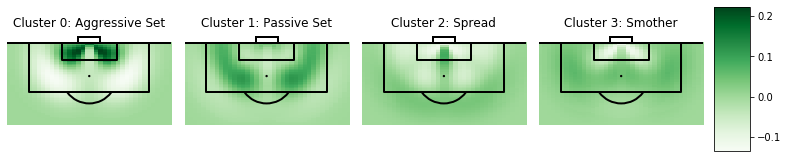

In [48]:
plotXSMap(xs_map, num_clusters=4, cluster_names=cluster_name)

In [48]:
#Calculate xS map for when striker is under pressure
xs_map_up = getXSMap(train_df, svm, scaler, num_clusters=4, up=1)

done cluster 0
done cluster 1
done cluster 2
done cluster 3


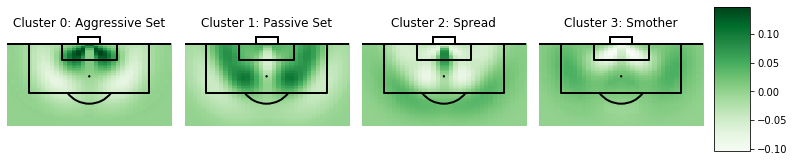

In [49]:
plotXSMap(xs_map_up, num_clusters=4, cluster_names=cluster_name)

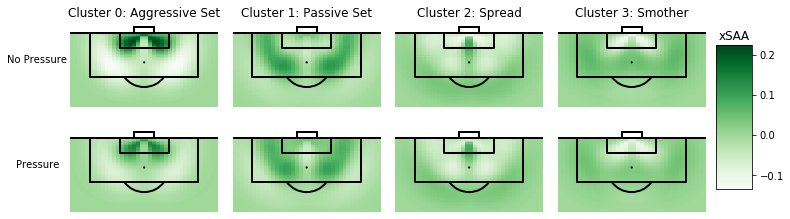

In [50]:
plotDoubleXSMap(xs_map, xs_map_up)
#plt.savefig('xs_map.png', bbox_inches='tight')

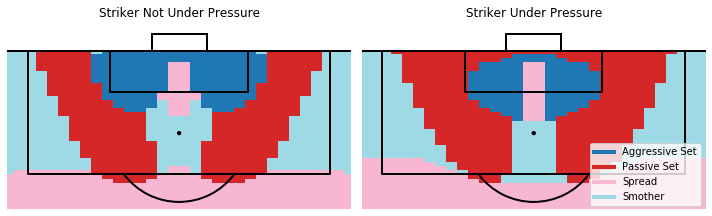

In [51]:
plotBestTechniqueUp(xs_map, xs_map_up, cluster_name)
plt.tight_layout()
#plt.savefig('optimal_technique.png')

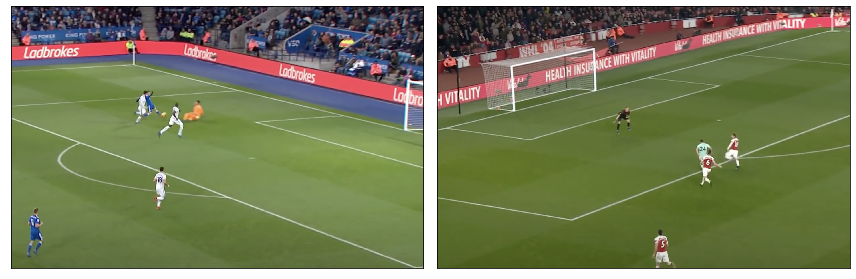

In [52]:
image = cv2.cvtColor(cv2.imread('images/example1.png'), cv2.COLOR_BGR2RGB)
image1 = cv2.cvtColor(cv2.imread('images/example2.png'), cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].imshow(image)
ax[1].imshow(image1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
#plt.savefig('example_1v1s.png')
plt.show()

In [53]:
#Neil Etheridge
print("Actual: Smother", svm.predict_proba(np.array([0.69060136,1.5159017,0,0,0,0,1]).reshape(1,-1)))
print("Aggressive Set", svm.predict_proba(np.array([0.69060136,1.5159017,0,1,0,0,0]).reshape(1, -1)))
print("Passive Set", svm.predict_proba(np.array([0.69060136,1.5159017,0,0,1,0,0]).reshape(1, -1)))
print("Spread", svm.predict_proba(np.array([0.69060136,1.5159017,0,0,0,1,0]).reshape(1, -1)))

Actual: Smother [[0.37123901 0.62876099]]
Aggressive Set [[0.54761141 0.45238859]]
Passive Set [[0.32714546 0.67285454]]
Spread [[0.44017619 0.55982381]]


In [54]:
#Bernd Leno
print("Actual: Aggressive Set", svm.predict_proba(np.array([-0.15589943,1.8885945,0,1,0,0,0]).reshape(1, -1)))
print("Passive Set", svm.predict_proba(np.array([-0.15589943,1.8885945,0,0,1,0,0]).reshape(1, -1)))
print("Spread", svm.predict_proba(np.array([-0.15589943,1.8885945,0,0,0,1,0]).reshape(1, -1)))
print("Smother", svm.predict_proba(np.array([-0.15589943,1.8885945,0,0,0,0,1]).reshape(1, -1)))

Actual: Aggressive Set [[0.65851624 0.34148376]]
Passive Set [[0.46282791 0.53717209]]
Spread [[0.54469217 0.45530783]]
Smother [[0.50698902 0.49301098]]


## Learning From The Pros

In [49]:
def getGKEM(amateur_1v1s):
    dist_to_goal = []
    striker_to_gk = []
    goal_angle = []
    for i in range(len(amateur_1v1s)):
        dist_to_goal.append(gk.distance_to_goal(amateur_1v1s['striker_x'][i], amateur_1v1s['striker_y'][i]))
        striker_to_gk.append(gk.distance_to_goal(amateur_1v1s['striker_x'][i], amateur_1v1s['striker_y'][i], amateur_1v1s['gk_x'][i], amateur_1v1s['gk_y'][i]))
        goal_angle.append(gk.goal_angle(amateur_1v1s['striker_x'][i], amateur_1v1s['striker_y'][i]))
    amateur_1v1s['gkem'] = np.array(striker_to_gk) / np.array(dist_to_goal)
    amateur_1v1s['distance_to_goal'] = dist_to_goal
    amateur_1v1s['goal_angle'] = goal_angle
    return amateur_1v1s

In [50]:
#Import and clean amateur 1v1s event data
amateur_1v1s = pd.read_csv('data/amateur_1v1.csv')
amateur_1v1s = amateur_1v1s[['X','Y','X2','Y2']]
amateur_1v1s.columns = ['striker_x','striker_y','gk_x','gk_y']
amateur_1v1s['striker_x'] = amateur_1v1s['striker_x'] * 120 / 100
amateur_1v1s['gk_x'] = amateur_1v1s['gk_x'] * 120 / 100
amateur_1v1s['striker_y'] = amateur_1v1s['striker_y'] * 80 / 100
amateur_1v1s['gk_y'] = amateur_1v1s['gk_y'] * 80 / 100
amateur_1v1s['under_pressure'] = 0
amateur_1v1s = getGKEM(amateur_1v1s)
amateur_1v1s.head()

striker_x  striker_y   gk_x  gk_y  under_pressure      gkem  \
0      104.4       49.6  116.4  42.4               0  0.763997   
1      106.8       51.2  116.4  43.2               0  0.721865   
2      114.0       52.8  116.4  47.2               0  0.430986   
3      106.8       45.6  114.0  41.6               0  0.574422   
4      103.2       44.8  116.4  40.8               0  0.789408   

   distance_to_goal  goal_angle  
0         18.317205   31.607502  
1         17.311268   40.314100  
2         14.136478   64.885165  
3         14.338759   22.988717  
4         17.472264   15.945396

In [51]:
amateur_1v1s.shape

(18, 8)

In [52]:
#Import Amateur 3D poses
amateur_2d = pd.read_csv('data/amateur_2d_1v1s.csv', index_col=0)
amateur_3d = pd.read_csv('data/amateur_3d_1v1s.csv', index_col=0)
pose_3d = amateur_3d.values

In [53]:
#Get camera-view invariant dataset of 3d poses
pose_vi = gk.cameraInvariantDataset(pose_3d)
#Rotates the poses from images taken from behind by 180 degrees
pose_vi = gk.flipBehindPoses(pose_vi)

In [55]:
#Add GKEM to body pose matrix
add_gkem = pd.DataFrame(pose_vi)
add_gkem['gkem'] = amateur_1v1s['gkem']
pose_vi_gkem = add_gkem.values

In [56]:
#Create 3D - 2D projection dataset
to_delete = np.array([ x-1 for x in range(0,49) if x%3==0][1:])
pose_2d_proj = np.delete(pose_vi_gkem, to_delete, 1)

In [57]:
#Get technique from K-Means Model
amateur_technique_preds = kmeans.predict(pose_2d_proj)
amateur_1v1s['cluster'] = amateur_technique_preds

In [60]:
#Prepare model input
amateur_model_df = amateur_1v1s[['goal_angle','distance_to_goal','under_pressure','cluster']].copy()
amateur_model_df[['goal_angle','distance_to_goal']] = scaler.transform(amateur_model_df[['goal_angle','distance_to_goal']])
amateur_model_df = pd.get_dummies(amateur_model_df, columns=['cluster'])
amateur_model_df['cluster_3'] = 0
amateur_model_df.head()

In [62]:
#Convert model input to matrix
amateur_model_input = amateur_model_df.values

In [63]:
#Get xS from SVM Model
amateur_1v1s['xS'] = svm.predict_proba(amateur_model_input)[:,1]

In [71]:
def getOptimalSaveTechnique(amateur_1v1s, amateur_model_df, scaler, num_clusters=4):
    optimal_cluster = []
    mean_xs = []
    for i in range(len(amateur_1v1s)):
        angle = amateur_1v1s.loc[i, 'goal_angle']
        dist = amateur_1v1s.loc[i, 'distance_to_goal']
        up = amateur_1v1s.loc[i, 'under_pressure']
        xs_list = []
        for cluster in range(num_clusters):
            inp = getxSInput(amateur_model_df, scaler, angle=angle, dist=dist, up=up, cluster=cluster)
            xs_list.append(svm.predict_proba(inp)[0][1])
        optimal_cluster.append(np.argmax(xs_list))
        mean_xs.append(np.mean(xs_list))
    return optimal_cluster, mean_xs

In [74]:
amateur_1v1s['optimal_cluster'], amateur_1v1s['mean_xs'] = getOptimalSaveTechnique(amateur_1v1s, amateur_model_df, scaler)
amateur_1v1s['xSAA'] = amateur_1v1s['xS'] - amateur_1v1s['mean_xs']
print("% Correct Technique:", np.mean(amateur_1v1s['cluster'] == amateur_1v1s['optimal_cluster']))

In [78]:
amateur_1v1s

striker_x  striker_y   gk_x  gk_y  under_pressure      gkem  \
0       104.4       49.6  116.4  42.4               0  0.763997   
1       106.8       51.2  116.4  43.2               0  0.721865   
2       114.0       52.8  116.4  47.2               0  0.430986   
3       106.8       45.6  114.0  41.6               0  0.574422   
4       103.2       44.8  116.4  40.8               0  0.789408   
5       109.2       45.6  112.8  43.2               0  0.355649   
6       108.0       48.0  116.4  42.4               0  0.700000   
7       109.2       52.8  116.4  44.0               0  0.678914   
8       111.6       34.4  114.0  37.6               0  0.396214   
9       110.4       49.6  115.2  44.8               0  0.500000   
10      114.0       36.0  117.6  39.2               0  0.667947   
11      114.0       32.8  116.4  36.0               0  0.426790   
12      112.8       45.6  116.4  42.4               0  0.528059   
13      105.6       47.2  114.0  41.6               0  0.627064   
14      106.8       32.0  114.0  37.6               0  0.590955   
15      108.0       28.0  114.0  35.2               0  0.552268   
16      114.0       42.4  117.6  41.6               0  0.570675   
17      110.4       53.6  116.4  44.0               0  0.680052   

    distance_to_goal  goal_angle  cluster        xS  optimal_cluster  \
0          18.317205   31.607502        1  0.547970                1   
1          17.311268   40.314100        1  0.660132                1   
2          14.136478   64.885165        2  0.539638                1   
3          14.338759   22.988717        1  0.430027                1   
4          17.472264   15.945396        1  0.356804                1   
5          12.165525   27.407575        2  0.308078                1   
6          14.422205   33.690068        1  0.583068                1   
7          16.747537   49.844000        1  0.709213                1   
8          10.095544   33.690068        2  0.337116                0   
9          13.576450   45.000000        2  0.552041                1   
10          7.211103   33.690068        2  0.294607                0   
11          9.372300   50.194429        2  0.461479                0   
12          9.121403   37.874984        2  0.352519                0   
13         16.099689   26.565051        1  0.500000                1   
14         15.435025   31.218403        1  0.567640                1   
15         16.970563   45.000000        0  0.468433                1   
16          6.462198   21.801409        2  0.306330                2   
17         16.646922   54.782407        1  0.704331                1   

     mean_xs      xSAA  
0   0.451971  0.095999  
1   0.549001  0.111131  
2   0.590143 -0.050505  
3   0.351507  0.078520  
4   0.309436  0.047368  
5   0.367773 -0.059695  
6   0.478665  0.104404  
7   0.611284  0.097930  
8   0.386332 -0.049216  
9   0.600321 -0.048280  
10  0.331960 -0.037353  
11  0.520725 -0.059246  
12  0.404153 -0.051634  
13  0.401147  0.098853  
14  0.456887  0.110752  
15  0.588739 -0.120306  
16  0.287874  0.018456  
17  0.613612  0.090719

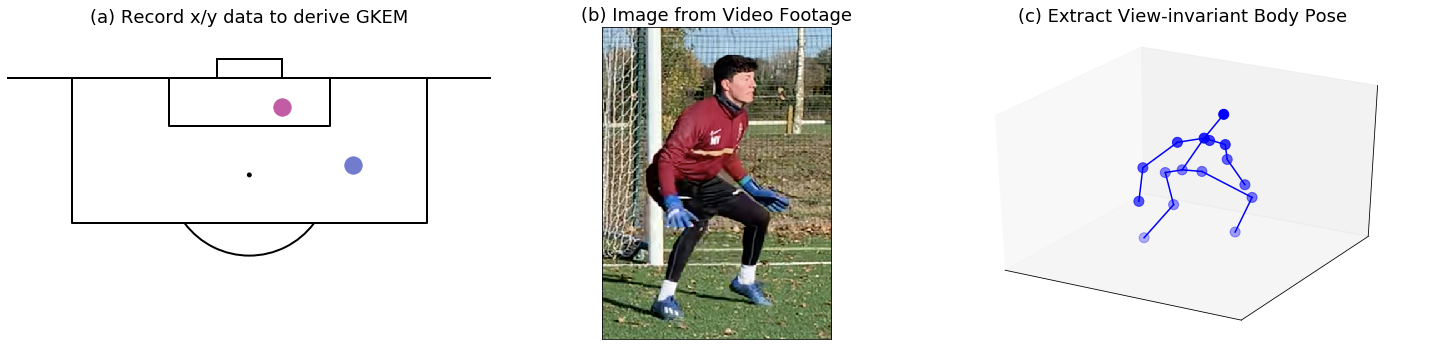

In [132]:
save_id = 7
ms = 300
path = 'images/amateur_1v1/'
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 3, 1)
pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-30, 
                      pad_left=-10, pad_right=-10, line_color='black')
pitch.draw(ax=ax)
pitch.scatter(amateur_1v1s.loc[save_id, 'striker_x'], amateur_1v1s.loc[save_id, 'striker_y'],
              c='#727cce', label='Striker', s=ms, ax=ax)
pitch.scatter(amateur_1v1s.loc[save_id, 'gk_x'], amateur_1v1s.loc[save_id, 'gk_y'],
              c='#c15ca5', label='Goalkeeper', s=ms, ax=ax)
ax.set_title('(a) Record x/y data to derive GKEM', fontsize=18, pad=23)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(gk.importImage(path + str(save_id) + '.png'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('(b) Image from Video Footage', fontsize=18)
ax = fig.add_subplot(1, 3, 3, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_3d[save_id]), mpii_edges)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title('(c) Extract View-invariant Body Pose', fontsize=18, pad=30)
plt.tight_layout()
#plt.savefig('paper_viz/amateur_data_collection.png')
plt.show()

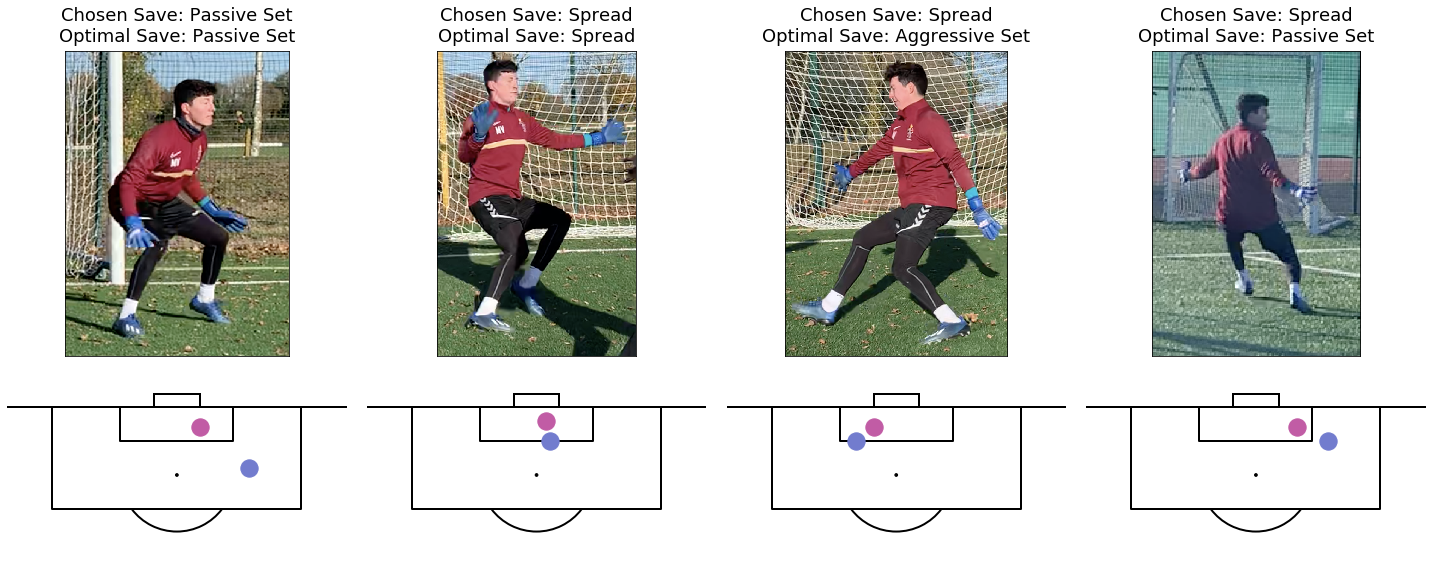

In [166]:
save_ids = [7,16,11,2]
saves_dict = {
    0: 'Aggressive Set',
    1: 'Passive Set',
    2: 'Spread',
    3: 'Smother'
}
fig = plt.figure(figsize=(20,9))
for i, save_id in enumerate(save_ids):
    #Images
    ax = fig.add_subplot(2, 4, i+1)
    ax.imshow(gk.importImage(path + str(save_id) + '.png'))
    ax.set_xticks([])
    ax.set_yticks([])
    chosen_save = saves_dict[amateur_1v1s.loc[save_id, 'cluster']]
    optimal_save = saves_dict[amateur_1v1s.loc[save_id, 'optimal_cluster']]
    ax.set_title('Chosen Save: ' + chosen_save + '\nOptimal Save: ' + optimal_save, 
                 fontsize=18, pad=10)
    #Pitches
    ax = fig.add_subplot(2, 4, i+5)
    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-30, 
                          pad_left=-10, pad_right=-10, line_color='black')
    pitch.draw(ax=ax)
    pitch.scatter(amateur_1v1s.loc[save_id, 'striker_x'], amateur_1v1s.loc[save_id, 'striker_y'],
                  c='#727cce', label='Striker', s=ms, ax=ax)
    pitch.scatter(amateur_1v1s.loc[save_id, 'gk_x'], amateur_1v1s.loc[save_id, 'gk_y'],
                  c='#c15ca5', label='Goalkeeper', s=ms, ax=ax)
plt.tight_layout()
#plt.savefig('paper_viz/learning_from_pros.png')
plt.show()

## Penalty Analysis

In [29]:
def cleanPenDataFrames(pose_3d_df, pose_3d_2_df):
    #pose_3d_3_df: 17 - 19 data
    #pose_3d_df: 19 - 21 data
    #Change shots that hit post to 'Off T'
    pose_3d_2_df.loc[pose_3d_2_df.shot_outcome_name == 'Post', 'shot_outcome_name'] = 'Off T'
    pose_3d_2_df.drop(columns=['match_id','minute','team_id','team_name','player_id','shot_body_part_name',
                     'shot_technique_name','date','home_team','away_team','season',
                     'competition','gk_id'], inplace=True)
    pose_3d_df.loc[pose_3d_df.off_target == 1, 'outcome'] = 'Off T'
    pose_3d_df.loc[pose_3d_df.outcome == 'Scored', 'outcome'] = 'Goal'
    pose_3d_df.loc[pose_3d_df.outcome == 'Missed', 'outcome'] = 'Saved'
    pose_3d_df.drop(columns=['url','off_target'], inplace=True)
    reorder = ['pen_taker','outcome','goalkeepers'] + list(map(str, list(range(int(pose_3d_df.columns[-1]) + 1))))
    pose_3d_df = pose_3d_df[reorder]
    pose_3d_2_df.rename(columns={"player_name": "pen_taker", 
                                 "shot_outcome_name": "outcome",
                                 "gk_name": "goalkeepers"}, inplace=True)
    joined_pose_3d_df = pose_3d_2_df.append(pose_3d_df, ignore_index=True) #contains all pens
    joined_pose_3d_df.dropna(inplace=True)
    pose_arr = joined_pose_3d_df.loc[:,'0':].values
    return (joined_pose_3d_df, pose_arr)

In [30]:
#3D pose data - 2019/20 and 2020/21
pose_3d_df = pd.read_csv('data/pen_pose_3d_19_20_20_21.csv', index_col=0)
pose_3d_2_df = pd.read_csv('data/pen_pose_3d_17_18_18_19.csv', index_col=0)
joined_pose_3d_df, pose_arr = cleanPenDataFrames(pose_3d_df, pose_3d_2_df)

In [34]:
#2D pose data
pose_2d_df = pd.read_csv('data/pen_pose_2d_19_20_20_21.csv', index_col=0)
pose_2d_2_df = pd.read_csv('data/pen_pose_2d_17_18_18_19.csv', index_col=0)
joined_pose_2d_df, pose_2d_arr = cleanPenDataFrames(pose_2d_df, pose_2d_2_df)

In [35]:
#Percentage of pens that were saved in our dataset
np.mean(joined_pose_3d_df['outcome'] == 'Saved') * 100

16.260162601626014

In [36]:
def getArrayID(pose_df, photo_id):
    return np.where(np.array(pose_df.index) == photo_id)[0][0]

In [37]:
def getImageID(pose_df, array_id):
    #Input: pose_df - dataframe with raw pose information - index matches to photo name
    #Input: array_id - location of pose in array
    #Returns: photo name/id
    return np.array(pose_df.index)[array_id]

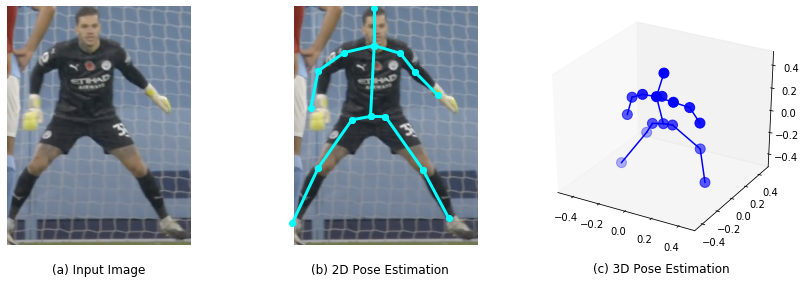

In [218]:
#Human Body Pose Estimation Example
#Show image, image with 2D pose overlay, and 3D pose estimate
photo_id = 315
array_id = getArrayID(joined_pose_3d_df, photo_id)
image = gk.importImage('images/pen_images/combined_data/' + str(photo_id)+'.png')
pose_2d = gk.pose_to_matrix(pose_2d_arr[array_id])
points = gk.pose_to_matrix(pose_arr[array_id])

fig = plt.figure(figsize=(12, 4))
#fig.patch.set_visible(False)
ax = fig.add_subplot(1, 3, 1)
ax.imshow(image)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax.set_title('(a) Input Image', y=-0.14)

ax = fig.add_subplot(1, 3, 2)
ax.imshow(image)
for e in range(len(mpii_edges)):
    ax.plot(pose_2d[mpii_edges[e]][:, 0], pose_2d[mpii_edges[e]][:, 1], c='cyan', lw=3, marker='o')
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax.set_title('(b) 2D Pose Estimation', y=-0.14)
    
ax = fig.add_subplot(1, 3, 3, projection='3d')
gk.plot3D(ax, points, mpii_edges)
ax.set_title('(c) 3D Pose Estimation', y=-0.15)
plt.tight_layout()
#plt.savefig('poseEstimationExample.png')
plt.show()

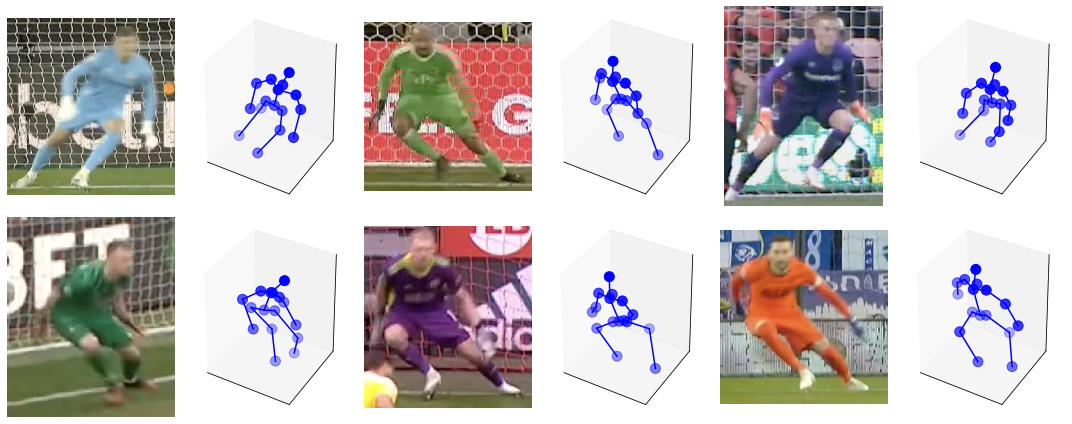

In [219]:
#Common Failure Cases
path = 'images/pen_images/combined_data/'
pic_ids = [388, 20, 3]
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(2, 6, 1)
ax.imshow(gk.importImage(path + str(pic_ids[0]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 2, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[getArrayID(joined_pose_3d_df, pic_ids[0])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

ax = fig.add_subplot(2, 6, 3)
ax.imshow(gk.importImage(path + str(pic_ids[1]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 4, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[getArrayID(joined_pose_3d_df, pic_ids[1])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

ax = fig.add_subplot(2, 6, 5)
ax.imshow(gk.importImage(path + str(pic_ids[2]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 6, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[getArrayID(joined_pose_3d_df,pic_ids[2])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

pic_ids = [243, 302, 377]

ax = fig.add_subplot(2, 6, 7)
ax.imshow(gk.importImage(path + str(pic_ids[0]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 8, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[getArrayID(joined_pose_3d_df, pic_ids[0])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

ax = fig.add_subplot(2, 6, 9)
ax.imshow(gk.importImage(path + str(pic_ids[1]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 10, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[getArrayID(joined_pose_3d_df, pic_ids[1])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

ax = fig.add_subplot(2, 6, 11)
ax.imshow(gk.importImage(path + str(pic_ids[2]) + '.png'))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
ax = fig.add_subplot(2, 6, 12, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[getArrayID(joined_pose_3d_df,pic_ids[2])]), mpii_edges)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

#plt.suptitle('Success Cases', y=1.05, fontsize=18)
plt.tight_layout()
#plt.savefig('viz_diss/successcases.png', dpi=500, bbox_inches='tight')
plt.show()

In [38]:
#Get camera-view invariant dataset of 3d poses
pen_pose_vi = gk.cameraInvariantDataset(pose_arr)
#Rotates the poses from images taken from behind by 180 degrees
pen_pose_vi = gk.flipBehindPoses(pen_pose_vi)

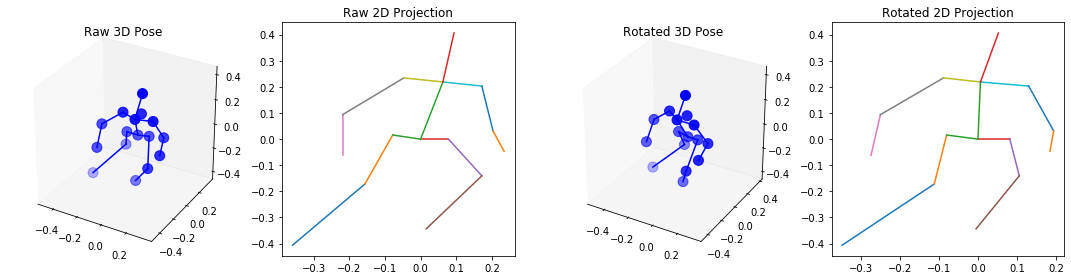

In [61]:
#Camera-view invariance example
pose_id = 2
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 4, 1, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pose_arr[pose_id]), mpii_edges)
ax.set_title('Raw 3D Pose')
ax = fig.add_subplot(1, 4, 3, projection='3d')
gk.plot3D(ax, gk.pose_to_matrix(pen_pose_vi[pose_id]), mpii_edges)
ax.set_title('Rotated 3D Pose')
ax = fig.add_subplot(1, 4, 2)
gk.plot2D(ax, gk.pose_to_matrix(pose_arr[pose_id]), mpii_edges)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Raw 2D Projection')
ax = fig.add_subplot(1, 4, 4)
gk.plot2D(ax, gk.pose_to_matrix(pen_pose_vi[pose_id]), mpii_edges)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Rotated 2D Projection')
plt.tight_layout()
#plt.savefig('viz/camera_invariance.png', dpi=500)
plt.show()

In [232]:
to_remove = np.array([0,5,7,9,10,11,15,17,19,23,25,26,27,30,31,36,40,48,52,53,56,57,58,59,62,65,66,
             68,69,75,77,79,80,84,86,87,89,92,93,96,97,99,100,101,102,103,108,111,113,116,
             119,121,125,126,135,138,140,141,143,145,146,147,152,155,159,165,166,169,173,
             177,178,179,186,187,188,190,191,192,194,203,207,211,213,220,221,222,224,227,
             235,240,241,242,248,249,257,260,261,262,268,270,271,272,275,276,277,278,279,
             281,282,291,294,299,301,305,312,314,317,322,324,331,333,335,336,341,347,349,351,
             352,362,368,376,382,387,392,394,395])
print(len(to_remove))

136


In [233]:
#Good Poses DataFrame
good_poses_3d_df = joined_pose_3d_df.drop(to_remove)

In [234]:
good_poses_3d_df.head()

pen_taker outcome        goalkeepers         0         1  \
1         Eden Hazard    Goal        Karl Darlow -0.171875  0.359375   
3         Joshua King    Goal    Jordan Pickford -0.359375  0.406250   
4   Wayne Mark Rooney    Goal        Mathew Ryan -0.171875  0.281250   
6        Glenn Murray   Saved  Kasper Schmeichel -0.484375  0.343750   
13   Junior Stanislas    Goal    Wayne Hennessey -0.343750  0.375000   

           2         3         4         5         6  ...        38        39  \
1   0.165714 -0.156250  0.250000  0.315193  0.062500  ...  0.029968 -0.171875   
3  -0.032765 -0.156250  0.171875  0.101421 -0.078125  ... -0.129461  0.171875   
4  -0.017270 -0.171875  0.062500  0.132535 -0.062500  ... -0.123473  0.078125   
6  -0.040460 -0.296875  0.218750  0.226595 -0.109375  ... -0.030425  0.203125   
13 -0.055004 -0.140625  0.218750  0.212009 -0.062500  ... -0.067645  0.203125   

          40        41        42        43        44        45        46  \
1  -0.234375  0.037787  0.203125 -0.031250 -0.065823  0.187500  0.234375   
3  -0.203125 -0.091516  0.203125 -0.031250  0.010528  0.234375  0.046875   
4  -0.062500 -0.169144  0.093750  0.062500 -0.114870  0.093750  0.187500   
6  -0.218750 -0.031844  0.265625 -0.046875  0.022101  0.125000 -0.062500   
13 -0.234375 -0.074421  0.109375 -0.109375  0.054955  0.109375 -0.015625   

          47  
1  -0.155435  
3  -0.102935  
4  -0.189607  
6   0.010645  
13  0.026388  

[5 rows x 51 columns]

In [235]:
#Good Poses Matrix
good_poses_3d_arr = good_poses_3d_df.loc[:,'0':].values

In [268]:
def PenFeatureSpace(clean_poses):
    #Input: clean_poses - dataset off all of the camera-invariant poses
    #Returns: dataset of poses in feature space
    pose_features = np.zeros((len(clean_poses), 5))
    for i in range(len(clean_poses)):
        pose_3d = gk.pose_to_matrix(clean_poses[i])
        feature_array = np.array([torsoAngle(pose_3d), bodyHeight(pose_3d), 
                                  forwardStep(pose_3d), handHeight(pose_3d),
                                  bodyAngle(pose_3d)])
        pose_features[i] = feature_array
    return pose_features

In [274]:
def torsoAngle(pose_3d):
    #Torso Angle
    torso_angle = math.atan2(pose_3d[7][0], -pose_3d[7][1])*180/math.pi
    return np.abs(torso_angle)

In [270]:
def bodyHeight(pose_3d):
    #Body Height
    height = np.abs(np.max(-pose_3d[:, 1]) - np.min(-pose_3d[:, 1]))
    return height

In [271]:
def forwardStep(pose_3d):
    #Distance of forward step
    forward_step = np.abs(pose_3d[0][2] - pose_3d[5][2])
    return forward_step

In [272]:
def handHeight(pose_3d):
    hand_height = np.abs(np.min(-pose_3d[:, 1]) - np.min(-pose_3d[[10, 15]][:, 1]))
    return hand_height

In [275]:
def bodyAngle(pose_3d):
    midpoint = (pose_3d[0][:2] + pose_3d[5][:2])/2
    midpoint[1] *= -1
    torso = pose_3d[7][:2] * np.array([1, -1])
    body_angle_vec = torso-midpoint
    return np.abs(math.atan2(body_angle_vec[0], body_angle_vec[1])*180/math.pi)

In [276]:
#Convert all the good poses to the features space
poses_features = PenFeatureSpace(good_poses_3d_arr)

In [279]:
kmeans_pens = KMeans(n_clusters=2, random_state = 13).fit(poses_features)

In [280]:
kmeans_pens_preds = kmeans_pens.predict(poses_features)

In [281]:
pens_tsne = TSNE(n_components=2, random_state=29).fit_transform(poses_features)

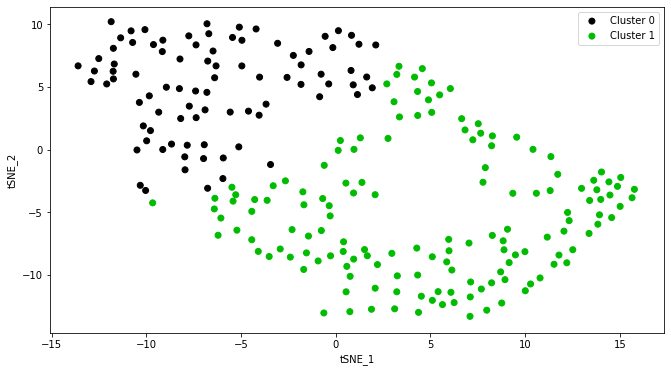

In [394]:
plt.figure(figsize=(11, 6))
for i in range(2):
    current_pose_type = pens_tsne[kmeans_pens_preds == i]
    colors_kmeans = cm.nipy_spectral(kmeans_pens_preds[kmeans_pens_preds==i].astype(float) / 2)
    plt.scatter(current_pose_type[:,0], current_pose_type[:,1], 
                c=colors_kmeans, label='Cluster ' + str(i))
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.legend()
#plt.savefig('paper_viz/tsne_pen.png')
plt.show()

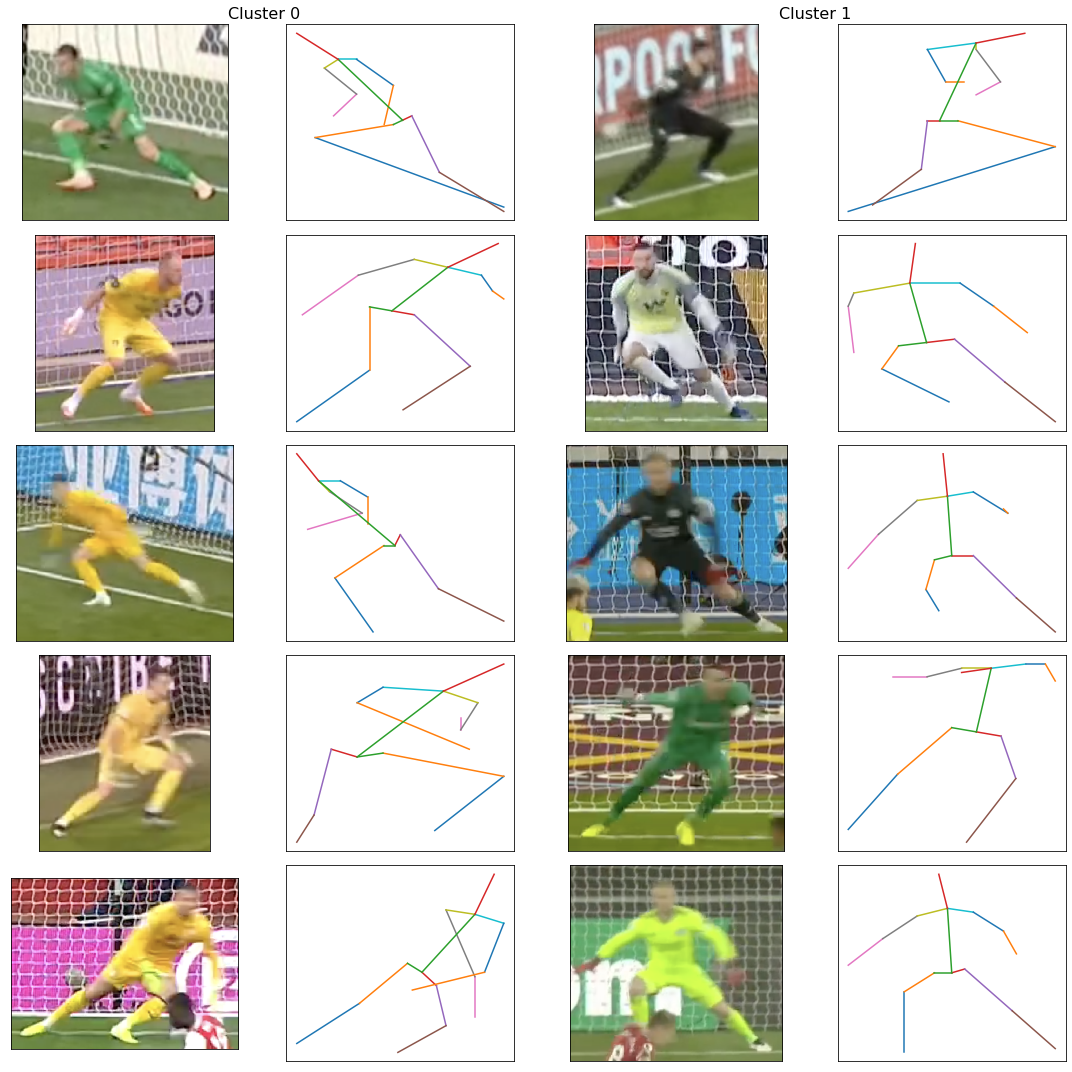

In [396]:
#GMM - 3D pose, 2D pose viz cluster examples
path = 'images/pen_images/combined_data/'
ax_array = [1, 5, 9, 13, 17]
fig = plt.figure(figsize=(15, 15))
for a in ax_array:
    arr_id = np.random.choice(np.where(kmeans_pens_preds == 0)[0])
    photo_id = getImageID(good_poses_3d_df, arr_id)
    ax = fig.add_subplot(5, 4, a)
    ax.imshow(gk.importImage(path + str(photo_id) + '.png'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(5, 4, a+1)
    gk.plot2D(ax, gk.pose_to_matrix(good_poses_3d_arr[arr_id]), mpii_edges)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if a == 1:
        ax.set_title('Cluster ' + str(0), position=(-0.1, 1), size=16)
        
    arr_id = np.random.choice(np.where(kmeans_pens_preds == 1)[0])
    photo_id = getImageID(good_poses_3d_df, arr_id)
    ax = fig.add_subplot(5, 4, a+2)
    ax.imshow(gk.importImage(path + str(photo_id) + '.png'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(5, 4, a+3)
    gk.plot2D(ax, gk.pose_to_matrix(good_poses_3d_arr[arr_id]), mpii_edges)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if a == 1:
        ax.set_title('Cluster ' + str(1), position=(-0.1, 1), size=16)
    
plt.tight_layout()
#plt.savefig('viz_diss/Diss/appendix/pen_gmm_k2.png')
plt.show()

In [287]:
#Save % for cluster 0 saves
np.mean(good_poses_3d_df[kmeans_pens_preds == 0]['outcome'] == 'Saved')

0.18604651162790697

In [288]:
#Save % for cluster 1 saves
np.mean(good_poses_3d_df[kmeans_pens_preds == 1]['outcome'] == 'Saved')

0.14965986394557823

In [368]:
#Create dataframe of good poses features
good_poses_feat_df = pd.DataFrame({'outcome': good_poses_3d_df['outcome']})
good_poses_feat_df = pd.concat([good_poses_feat_df, pd.DataFrame(poses_features, index=good_poses_feat_df.index)], axis=1)
#Drops 8 observations where the strike was off target
good_poses_feat_df = good_poses_feat_df.loc[good_poses_feat_df['outcome']  != 'Off T',:]
good_poses_feat_df.columns = ['outcome','torso_angle','body_height','forward_step',
                              'hand_height','body_angle']

In [369]:
#Make target variable boolean - 1=Save, 0=Goal
good_poses_feat_df['outcome'] = np.array((good_poses_feat_df['outcome'] == 'Saved').astype(int))

In [370]:
continuous_var = ['torso_angle','body_height','forward_step','hand_height','body_angle']

In [371]:
#Train/Test Split (70/30)
split_index = good_poses_feat_df.index[int(len(good_poses_feat_df)*0.7)]
test_df = good_poses_feat_df.loc[split_index:, :].copy() 
train_df = good_poses_feat_df.loc[:split_index-1, :].copy() 

In [372]:
#Standardise continuous variables
scaler = StandardScaler()
scaler.fit(train_df[continuous_var])
train_df[continuous_var] = scaler.transform(train_df[continuous_var])
test_df[continuous_var] = scaler.transform(test_df[continuous_var])

In [374]:
#Add intercept term
train_df['coef'] = 1
test_df['coef'] = 1

In [375]:
train_df.head()

outcome  torso_angle  body_height  forward_step  hand_height  body_angle  \
1         0    -0.841042     0.704371      0.705889    -1.095364    0.033947   
3         0    -0.303156     0.847432     -0.780754     0.363263    0.012007   
4         0    -0.303156    -0.726240     -0.192359    -1.824677   -0.249652   
6         1    -0.064290     0.847432     -1.102951     0.363263    0.777688   
13        0     0.191781     0.561310      0.586017     0.800851   -0.288892   

    coef  
1      1  
3      1  
4      1  
6      1  
13     1

In [376]:
import statsmodels.api as sm

In [377]:
#Train logistic regression
log_reg = sm.Logit(train_df['outcome'], train_df[train_df.columns[1:]]).fit()

Optimization terminated successfully.
         Current function value: 0.476922
         Iterations 6


In [378]:
#Logistic regression summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                  157
Model:                          Logit   Df Residuals:                      151
Method:                           MLE   Df Model:                            5
Date:                Thu, 25 Nov 2021   Pseudo R-squ.:                 0.02228
Time:                        21:13:22   Log-Likelihood:                -74.877
converged:                       True   LL-Null:                       -76.583
Covariance Type:            nonrobust   LLR p-value:                    0.6367
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
torso_angle      0.0447      0.263      0.170      0.865      -0.471       0.560
body_height     -0.1887      0.249     -0.759      0.448      -0.676       0.299
forward_step     0.0209      0.213      0.098      0.922      -0.396       0.438
hand_height      0.2170      0.229      0.946      0.344      -0.232       0.666
body_angle       0.2681      0.241      1.114      0.265      -0.203       0.740
coef            -1.4829      0.210     -7.073      0.000      -1.894      -1.072
================================================================================
"""

In [379]:
#Predictions
y_pred = log_reg.predict(test_df[test_df.columns[1:]])

In [381]:
#Prediction stats
print('Max xS:', np.max(y_pred))
print('Min xS:', np.min(y_pred))
print('Mean xS:', np.mean(y_pred))

Max xS: 0.32883922502278135
Min xS: 0.10510188924877313
Mean xS: 0.17710131739412605


In [389]:
y_pred[y_pred < 0.5] = 0

In [392]:
#Accuracy
np.mean(np.array(y_pred) == test_df['outcome'])

0.8823529411764706